In [1]:
!python --version

Python 3.11.6


In [1]:
import os
import io
import pandas as pd
from google.cloud import storage
import ast
import matplotlib.pyplot as plt 
import seaborn as sns
import networkx as nx
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#### vote

##### accounts_attendance

In [2]:
accounts_attendance = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_attendance.parquet', engine='pyarrow')

In [ ]:
accounts_attendance

id                               attendance_date_list  user_id
0            1  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1446852
1            2  ["2023-05-27", "2023-05-29", "2023-05-30", "20...  1359398
2            3  ["2023-05-27", "2023-05-29", "2023-05-30", "20...  1501542
3            4  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1507767
4            5  ["2023-05-27", "2023-05-28", "2023-05-29", "20...  1287453
...        ...                                                ...      ...
349632  360501                                                 []   897005
349633  360502                                     ["2024-05-09"]  1407059
349634  360503                                     ["2024-05-09"]  1583727
349635  360504                                     ["2024-05-09"]  1392372
349636  360505                                     ["2024-05-09"]  1583730

[349637 rows x 3 columns]

In [6]:
accounts_attendance.isnull().sum()

id                      0
attendance_date_list    0
user_id                 0
dtype: int64

In [7]:
accounts_attendance.duplicated().sum()

0

In [9]:
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [ ]:
# Ìïú Î≤àÎèÑ Ï†ëÏÜçÌïòÏßÄ ÏïäÏùÄ Ïù¥Ïö©ÏûêÎäî 20945Î™ÖÏù¥Îã§.
accounts_attendance.explode('attendance_date_list').isnull().sum()

id                          0
attendance_date_list    20945
user_id                     0
dtype: int64

In [ ]:
# Ï∂úÏÑù ÏãúÍ∞ÑÏù¥ Ï§ëÎ≥µÎêòÎäî Ïù¥Ïö©ÏûêÎäî 0Î™ÖÏù¥Îã§
accounts_attendance.explode('attendance_date_list').duplicated(subset=['attendance_date_list','user_id']).sum()

0

In [ ]:
attend = accounts_attendance.explode('attendance_date_list')

In [24]:
attend

id attendance_date_list  user_id
0            1           2023-05-27  1446852
25299    25901           2023-05-27  1490536
25298    25900           2023-05-27   942100
25297    25899           2023-05-27   902834
25296    25898           2023-05-27  1352980
...        ...                  ...      ...
90403    93546           2024-05-09  1217716
104690  108337           2024-05-09  1504940
43886    45200           2024-05-09   846346
242384  250294           2024-05-09  1276487
349636  360505           2024-05-09  1583730

[2222327 rows x 3 columns]

In [ ]:
attend = attend[attend['attendance_date_list'].isnull()==False].sort_values(by = 'attendance_date_list')

In [12]:
attend = attend.sort_values(by = 'attendance_date_list')

In [ ]:
accounts_attendance = attend.drop_duplicates(subset=['user_id'],keep='last')[['user_id','attendance_date_list']].rename(columns={'attendance_date_list':'created_at'})

##### accounts_blockrecord

In [16]:
accounts_blockrecord = pd.read_parquet('gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet', engine='pyarrow')

In [ ]:
accounts_blockrecord

id              reason          created_at  block_user_id  user_id
0          1               Í∑∏ÎÉ•... 2023-05-04 23:01:53         867483   878476
1          2         ÏπúÍµ¨ ÏÇ¨Ïù¥Í∞Ä Ïñ¥ÏÉâÌï¥Ïßê 2023-05-05 01:17:08         867190   867564
2          3  ÎÇòÎûë Í¥ÄÎ†® ÏóÜÎäî ÏßàÎ¨∏ÏùÑ ÏûêÍæ∏ Î≥¥ÎÉÑ 2023-05-05 01:50:55         875110   875261
3          6               Í∑∏ÎÉ•... 2023-05-05 05:21:52         883696   883511
4          7               Í∑∏ÎÉ•... 2023-05-05 06:40:34         871349   870177
...      ...                 ...                 ...            ...      ...
19477  25355               ÏÇ¨Ïπ≠ Í≥ÑÏ†ï 2024-04-05 08:15:03         875351   879416
19478  25356         ÏπúÍµ¨ ÏÇ¨Ïù¥Í∞Ä Ïñ¥ÏÉâÌï¥Ïßê 2024-04-25 09:28:19        1444256  1292346
19479  25357         ÏπúÍµ¨ ÏÇ¨Ïù¥Í∞Ä Ïñ¥ÏÉâÌï¥Ïßê 2024-04-25 09:28:24        1379126  1292346
19480  25360             Î™®Î•¥Îäî ÏÇ¨ÎûåÏûÑ 2024-05-05 11:06:31        1582869  1583612
19481  25361         ÏπúÍµ¨ ÏÇ¨Ïù¥Í∞Ä Ïñ¥ÏÉâÌï¥Ïßê 2024-05-06 13:03:37        1051912  1099125

[19482 rows x 5 columns]

In [27]:
accounts_blockrecord.loc[accounts_blockrecord.duplicated(subset=['block_user_id','user_id'],keep = False) == True]

id       reason          created_at  block_user_id  user_id
8         12           Í∏∞ÌÉÄ 2023-05-05 13:04:31         885794   879662
9         13           Í∏∞ÌÉÄ 2023-05-05 13:04:42         885794   879662
10        14        Í∑∏ÎÉ•... 2023-05-05 13:04:52         885794   879662
11        15           Í∏∞ÌÉÄ 2023-05-05 13:04:56         885794   879662
12        16           Í∏∞ÌÉÄ 2023-05-05 13:05:01         885794   879662
...      ...          ...                 ...            ...      ...
19228  24886      Î™®Î•¥Îäî ÏÇ¨ÎûåÏûÑ 2023-08-15 18:38:41         992181  1072478
19240  24899  ÏπúÍµ¨ ÏÇ¨Ïù¥Í∞Ä Ïñ¥ÏÉâÌï¥Ïßê 2023-08-18 12:12:28        1500131  1365572
19248  24912      Î™®Î•¥Îäî ÏÇ¨ÎûåÏûÑ 2023-08-21 23:12:23        1029653   955098
19295  25105      Î™®Î•¥Îäî ÏÇ¨ÎûåÏûÑ 2023-09-11 14:09:18        1019326   976341
19296  25106      Î™®Î•¥Îäî ÏÇ¨ÎûåÏûÑ 2023-09-11 14:09:27        1019326   976341

[1525 rows x 5 columns]

In [4]:
accounts_blockrecord.isnull().sum()

id               0
reason           0
created_at       0
block_user_id    0
user_id          0
dtype: int64

In [18]:
accounts_blockrecord = accounts_blockrecord.sort_values(by = 'created_at')

In [19]:
accounts_blockrecord = accounts_blockrecord.drop_duplicates(subset=['user_id'],keep='last')[['user_id','created_at']]

##### accounts_failpaymenthistory

In [20]:
accounts_failpaymenthistory = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet', engine='pyarrow')

In [ ]:
accounts_failpaymenthistory

id   productId phone_type          created_at  user_id
0      6   heart.200          A 2023-05-14 05:49:22  1055891
1      7   heart.777          A 2023-05-14 08:17:21  1152151
2      8   heart.777          A 2023-05-14 10:11:46   986200
3      9  heart.1000          A 2023-05-14 11:53:09  1028261
4     10   heart.777          A 2023-05-14 12:30:47  1235730
..   ...         ...        ...                 ...      ...
158  170   heart.777          A 2023-07-28 08:31:19  1254708
159  171        None          I 2023-08-12 11:26:59  1556867
160  172   heart.777          A 2023-08-14 23:47:46  1282373
161  173        None          I 2023-09-17 09:12:53   927108
162  174        None          I 2023-09-17 09:12:53   927108

[163 rows x 5 columns]

In [30]:
accounts_failpaymenthistory.isnull().sum()

id              0
productId     107
phone_type      0
created_at      0
user_id         0
dtype: int64

In [35]:
accounts_failpaymenthistory.loc[accounts_failpaymenthistory['productId'].isnull() == True,'phone_type'].unique()

array(['I'], dtype=object)

In [21]:
accounts_failpaymenthistory = accounts_failpaymenthistory.sort_values(by = 'created_at')

In [22]:
accounts_failpaymenthistory = accounts_failpaymenthistory.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_friendrequest

In [23]:
accounts_friendrequest = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_friendrequest.parquet', engine='pyarrow')

In [ ]:
accounts_friendrequest

id status          created_at          updated_at  \
0                7      P 2023-04-17 18:29:11 2023-04-17 18:29:11   
1               10      A 2023-04-17 18:29:11 2023-04-22 06:02:53   
2               11      A 2023-04-17 18:29:11 2023-04-18 19:28:41   
3               13      A 2023-04-17 18:29:11 2023-04-19 11:05:04   
4               20      P 2023-04-17 18:29:11 2023-04-17 18:29:11   
...            ...    ...                 ...                 ...   
17147170  19692975      P 2024-05-09 07:24:50 2024-05-09 07:24:50   
17147171  19692976      A 2024-05-09 07:31:41 2024-05-09 07:33:06   
17147172  19692977      P 2024-05-09 08:20:44 2024-05-09 08:20:44   
17147173  19692978      R 2024-05-09 09:19:40 2024-05-09 09:19:43   
17147174  19692979      P 2024-05-09 09:21:47 2024-05-09 09:21:47   

          receive_user_id  send_user_id  
0                  831962        837521  
1                  832151        837521  
2                  832340        837521  
3                  833041        837521  
4                  834415        837521  
...                   ...           ...  
17147170          1583730       1583731  
17147171          1583731       1583673  
17147172          1299129       1575671  
17147173          1304403       1392729  
17147174          1304403       1392729  

[17147175 rows x 6 columns]

In [4]:
accounts_friendrequest.isnull().sum()

id                 0
status             0
created_at         0
updated_at         0
receive_user_id    0
send_user_id       0
dtype: int64

In [9]:
accounts_friendrequest.groupby(['receive_user_id'])[['send_user_id']].count().reset_index().sort_values(by='send_user_id',ascending=False)

receive_user_id  send_user_id
59349            909685           218
14991            857348           199
64689            915445           198
10898            852224           195
220018          1083638           190
...                 ...           ...
586160          1490579             1
482285          1372948             1
629462          1540454             1
646667          1560385             1
639859          1552386             1

[660841 rows x 2 columns]

In [ ]:
accounts_friendrequest = accounts_friendrequest.sort_values(by = 'created_at')

In [ ]:
accounts_friendrequest = accounts_friendrequest.drop_duplicates(subset=['send_user_id'], keep='last')[['send_user_id','created_at']].rename(columns={'send_user_id': 'user_id'})

##### accounts_group

In [10]:
accounts_group = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_group.parquet', engine='pyarrow')

In [11]:
accounts_group

id  grade  class_num  school_id
0          1      1          1          1
1          8      3          2          1
2          9      3          3          1
3         10      2          2          1
4         11      2          3          1
...      ...    ...        ...        ...
84510  84542      3          2       5107
84511  84543      2          7       3487
84512  84544      3          1       5043
84513  84545      2          7        416
84514  84546      3         11       2240

[84515 rows x 4 columns]

In [12]:
accounts_group.isnull().sum()

id           0
grade        0
class_num    0
school_id    0
dtype: int64

##### accounts_nearbyschool

In [13]:
accounts_nearbyschool = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_nearbyschool.parquet', engine='pyarrow')

In [14]:
accounts_nearbyschool

id  distance  nearby_school_id  school_id
0      119021  0.004564                 6          7
1      119022  0.010787                13          7
2      119023  0.012928                20          7
3      119024  0.013590                 4          7
4      119025  0.014122                24          7
...       ...       ...               ...        ...
59495  178516  0.018277              1498       5961
59496  178517  0.018652              1474       5961
59497  178518  0.021143              1466       5961
59498  178519  0.024572              1467       5961
59499  178520  0.000000              5961       5961

[59500 rows x 4 columns]

In [15]:
accounts_nearbyschool.isnull().sum()

id                  0
distance            0
nearby_school_id    0
school_id           0
dtype: int64

##### accounts_paymenthistory

In [27]:
accounts_paymenthistory = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_paymenthistory.parquet', engine='pyarrow')

In [ ]:
accounts_paymenthistory

id   productId phone_type          created_at  user_id
0          6   heart.777          A 2023-05-13 21:28:34  1211127
1          7   heart.777          A 2023-05-13 21:29:39  1151343
2          8   heart.777          A 2023-05-13 21:31:33  1002147
3          9   heart.777          A 2023-05-13 21:31:39  1095040
4         11   heart.777          A 2023-05-13 21:34:32  1164081
...      ...         ...        ...                 ...      ...
95135  98074   heart.777          I 2024-05-06 14:51:27  1086654
95136  98075  heart.1000          I 2024-05-06 16:06:30   871740
95137  98076  heart.1000          I 2024-05-08 06:57:23  1166361
95138  98077  heart.1000          I 2024-05-08 14:12:45  1163480
95139  98078  heart.1000          I 2024-05-08 14:12:45  1163480

[95140 rows x 5 columns]

In [18]:
accounts_paymenthistory.isnull().sum()

id            0
productId     0
phone_type    0
created_at    0
user_id       0
dtype: int64

In [3]:
payment = accounts_paymenthistory.groupby('user_id')['id'].count().reset_index().sort_values(by='id', ascending=False)

In [25]:
payment

user_id  id
55604  1527451  60
27744  1246471  51
17651  1141603  35
23067  1204373  34
17740  1142775  30
...        ...  ..
22263  1196164   1
22264  1196170   1
22265  1196185   1
22266  1196197   1
59191  1583632   1

[59192 rows x 2 columns]

In [29]:
accounts_paymenthistory['productId'].unique()

array(['heart.777', 'heart.200', 'heart.4000', 'heart.1000'], dtype=object)

In [14]:
accounts_paymenthistory['plus_point'] = accounts_paymenthistory['productId'].map(lambda x: int(x.split('.')[1]))

In [27]:
payment_plus_point = accounts_paymenthistory.groupby(['user_id'])[['plus_point']].sum().sort_values(by='plus_point', ascending=False).reset_index()

In [58]:
payment_plus_point

user_id  plus_point
0      1141603       75977
1      1167602       56777
2      1216899       49977
3      1111139       44777
4      1246471       42977
...        ...         ...
59187  1471470         200
59188  1488005         200
59189  1417284         200
59190  1549489         200
59191  1185586         200

[59192 rows x 2 columns]

In [28]:
accounts_paymenthistory.sort_values(by='created_at')

id   productId phone_type          created_at  user_id
0          6   heart.777          A 2023-05-13 21:28:34  1211127
1          7   heart.777          A 2023-05-13 21:29:39  1151343
2          8   heart.777          A 2023-05-13 21:31:33  1002147
3          9   heart.777          A 2023-05-13 21:31:39  1095040
4         11   heart.777          A 2023-05-13 21:34:32  1164081
...      ...         ...        ...                 ...      ...
95135  98074   heart.777          I 2024-05-06 14:51:27  1086654
95136  98075  heart.1000          I 2024-05-06 16:06:30   871740
95137  98076  heart.1000          I 2024-05-08 06:57:23  1166361
95138  98077  heart.1000          I 2024-05-08 14:12:45  1163480
95139  98078  heart.1000          I 2024-05-08 14:12:45  1163480

[95140 rows x 5 columns]

In [29]:
accounts_paymenthistory = accounts_paymenthistory.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_user_contacts

In [39]:
accounts_user_contacts = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_user_contacts.parquet', engine='pyarrow')

In [40]:
accounts_user_contacts

id  contacts_count invite_user_id_list  user_id
0          259              30                  []  1167696
1         1756              79                  []   863169
2        13742              21            [854615]   857205
3        13754              29                  []   851431
4        13756              28            [849318]   855476
...        ...             ...                 ...      ...
5058  12981327               7                  []  1480714
5059  13391623               1                  []  1506575
5060  14465598               0                  []  1577436
5061  14579987               0                  []  1582145
5062  14608267               0                  []  1583629

[5063 rows x 4 columns]

In [4]:
accounts_user_contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   5063 non-null   int64 
 1   contacts_count       5063 non-null   int64 
 2   invite_user_id_list  5063 non-null   object
 3   user_id              5063 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 158.3+ KB


In [5]:
accounts_user_contacts['invite_user_id_list'] = accounts_user_contacts['invite_user_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [9]:
accounts_user_contacts.explode('invite_user_id_list').sort_values(by='contacts_count',ascending=False)

id  contacts_count invite_user_id_list  user_id
35       36063             114                 NaN   873573
380     141577             107              871350   877693
1152    675242              99                 NaN   947480
1303    775480              92             1180993  1266116
1303    775480              92             1171380  1266116
...        ...             ...                 ...      ...
2504   1541875               1                 NaN  1028993
2525   1573304               1                 NaN   880171
5060  14465598               0                 NaN  1577436
5061  14579987               0                 NaN  1582145
5062  14608267               0                 NaN  1583629

[5592 rows x 4 columns]

In [ ]:
accounts_user_contacts.explode('invite_user_id_list').isnull().sum()

id                        0
contacts_count            0
invite_user_id_list    3905
user_id                   0
dtype: int64

##### accounts_pointhistory

In [31]:
accounts_pointhistory = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_pointhistory.parquet', engine='pyarrow')

In [ ]:
accounts_pointhistory

id  delta_point          created_at  user_id  \
0           790629            9 2023-04-28 12:27:49   849436   
1           790652            9 2023-04-28 12:28:02   849436   
2           790664            5 2023-04-28 12:28:09   849436   
3           790680           13 2023-04-28 12:28:16   849436   
4           790703            5 2023-04-28 12:28:26   849436   
...            ...          ...                 ...      ...   
2338913  340672371           14 2024-05-08 01:35:02   855509   
2338914  340672372           11 2024-05-08 01:36:00   855525   
2338915  340672373           11 2024-05-08 01:36:00   855526   
2338916  340672374           12 2024-05-08 01:36:18   855525   
2338917  340672375           12 2024-05-08 01:36:18   874566   

         user_question_record_id  
0                       771777.0  
1                       771800.0  
2                       771812.0  
3                       771828.0  
4                       771851.0  
...                          ...  
2338913              161666462.0  
2338914              161666463.0  
2338915              161666463.0  
2338916              161666464.0  
2338917              161666464.0  

[2338918 rows x 5 columns]

In [13]:
accounts_pointhistory.isnull().sum()

id                            0
delta_point                   0
created_at                    0
user_id                       0
user_question_record_id    2992
dtype: int64

In [7]:
accounts_pointhistory.describe()

id   delta_point                     created_at  \
count  2.338918e+06  2.338918e+06                        2338918   
mean   1.265364e+08  8.610862e-01  2023-05-18 03:06:43.825683968   
min    7.906290e+05 -1.000000e+03            2023-04-28 12:27:49   
25%    4.112505e+07  7.000000e+00            2023-05-11 04:37:02   
50%    1.123971e+08  1.000000e+01            2023-05-16 07:29:11   
75%    1.982051e+08  1.300000e+01  2023-05-22 13:47:48.750000128   
max    3.406724e+08  1.000000e+03            2024-05-08 01:36:18   
std    9.610992e+07  5.885849e+01                            NaN   

            user_id  user_question_record_id  
count  2.338918e+06             2.335926e+06  
mean   1.111554e+06             6.141803e+07  
min    8.380230e+05             7.717770e+05  
25%    8.861890e+05             2.088561e+07  
50%    1.126012e+06             5.540614e+07  
75%    1.260221e+06             9.555855e+07  
max    1.583358e+06             1.616665e+08  
std    2.024429e+05             4.531970e+07

In [24]:
accounts_pointhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338918 entries, 0 to 2338917
Data columns (total 5 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   delta_point              int64         
 2   created_at               datetime64[ns]
 3   user_id                  int64         
 4   user_question_record_id  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 89.2 MB


In [28]:
accounts_pointhistory['delta_point'].unique()

array([    9,     5,    13,    10,    12,    15,    14,     8,     6,
          11,     7,  -300,   -10,  -200,  -500, -1000,   200,   500,
        1000,   300,   210,   240,   220,   230,   250,   777,   260,
         270,   280,   100,   -30,    50,    60,    70,    80,    90,
         110,   120,   130,   140,   150,   160,   170,   180])

In [ ]:
payment = [200,777,1000,4000]

In [26]:
accounts_pointhistory.groupby(['user_id'])[['delta_point']].sum().sort_values(by='delta_point', ascending=False).reset_index()

user_id  delta_point
0      849103        32378
1      952220        16967
2     1058255        15696
3      896512        14834
4     1370056        14608
...       ...          ...
5032  1045301        -8897
5033  1152814        -9180
5034  1217035       -10003
5035  1185764       -11322
5036   885409       -18043

[5037 rows x 2 columns]

In [7]:
# Ïù¥Î≤§Ìä∏Î°ú ÏñªÏùÄ Ìè¨Ïù∏Ìä∏ Í∏∞Î°ùÏù¥ Ìè¨Ïù∏Ìä∏ historyÏôÄ Îß§Ïπ≠Ïù¥ ÎêòÎäîÏßÄ ÌôïÏù∏
event_hist = pd.merge(accounts_pointhistory,event_receipts, how='inner', on =['user_id','created_at'])

In [8]:
event_hist[event_hist['id_y'].isnull() == False]

id_x  delta_point          created_at  user_id  \
0  334362280          500 2023-07-11 09:24:04   873726   
1  335273007          500 2023-07-15 14:07:55  1193797   
2  336288033          500 2023-07-21 14:09:08  1112856   
3  337203071          500 2023-07-29 09:37:33  1335899   
4  338468674         1000 2023-08-16 16:35:52  1235550   
5  338515747         1000 2023-08-18 04:26:33  1577440   

   user_question_record_id  id_y  event_id  plus_point  
0                      NaN    86         1         500  
1                      NaN   132         1         500  
2                      NaN   183         1         500  
3                      NaN   238         1         500  
4                      NaN   287         2        1000  
5                      NaN   294         2        1000

In [9]:
# Í≤∞Ï†úÎ•º ÌÜµÌï¥ ÏñªÏùÄ Ìè¨Ïù∏Ìä∏ Í∏∞Î°ùÍ≥º Ìè¨Ïù∏Ìä∏ historyÍ∞Ä Îß§Ïπ≠Ïù¥ ÎêòÎäîÏßÄ ÌôïÏù∏ 
payment_hist = pd.merge(accounts_pointhistory,accounts_paymenthistory,how='inner',on=['user_id','created_at'])

In [10]:
payment_hist[(payment_hist['id_y'].isnull()==False)]

id_x  delta_point          created_at  user_id  \
0   334354539         1000 2023-07-11 09:16:21   871350   
1   334356885          777 2023-07-11 09:18:41   883793   
2   334362089          777 2023-07-11 09:23:49   858375   
3   334363526          777 2023-07-11 09:26:09   876123   
4   334375704          777 2023-07-11 09:58:36   870172   
..        ...          ...                 ...      ...   
56  340463999          200 2024-01-06 14:23:39   875314   
57  340599301          777 2024-02-27 14:41:47  1318890   
58  340599301          777 2024-02-27 14:41:47  1318890   
59  340599302          777 2024-02-27 14:41:47  1318890   
60  340599302          777 2024-02-27 14:41:47  1318890   

    user_question_record_id   id_y   productId phone_type  
0                       NaN  93031  heart.1000          I  
1                       NaN  93039   heart.777          I  
2                       NaN  93058   heart.777          I  
3                       NaN  93067   heart.777          I  
4                       NaN  93090   heart.777          I  
..                      ...    ...         ...        ...  
56                      NaN  97668   heart.200          I  
57                      NaN  97876   heart.777          A  
58                      NaN  97877   heart.777          A  
59                      NaN  97876   heart.777          A  
60                      NaN  97877   heart.777          A  

[61 rows x 8 columns]

In [57]:
payment_hist[(payment_hist['id_y'].isnull()==False) & (payment_hist['delta_point'] == 200)].shape

(29, 9)

In [56]:
payment_hist[(payment_hist['id_y'].isnull()==False) & (payment_hist['delta_point'] == 777)].shape

(25, 9)

Í≤∞Ï†úÎ•º ÌÜµÌï¥ ÏñªÏùÄ Ìè¨Ïù∏Ìä∏, event Ï∞∏Ïó¨Î°ú ÏñªÏùÄ Ìè¨Ïù∏Ìä∏Í∞Ä pointhistory ÌÖåÏù¥Î∏îÏóê Ï†úÎåÄÎ°ú Ï†ÄÏû•ÎêòÏñ¥ ÏûàÏßÄ ÏïäÏùå Í∑∏ÎûòÏÑú Ï†ïÌôïÌûà Î≠êÍ∞Ä Ïù¥Î≤§Ìä∏Í≥† Î≠êÍ∞Ä Í≤∞Ï†úÏù∏ÏßÄ Íµ¨Î∂ÑÌïòÍ∏∞Í∞Ä ÏâΩÏßÄ ÏïäÏùå    
Ïù¥ÎåÄÎ°ú Î¥êÎèÑ ÏÉÅÍ¥ÄÏóÜÎã§Î©¥ Î≠ê Í∑∏ÎÉ• ÌïòÍ≤†ÏßÄÎßå Ïù¥ÎåÄÎ°ú ÌïòÎ©¥ Ïà´ÏûêÏóê ÏôúÍ≥°ÎêòÎäî Î¨∏Ï†úÍ∞Ä Î∞úÏÉùÌï† Ïàò ÏûàÏùå

In [47]:
accounts_pointhistory.groupby(['delta_point'])[['id']].count()

id
delta_point        
-1000          1422
-500           6147
-300          40266
-200          20781
-30               1
-10           39966
 5           203173
 6           203479
 7           202967
 8           200975
 9           203365
 10          203346
 11          202721
 12          202064
 13          202486
 14          201907
 15          200861
 50             322
 60              47
 70              16
 80              10
 90               7
 100             10
 110              6
 120              6
 130              5
 140              4
 150              4
 160              4
 170              3
 180              3
 200           1372
 210            127
 220             64
 230             36
 240             26
 250             20
 260             14
 270             12
 280             10
 300            180
 500            429
 777             21
 1000           233

In [32]:
accounts_pointhistory = accounts_pointhistory.sort_values(by='created_at')

In [33]:
accounts_pointhistory = accounts_pointhistory.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_school

In [5]:
accounts_school = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_school.parquet', engine='pyarrow')

In [6]:
accounts_school

id   address  student_count school_type
0        4  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            239           H
1        5  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            160           M
2        6  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            200           H
3        7  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            114           H
4        8  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            139           M
...    ...       ...            ...         ...
5946  5960  Í≤ΩÏÉÅÎÇ®ÎèÑ ÏñëÏÇ∞Ïãú            166           H
5947  5961  Ïù∏Ï≤úÍ¥ëÏó≠Ïãú ÏÑúÍµ¨             77           M
5948  5963    Í≤ΩÎ∂Å ÍπÄÏ≤úÏãú             17           H
5949  5964         -              1           H
5950  5965  Í≤ΩÍ∏∞ÎèÑ ÎèôÎëêÏ≤úÏãú             37           H

[5951 rows x 4 columns]

In [7]:
accounts_school.isnull().sum()

id               0
address          0
student_count    0
school_type      0
dtype: int64

##### accounts_timelinereport

In [36]:
accounts_timelinereport = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_timelinereport.parquet', engine='pyarrow')

In [ ]:
accounts_timelinereport

id             reason          created_at  reported_user_id  user_id  \
0       28            ÌÉÄÏù∏ÏùÑ ÏÇ¨Ïπ≠Ìï® 2023-05-06 04:44:57            874587   885082   
1       37  ÏπúÍµ¨Î•º ÎπÑÌïòÌïòÍ±∞ÎÇò Ï°∞Î°±ÌïòÎäî Ïñ¥Ìà¨ 2023-05-06 05:41:19            881048   881298   
2       46  ÏπúÍµ¨Î•º ÎπÑÌïòÌïòÍ±∞ÎÇò Ï°∞Î°±ÌïòÎäî Ïñ¥Ìà¨ 2023-05-06 06:26:59            887882   881945   
3       64           ÌóàÏúÑ ÏÇ¨Ïã§ Ïñ∏Í∏â 2023-05-06 07:07:46            888610   893684   
4       65           ÌóàÏúÑ ÏÇ¨Ïã§ Ïñ∏Í∏â 2023-05-06 07:07:52            888610   893684   
..     ...                ...                 ...               ...      ...   
203  21857     ÏÑ†Ï†ïÏ†ÅÏù¥Í±∞ÎÇò Ìè≠Î†•Ï†ÅÏù∏ ÎÇ¥Ïö© 2023-05-29 15:42:50           1479859  1402487   
204  22634           ÌóàÏúÑ ÏÇ¨Ïã§ Ïñ∏Í∏â 2023-05-31 10:33:00           1551005  1161757   
205  22635           ÌóàÏúÑ ÏÇ¨Ïã§ Ïñ∏Í∏â 2023-05-31 10:33:06           1551005  1161757   
206  23022     ÏÑ†Ï†ïÏ†ÅÏù¥Í±∞ÎÇò Ìè≠Î†•Ï†ÅÏù∏ ÎÇ¥Ïö© 2023-06-01 16:02:33           1479859  1498172   
207  23108  ÏπúÍµ¨Î•º ÎπÑÌïòÌïòÍ±∞ÎÇò Ï°∞Î°±ÌïòÎäî Ïñ¥Ìà¨ 2023-06-02 08:30:06           1562736  1548002   

     user_question_record_id  
0                    3920588  
1                    4018679  
2                    4120914  
3                    4143049  
4                    4143049  
..                       ...  
203                131364422  
204                135982670  
205                134909577  
206                139837310  
207                140765885  

[208 rows x 6 columns]

In [10]:
accounts_timelinereport.isnull().sum()

id                         0
reason                     0
created_at                 0
reported_user_id           0
user_id                    0
user_question_record_id    0
dtype: int64

In [37]:
accounts_timelinereport= accounts_timelinereport.sort_values(by='created_at')

In [38]:
accounts_timelinereport = accounts_timelinereport.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### accounts_user

In [42]:
accounts_user = pd.read_parquet('gs://sprintda05_final_project/processed/accounts_user_processed.parquet', engine='pyarrow')

In [43]:
accounts_user.head()

id  is_superuser  is_staff gender  point  \
0  831956             1         1   None    600   
1  831962             0         0      F   2248   
2  832151             0         0      M   1519   
3  832340             0         0      F     57   
4  832520             0         0      M   1039   

                                      friend_id_list  is_push_on  \
0  [1292473, 913158, 1488461, 1064695, 1043565, 1...           0   
1  [833025, 832642, 982531, 879496, 838541, 83752...           1   
2  [838785, 982531, 882567, 879496, 838541, 83649...           0   
3  [841345, 982531, 838785, 963714, 882567, 83252...           1   
4  [874050, 849763, 874212, 844297, 838541, 84004...           0   

                  created_at block_user_id_list hide_user_id_list ban_status  \
0 2023-03-29 03:44:14.047130                 []                []          N   
1 2023-03-29 05:18:56.162368                 []                []          N   
2 2023-03-29 12:56:34.989468                 []                []          N   
3 2023-03-29 12:56:35.020790                 []                []          N   
4 2023-03-29 12:56:35.049311                 []                []          N   

   report_count  alarm_count  pending_chat  pending_votes  group_id  \
0             0            0             0              0       NaN   
1           253        40878          5499            110      12.0   
2             0           37             0             47       1.0   
3             0           19             0             21       1.0   
4             0           29             0             15      12.0   

   friend_count  is_point_specialist  is_friend_specialist  is_specialist  \
0             6                False                 False          False   
1            43                False                 False          False   
2            51                False                 False          False   
3            57                False                 False          False   
4            18                False                 False          False   

  specialist_type  
0          normal  
1          normal  
2          normal  
3          normal  
4          normal

In [9]:
accounts_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677085 entries, 0 to 677084
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    677085 non-null  int64         
 1   is_superuser          677085 non-null  int64         
 2   is_staff              677085 non-null  int64         
 3   gender                677083 non-null  object        
 4   point                 677085 non-null  int64         
 5   friend_id_list        677085 non-null  object        
 6   is_push_on            677085 non-null  int64         
 7   created_at            677085 non-null  datetime64[ns]
 8   block_user_id_list    677085 non-null  object        
 9   hide_user_id_list     677085 non-null  object        
 10  ban_status            677085 non-null  object        
 11  report_count          677085 non-null  int64         
 12  alarm_count           677085 non-null  int64         
 13 

In [15]:
accounts_user.isnull().sum()

id                    0
is_superuser          0
is_staff              0
gender                2
point                 0
friend_id_list        0
is_push_on            0
created_at            0
block_user_id_list    0
hide_user_id_list     0
ban_status            0
report_count          0
alarm_count           0
pending_chat          0
pending_votes         0
group_id              3
dtype: int64

In [3]:
accounts_user['friend_id_list'] = accounts_user['friend_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
accounts_user['block_user_id_list'] = accounts_user['block_user_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [ ]:
accounts_user['hide_user_id_list'] = accounts_user['hide_user_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

In [4]:
explode_friend = accounts_user.explode('friend_id_list')

In [7]:
explode_friend.groupby(['id']).value_counts().sort_values().reset_index()

: 

: 

: 

In [13]:
explode_friend.info()

<class 'pandas.core.frame.DataFrame'>
Index: 677085 entries, 0 to 677084
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  677085 non-null  int64         
 1   is_superuser        677085 non-null  int64         
 2   is_staff            677085 non-null  int64         
 3   gender              677083 non-null  object        
 4   point               677085 non-null  int64         
 5   friend_id_list      677085 non-null  object        
 6   is_push_on          677085 non-null  int64         
 7   created_at          677085 non-null  datetime64[ns]
 8   block_user_id_list  677085 non-null  object        
 9   hide_user_id_list   677085 non-null  object        
 10  ban_status          677085 non-null  object        
 11  report_count        677085 non-null  int64         
 12  alarm_count         677085 non-null  int64         
 13  pending_chat        677085 non-nul

In [7]:
accounts_user.explode('block_user_id_list').isnull().sum()

id                         0
is_superuser               0
is_staff                   0
gender                     2
point                      0
friend_id_list             0
is_push_on                 0
created_at                 0
block_user_id_list    664042
hide_user_id_list          0
ban_status                 0
report_count               0
alarm_count                0
pending_chat               0
pending_votes              0
group_id                   3
dtype: int64

In [8]:
accounts_user.explode('hide_user_id_list').isnull().sum()

id                         0
is_superuser               0
is_staff                   0
gender                     2
point                      0
friend_id_list             0
is_push_on                 0
created_at                 0
block_user_id_list         0
hide_user_id_list     598352
ban_status                 0
report_count               0
alarm_count                0
pending_chat               0
pending_votes              0
group_id                   3
dtype: int64

In [5]:
accounts_user.describe()

id   is_superuser       is_staff         point  \
count  6.770850e+05  677085.000000  677085.000000  6.770850e+05   
mean   1.212969e+06       0.000003       0.000004  3.039145e+03   
min    8.319560e+05       0.000000       0.000000  0.000000e+00   
25%    1.028075e+06       0.000000       0.000000  4.000000e+02   
50%    1.211729e+06       0.000000       0.000000  9.650000e+02   
75%    1.397906e+06       0.000000       0.000000  2.183000e+03   
max    1.583733e+06       1.000000       1.000000  8.850000e+08   
std    2.138971e+05       0.001719       0.002105  1.076020e+06   

          is_push_on                     created_at   report_count  \
count  677085.000000                         677085  677085.000000   
mean        0.843098  2023-05-15 22:46:01.709213440       0.037291   
min         0.000000     2023-03-29 03:44:14.047130       0.000000   
25%         1.000000  2023-05-09 01:35:23.126586880       0.000000   
50%         1.000000  2023-05-13 10:50:57.476214016       0.000000   
75%         1.000000  2023-05-20 07:49:47.800349952       0.000000   
max         1.000000     2024-05-09 08:31:17.710824     253.000000   
std         0.363709                            NaN       0.588105   

         alarm_count   pending_chat  pending_votes       group_id  
count  677085.000000  677085.000000  677085.000000  677082.000000  
mean        0.946646       0.098469      84.630518   37022.980168  
min         0.000000      -1.000000       0.000000       1.000000  
25%         0.000000       0.000000       2.000000   18488.000000  
50%         1.000000       0.000000      29.000000   35614.000000  
75%         1.000000       0.000000     122.000000   54534.000000  
max     40878.000000    5712.000000    3352.000000   84546.000000  
std        56.114858      11.087769     123.262688   21997.765398

In [10]:
accounts_user.head()

id  is_superuser  is_staff gender  point  \
0  831956             1         1   None    600   
1  831962             0         0      F   2248   
2  832151             0         0      M   1519   
3  832340             0         0      F     57   
4  832520             0         0      M   1039   

                                      friend_id_list  is_push_on  \
0  [1292473, 913158, 1488461, 1064695, 1043565, 1...           0   
1  [833025, 832642, 982531, 879496, 838541, 83752...           1   
2  [838785, 982531, 882567, 879496, 838541, 83649...           0   
3  [841345, 982531, 838785, 963714, 882567, 83252...           1   
4  [874050, 849763, 874212, 844297, 838541, 84004...           0   

                  created_at block_user_id_list hide_user_id_list  ...  \
0 2023-03-29 03:44:14.047130                 []                []  ...   
1 2023-03-29 05:18:56.162368                 []                []  ...   
2 2023-03-29 12:56:34.989468                 []                []  ...   
3 2023-03-29 12:56:35.020790                 []                []  ...   
4 2023-03-29 12:56:35.049311                 []                []  ...   

  report_count  alarm_count  pending_chat  pending_votes  group_id  \
0            0            0             0              0       NaN   
1          253        40878          5499            110      12.0   
2            0           37             0             47       1.0   
3            0           19             0             21       1.0   
4            0           29             0             15      12.0   

   friend_count  is_point_specialist  is_friend_specialist  is_specialist  \
0             6                False                 False          False   
1            43                False                 False          False   
2            51                False                 False          False   
3            57                False                 False          False   
4            18                False                 False          False   

   specialist_type  
0           normal  
1           normal  
2           normal  
3           normal  
4           normal  

[5 rows x 21 columns]

In [3]:
accounts_user['period_d'] = accounts_user['created_at'].dt.to_period('D').astype(str)

In [4]:
accounts_day = accounts_user.groupby(['period_d'])[['id']].count().reset_index()

In [5]:
xticks = accounts_user['created_at'].dt.to_period('M').drop_duplicates().dt.to_timestamp()

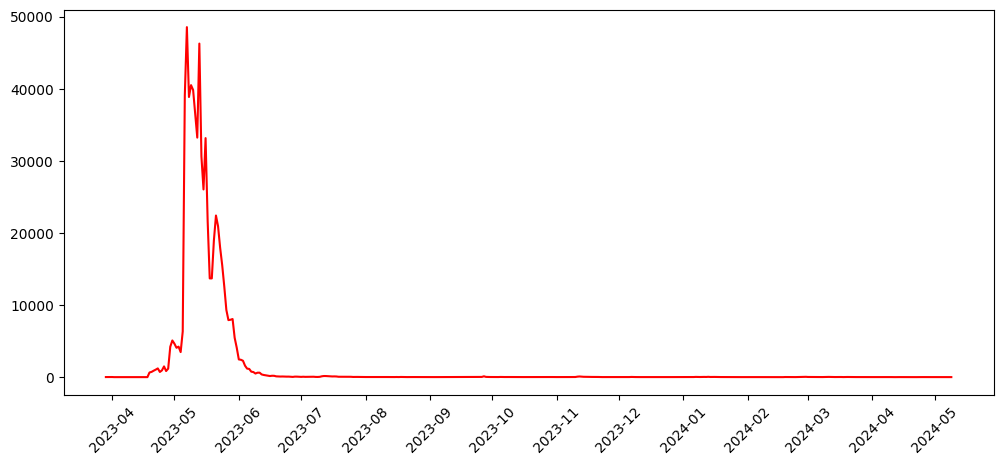

In [6]:
# Convert period_d to datetime for plotting
period_d_dt = pd.to_datetime(accounts_day['period_d'])

plt.figure(figsize=(12,5))
plt.plot(period_d_dt, accounts_day['id'], color='red')

# Set xticks at the start of each month
month_starts = period_d_dt[period_d_dt.dt.is_month_start].drop_duplicates()
plt.xticks(ticks=month_starts, labels=month_starts.dt.strftime('%Y-%m'), rotation=45)

plt.show()

In [ ]:
# Convert period_d to datetime for plotting
period_d_dt = pd.to_datetime(accounts_day['period_d'])

plt.figure(figsize=(12,5))
plt.plot(period_d_dt, accounts_day['id'], color='red')

# Set xticks at the start of each month
month_starts = period_d_dt[period_d_dt.dt.is_month_start].drop_duplicates()
plt.xticks(ticks=month_starts, labels=month_starts.dt.strftime('%Y-%m'), rotation=45)

plt.show()

SyntaxError: positional argument follows keyword argument (4129910871.py, line 5)

In [7]:
accounts_user['period_m'] = accounts_user['created_at'].dt.to_period('M')

In [12]:
month = accounts_user.groupby(['period_m'])[['id']].count().reset_index()

In [13]:
month['total'] = accounts_user['id'].count()

In [15]:
month['ratio'] = month['id'] / month['total']

In [ ]:
month # 2023ÎÖÑ 5ÏõîÏóê 93.85%Í∞Ä Í∞ÄÏûÖÌïòÏòÄÏäµÎãàÎã§

period_m      id   total     ratio
0   2023-03      33  677085  0.000049
1   2023-04   19060  677085  0.028150
2   2023-05  635505  677085  0.938590
3   2023-06   16737  677085  0.024719
4   2023-07    1849  677085  0.002731
5   2023-08     524  677085  0.000774
6   2023-09     605  677085  0.000894
7   2023-10     409  677085  0.000604
8   2023-11     731  677085  0.001080
9   2023-12     231  677085  0.000341
10  2024-01     455  677085  0.000672
11  2024-02     255  677085  0.000377
12  2024-03     446  677085  0.000659
13  2024-04     196  677085  0.000289
14  2024-05      49  677085  0.000072

<Axes: xlabel='period_m'>

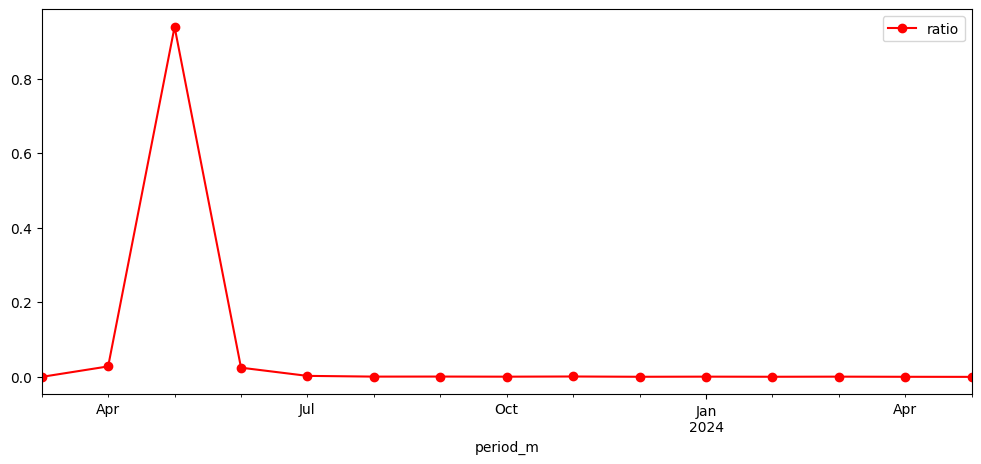

In [26]:
month.plot( x='period_m', y='ratio',figsize=(12, 5),marker = 'o', color='red')

In [80]:
user = accounts_user[['id','created_at']]

##### accounts_userquestionrecord

In [39]:
accounts_userquestionrecord = pd.read_parquet('gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet', engine='pyarrow')

In [ ]:
accounts_userquestionrecord

id status          created_at  chosen_user_id  question_id  \
0           771777      C 2023-04-28 12:27:49          849469          252   
1           771800      C 2023-04-28 12:28:02          849446          244   
2           771812      C 2023-04-28 12:28:09          849454          183   
3           771828      C 2023-04-28 12:28:16          847375          101   
4           771851      C 2023-04-28 12:28:26          849477          209   
...            ...    ...                 ...             ...          ...   
1217553  161666166      C 2024-05-07 11:29:07          945560         2614   
1217554  161666461      C 2024-05-08 01:34:56          850774         1679   
1217555  161666462      C 2024-05-08 01:35:02          855509         2605   
1217556  161666463      C 2024-05-08 01:36:00          855526         3801   
1217557  161666464      C 2024-05-08 01:36:18          874566         3117   

         user_id  question_piece_id  has_read answer_status  \
0         849436             998458         0             N   
1         849436             998459         0             N   
2         849436             998460         1             N   
3         849436             998461         0             N   
4         849436             998462         1             N   
...          ...                ...       ...           ...   
1217553  1001607          190864020         1             N   
1217554   855525          200139931         0             N   
1217555   855525          200139932         0             N   
1217556   855525          200139933         0             N   
1217557   855525          200139934         0             N   

          answer_updated_at  report_count  opened_times  
0       2023-04-28 12:27:49             0             0  
1       2023-04-28 12:28:02             0             0  
2       2023-04-28 12:28:09             0             0  
3       2023-04-28 12:28:16             0             0  
4       2023-04-28 12:28:26             0             0  
...                     ...           ...           ...  
1217553 2024-05-07 11:29:07             0             0  
1217554 2024-05-08 01:34:56             0             0  
1217555 2024-05-08 01:35:02             0             0  
1217556 2024-05-08 01:36:00             0             0  
1217557 2024-05-08 01:36:18             0             0  

[1217558 rows x 12 columns]

In [4]:
accounts_userquestionrecord.isnull().sum()

id                   0
status               0
created_at           0
chosen_user_id       0
question_id          0
user_id              0
question_piece_id    0
has_read             0
answer_status        0
answer_updated_at    0
report_count         0
opened_times         0
dtype: int64

In [ ]:
accounts_userquestionrecord.loc[(accounts_userquestionrecord['has_read']==1) & (accounts_userquestionrecord['answer_status']!='N')]

id status          created_at  chosen_user_id  question_id  \
345         778243      C 2023-04-28 13:14:34          849548          200   
1848        802848      C 2023-04-28 16:05:09          849548          166   
3097        815819      I 2023-04-28 23:31:19          849515          320   
10109       945319      I 2023-04-29 13:22:05          849995          132   
11512       989867      C 2023-04-29 15:20:38          849498          315   
...            ...    ...                 ...             ...          ...   
1182397  150784898      C 2023-06-07 15:41:57          887991         2356   
1182400  150785481      C 2023-06-07 15:42:37          887991         3822   
1182563  150825226      C 2023-06-07 16:41:50          869580         2285   
1182570  150825637      I 2023-06-07 16:42:40          887714         2357   
1182635  150841825      C 2023-06-07 17:42:25          994302         2207   

         user_id  question_piece_id  has_read answer_status  \
345       850006            1009125         1             P   
1848      850610            1043525         1             P   
3097      847375            1034711         1             P   
10109     851717            1213085         1             P   
11512     850180            1259999         1             A   
...          ...                ...       ...           ...   
1182397   883374          191553936         1             A   
1182400   883374          191553939         1             A   
1182563   877117          192477279         1             A   
1182570   869580          190234929         1             A   
1182635   887714          192583568         1             A   

          answer_updated_at  report_count  opened_times  
345     2023-05-06 16:49:33             0             0  
1848    2023-05-06 16:49:21             0             0  
3097    2023-05-06 10:09:27             0             1  
10109   2023-05-06 10:31:30             0             3  
11512   2023-05-12 15:33:47             0             0  
...                     ...           ...           ...  
1182397 2023-06-07 15:42:58             0             0  
1182400 2023-06-07 15:43:09             0             0  
1182563 2023-06-07 16:43:00             0             0  
1182570 2023-06-07 17:40:52             0             1  
1182635 2023-06-07 18:02:41             0             0  

[119626 rows x 12 columns]

In [40]:
accounts_userquestionrecord = accounts_userquestionrecord.sort_values(by='answer_updated_at')

In [41]:
accounts_userquestionrecord = accounts_userquestionrecord.drop_duplicates(subset=['user_id'], keep='last')[['user_id','answer_updated_at']].rename(columns={'answer_updated_at': 'created_at'})

##### accounts_userwithdraw

In [5]:
accounts_userwithdraw = pd.read_parquet('gs://sprintda05_final_project/votes/accounts_userwithdraw.parquet', engine='pyarrow')

In [6]:
accounts_userwithdraw

id        reason          created_at
0         42   Ïû¨Î∞åÎäî ÏßàÎ¨∏Ïù¥ ÏóÜÏñ¥ÏÑú 2023-03-29 13:22:12
1         43  Ìï®Íªò Ìï† ÏπúÍµ¨Í∞Ä ÏóÜÏñ¥ÏÑú 2023-03-29 13:24:59
2         44  Ìï®Íªò Ìï† ÏπúÍµ¨Í∞Ä ÏóÜÏñ¥ÏÑú 2023-03-29 13:53:32
3         45  Ìï®Íªò Ìï† ÏπúÍµ¨Í∞Ä ÏóÜÏñ¥ÏÑú 2023-03-29 13:54:03
4         46   Ïû¨Î∞åÎäî ÏßàÎ¨∏Ïù¥ ÏóÜÏñ¥ÏÑú 2023-03-30 00:31:19
...      ...           ...                 ...
70759  70889         Í∏∞ÌÉÄ Ïù¥Ïú† 2024-05-08 14:24:16
70760  70890  Ìï®Íªò Ìï† ÏπúÍµ¨Í∞Ä ÏóÜÏñ¥ÏÑú 2024-05-08 15:20:06
70761  70891   Ïû¨Î∞åÎäî ÏßàÎ¨∏Ïù¥ ÏóÜÏñ¥ÏÑú 2024-05-08 15:46:36
70762  70892         Í∏∞ÌÉÄ Ïù¥Ïú† 2024-05-09 08:29:09
70763  70893         Í∏∞ÌÉÄ Ïù¥Ïú† 2024-05-09 08:49:06

[70764 rows x 3 columns]

In [7]:
accounts_userwithdraw.isnull().sum()

id            0
reason        0
created_at    0
dtype: int64

##### event_receipts

In [42]:
event_receipts = pd.read_parquet('gs://sprintda05_final_project/votes/event_receipts.parquet', engine='pyarrow')

In [ ]:
event_receipts.sort_values(by='created_at', ascending=False)

id          created_at  event_id  user_id  plus_point
308  321 2023-11-21 12:03:02         3  1568685         500
307  320 2023-11-17 06:17:59         3  1296978         500
306  319 2023-11-17 06:17:25         3  1188104         500
305  318 2023-11-15 05:09:02         3   932419         500
304  317 2023-11-14 11:17:29         3   918053         500
..   ...                 ...       ...      ...         ...
4      6 2023-06-22 13:40:38         1  1168260         500
3      5 2023-06-22 13:03:06         1   974697         500
2      4 2023-06-22 10:32:15         1   904872         500
1      3 2023-06-22 09:38:53         1   928351         500
0      2 2023-06-22 09:25:16         1  1193618         500

[309 rows x 5 columns]

In [10]:
event_receipts.isnull().sum()

id            0
created_at    0
event_id      0
user_id       0
plus_point    0
dtype: int64

In [19]:
event_receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          309 non-null    int64         
 1   created_at  309 non-null    datetime64[ns]
 2   event_id    309 non-null    int64         
 3   user_id     309 non-null    int64         
 4   plus_point  309 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 12.2 KB


In [30]:
event_receipts['plus_point'].unique()

array([ 500, 1000])

In [ ]:
event_plus_point = event_receipts.groupby(['user_id'])[['plus_point']].sum().sort_values(by='plus_point', ascending=False).reset_index()

user_id  plus_point
0     837836        1000
1    1541150        1000
2    1115176        1000
3    1107696        1000
4    1512731        1000
..       ...         ...
303  1062030         500
304  1061829         500
305  1056997         500
306  1056664         500
307  1579064         500

[308 rows x 2 columns]

In [44]:
event_receipts = event_receipts.sort_values(by='created_at')

In [45]:
event_receipts = event_receipts.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### events

In [11]:
events = pd.read_parquet('gs://sprintda05_final_project/votes/events.parquet', engine='pyarrow')

In [12]:
events

id           title  plus_point event_type  is_expired          created_at
0   1   ÏΩîÎìúÏûá ÏùÄÌñâ Í∞ÄÏûÖ Ïù¥Î≤§Ìä∏         500       FCFS           1 2023-06-20 11:56:38
1   2  ÏΩîÎìúÏûá Î©§Î≤ÑÏã≠ Í∞ÄÏûÖ Ïù¥Î≤§Ìä∏        1000       FCFS           1 2023-08-08 07:43:45
2   3   ÏòàÍ≥† ÏòÅÏÉÅ Í∏∞ÎåÄÌèâ Ïù¥Î≤§Ìä∏         500       FCFS           1 2023-09-24 17:05:59

In [13]:
events.isnull().sum()

id            0
title         0
plus_point    0
event_type    0
is_expired    0
created_at    0
dtype: int64

##### polls_question

In [46]:
polls_question = pd.read_parquet('gs://sprintda05_final_project/votes/polls_question.parquet', engine='pyarrow')

In [52]:
polls_question

id                           question_text          created_at
0       99                      Í∞ÄÏû• Ïã†ÎπÑÌïú Îß§Î†•Ïù¥ ÏûàÎäî ÏÇ¨ÎûåÏùÄ? 2023-03-31 15:22:53
1      100            "Ïù¥ ÏÇ¨ÎûåÏúºÎ°ú Ìïú Î≤à ÏÇ¥ÏïÑÎ≥¥Í≥† Ïã∂Îã§" ÌïòÎäî ÏÇ¨ÎûåÏùÄ? 2023-03-31 15:22:53
2      101                               ÎØ∏ÎûòÏùò Ìã±ÌÜ°Ïª§Îäî? 2023-03-31 15:22:54
3      102                         Ïó¨Í∏∞ÏÑú Ï†úÏùº ÌäπÏù¥Ìïú ÏπúÍµ¨Îäî? 2023-03-31 15:22:54
4      103                         Í∞ÄÏû• ÏßÄÏºúÏ£ºÍ≥† Ïã∂ÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-03-31 15:22:55
...    ...                                     ...                 ...
5020  5129                         ÎÇòÏóêÍ≤å Í∞ÄÏû• Ï§ëÏöîÌïú ÏÇ¨ÎûåÏùÄ? 2023-06-06 06:15:52
5021  5130                    Ïò§Î™©ÏùÑ Ï†úÏùº Ïûò Ìï† Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-06-06 06:15:52
5022  5131                Í∞ÄÎ∞©ÏóêÏÑú Ïì∞Î†àÍ∏∞Í∞Ä Ïïà ÎÇòÏò¨ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-06-06 06:15:52
5023  5132  ÏïÑÎ¨¥Î¶¨ ÎßéÏùÄ ÏàôÏ†úÎèÑ 30Î∂ÑÎßåÏóê Îã§ ÎÅùÎÇ¥Î≤ÑÎ¶¥ Ïàò ÏûàÏùÑ Í≤É Í∞ôÏùÄ ÏπúÍµ¨Îäî? 2023-06-06 06:15:52
5024  5133                  Îü¨Î∏åÎ†àÌÑ∞Î•º Í∞ÄÏû• Ïûò Ïì∏ Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-06-06 06:15:52

[5025 rows x 3 columns]

In [16]:
polls_question.isnull().sum()

id               0
question_text    0
created_at       0
dtype: int64

In [30]:
hour = polls_question['created_at'].dt.hour

In [35]:
polls_question.loc[polls_question['created_at'].dt.hour == 3]

id                       question_text          created_at
462  561  ÏñòÎûë ÏπúÌï¥ÏßÄÎ©¥ ÏÑ∏ÏÉÅ Î™®ÎëêÎûë ÏπúÌï¥Ïßà Ïàò ÏûàÏùÑ Í≤É Í∞ôÏïòÎçò ÏÇ¨ÎûåÏùÄ? 2023-05-04 03:36:37

In [38]:
hour.value_counts()

created_at
6     1966
8     1523
14     732
13     250
5      235
15     164
11     154
3        1
Name: count, dtype: int64

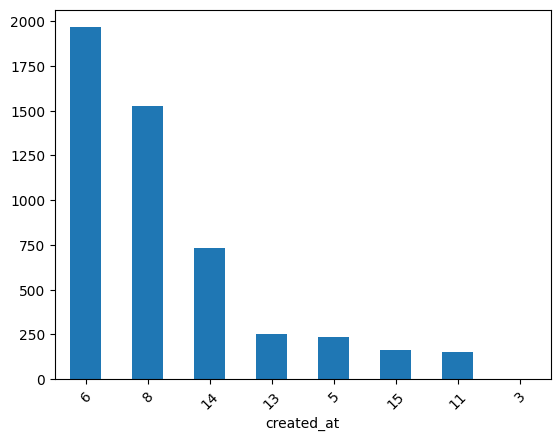

In [ ]:
hour.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

In [60]:
polls_question.loc[polls_question['id'].isin([170,169,186,211,290])]

id                  question_text          created_at
70   169       Ï∂ïÏ†úÏóêÏÑú Í≥µÏó∞ÏùÑ Ï†úÏùº Ïûò Ìï†Í±∞ Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-03-31 15:23:29
71   170  Ï≤òÏùå Î≥¥Îäî ÏÇ¨ÎûåÍ≥º Í∞ÄÏû• Îπ®Î¶¨ ÏπúÌï¥Ïßà Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-03-31 15:23:30
87   186                           vote 2023-04-01 11:09:15
112  211    ÏïûÏúºÎ°úÏùò Ïù∏ÏÉùÏùÑ Í∞ÄÏû• Ïû¨ÎØ∏ÏûàÍ≤å ÏÇ¥Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-04-01 11:09:20
191  290          Î™®Îì† ÏÇ¨ÎûåÍ≥º Ïûò ÏßÄÎÇº Í≤É Í∞ôÏùÄ ÏÇ¨ÎûåÏùÄ? 2023-04-01 11:09:35

In [30]:
polls_question.loc[polls_question['id']==111]

id     question_text          created_at
12  111  ÎßàÏä§ÌÅ¨Í∞Ä Ïûò Ïñ¥Ïö∏Î¶¨Îäî ÏÇ¨ÎûåÏùÄ? 2023-03-31 15:22:59

In [26]:
df = pd.merge(polls_question,report,how='left',on='id')

In [36]:
df1 = df[df['question_text'].str.contains('vote',case=False)]

In [74]:
df2 = pd.merge(df1,piece_count,how='left',on='id') 
df2

id question_text          created_at  count  count1
0    186          vote 2023-04-01 11:09:15   45.0  1991.0
1    483          vote 2023-05-02 05:33:11   73.0  1615.0
2    639          vote 2023-05-11 15:52:44   16.0   580.0
3    696          vote 2023-05-15 13:58:24   34.0   411.0
4    712          vote 2023-05-15 13:58:30   15.0   381.0
5    725          vote 2023-05-15 13:58:35    7.0   392.0
6    736          vote 2023-05-15 13:58:40   32.0   358.0
7    807          vote 2023-05-15 13:59:11   34.0   357.0
8    881          vote 2023-05-15 13:59:44   39.0   365.0
9    940          vote 2023-05-15 14:00:10   20.0   333.0
10   946          vote 2023-05-15 14:00:13   15.0   342.0
11  1139          vote 2023-05-15 14:01:32   32.0   388.0
12  1219          vote 2023-05-15 14:02:03    4.0   411.0
13  1232          vote 2023-05-15 14:02:08   36.0   366.0
14  1320          vote 2023-05-15 14:02:46   21.0   398.0
15  1507          vote 2023-05-15 14:04:02   13.0   348.0
16  1591          vote 2023-05-15 14:04:35    8.0   376.0
17  1651          vote 2023-06-02 08:06:23    NaN    39.0
18  1652          vote 2023-06-02 08:06:23    2.0    37.0
19  1653          vote 2023-06-02 08:06:23    2.0    46.0
20  1654          vote 2023-06-02 08:06:23    3.0    32.0
21  1655          vote 2023-06-02 08:06:23    2.0    21.0
22  1656          vote 2023-06-02 08:06:23    NaN    43.0
23  1657          vote 2023-06-02 08:06:23    4.0    29.0
24  1658          vote 2023-06-02 08:06:23    3.0    40.0
25  1747          vote 2023-06-02 08:06:26    2.0    38.0
26  1749          vote 2023-06-02 08:06:26    NaN    31.0
27  2129          vote 2023-06-02 08:06:37    4.0    33.0
28  2246          vote 2023-06-02 08:06:41    1.0    51.0
29  2565          vote 2023-06-02 08:06:51    NaN    36.0
30  2843          vote 2023-06-02 08:07:00    1.0    38.0
31  2916          vote 2023-06-02 08:07:02    1.0    33.0
32  3200          vote 2023-06-06 06:10:05    1.0    16.0
33  3216          vote 2023-06-06 06:10:05    1.0    15.0
34  3314          vote 2023-06-06 06:10:06    2.0    22.0
35  3353          vote 2023-06-06 06:10:07    NaN    14.0
36  3367          vote 2023-06-06 06:10:07    1.0    21.0
37  3447          vote 2023-06-06 06:10:08    NaN    14.0
38  3564          vote 2023-06-06 06:10:10    1.0    15.0
39  3566          vote 2023-06-06 06:10:10    1.0    14.0
40  3695          vote 2023-06-06 06:10:11    NaN    14.0
41  3913          vote 2023-06-06 06:10:14    NaN    16.0
42  3915          vote 2023-06-06 06:10:14    3.0    16.0
43  4033          vote 2023-06-06 06:10:16    6.0    10.0
44  4183          vote 2023-06-06 06:15:39    NaN     NaN
45  4199          vote 2023-06-06 06:15:39    NaN     2.0
46  4297          vote 2023-06-06 06:15:41    NaN     1.0
47  4336          vote 2023-06-06 06:15:41    1.0     1.0
48  4350          vote 2023-06-06 06:15:41    NaN     1.0
49  4430          vote 2023-06-06 06:15:42    NaN     2.0
50  4547          vote 2023-06-06 06:15:44    NaN     4.0
51  4549          vote 2023-06-06 06:15:44    NaN     2.0
52  4678          vote 2023-06-06 06:15:46    NaN     1.0
53  4896          vote 2023-06-06 06:15:49    NaN     1.0
54  4898          vote 2023-06-06 06:15:49    NaN     3.0
55  5016          vote 2023-06-06 06:15:50    NaN     5.0

In [81]:
vote_text = df2['id'].to_list()

In [28]:
polls_question[polls_question['question_text'].str.contains('vote', case=False)].head(5)

id question_text          created_at
87   186          vote 2023-04-01 11:09:15
384  483          vote 2023-05-02 05:33:11
540  639          vote 2023-05-11 15:52:44
587  696          vote 2023-05-15 13:58:24
603  712          vote 2023-05-15 13:58:30

##### polls_questionpiece

In [47]:
polls_questionpiece = pd.read_parquet('gs://sprintda05_final_project/votes/polls_questionpiece.parquet', engine='pyarrow')

In [15]:
polls_questionpiece

id  is_voted          created_at  question_id  is_skipped
0           998458         1 2023-04-28 12:27:22          252           0
1           998459         1 2023-04-28 12:27:22          244           0
2           998460         1 2023-04-28 12:27:22          183           0
3           998461         1 2023-04-28 12:27:22          101           0
4           998462         1 2023-04-28 12:27:22          209           0
...            ...       ...                 ...          ...         ...
1265471  208385226         0 2024-05-07 11:32:30          960           0
1265472  208385227         0 2024-05-07 11:32:30         1402           0
1265473  208385228         0 2024-05-07 11:32:30         1676           0
1265474  208385229         0 2024-05-07 11:32:30         3115           0
1265475  208385230         0 2024-05-07 11:32:30         1461           0

[1265476 rows x 5 columns]

In [13]:
piece_count = polls_questionpiece.groupby(['question_id'])[['id']].count().sort_values(by='id',ascending=False).reset_index().rename(columns={'id' : 'count1','question_id': 'id'})

In [ ]:
piece_count

id  count1
0      170    2030
1      290    2021
2      169    2017
3      211    2009
4      186    1991
...    ...     ...
4939  4926       1
4940  4556       1
4941  4551       1
4942  4931       1
4943  4287       1

[4944 rows x 2 columns]

In [51]:
piece_count.describe()

id       count1
count  4944.000000  4944.000000
mean   2587.901699   255.961974
std    1441.905349   478.950128
min      99.000000     1.000000
25%    1344.750000    14.000000
50%    2580.500000    33.000000
75%    3816.250000   355.000000
max    5133.000000  2030.000000

In [87]:
vote_questionpiece = polls_questionpiece.loc[polls_questionpiece['question_id'].isin(vote_text),'id'].to_list()

In [12]:
questionpiece_voted = polls_questionpiece.groupby(['question_id'])[['is_voted']].sum().sort_values(by='is_voted',ascending=False).reset_index().rename(columns={'is_voted': 'count2','question_id': 'id'})

In [17]:
piece_voted_count = pd.merge(piece_count,questionpiece_voted,how='left',on='id').sort_values(by='count1',ascending=False)

In [19]:
piece_voted_count['ratio'] = piece_voted_count['count2'] / piece_voted_count['count1']

In [25]:
piece_voted_count.describe()

id       count1       count2        ratio
count  4944.000000  4944.000000  4944.000000  4944.000000
mean   2587.901699   255.961974   246.498180     0.801884
std    1441.905349   478.950128   470.798358     0.208031
min      99.000000     1.000000     0.000000     0.000000
25%    1344.750000    14.000000    10.000000     0.729730
50%    2580.500000    33.000000    27.000000     0.837838
75%    3816.250000   355.000000   340.000000     0.963418
max    5133.000000  2030.000000  1998.000000     1.000000

##### polls_questionreport

In [48]:
polls_questionreport = pd.read_parquet('gs://sprintda05_final_project/votes/polls_questionreport.parquet', engine='pyarrow')

In [ ]:
polls_questionreport

id                reason          created_at  question_id  user_id
0          1           Ïù¥ ÏßàÎ¨∏ÏùÄ Ïû¨ÎØ∏ÏóÜÏñ¥Ïöî 2023-04-19 06:20:35          250   837556
1          2           Ïù¥ ÏßàÎ¨∏ÏùÄ Ïû¨ÎØ∏ÏóÜÏñ¥Ïöî 2023-04-19 06:58:09          113   837672
2          3       Î∂àÏæåÌïú ÎÇ¥Ïö©Ïù¥ Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏùå 2023-04-19 06:58:17          113   837672
3          4  Ïñ¥ÎñªÍ≤å Ïù¥Îü∞ ÏÉùÍ∞ÅÏùÑ? Ïù¥ ÏßàÎ¨∏ ÏµúÍ≥†! 2023-04-19 08:12:42          119   837922
4          5  Ïñ¥ÎñªÍ≤å Ïù¥Îü∞ ÏÉùÍ∞ÅÏùÑ? Ïù¥ ÏßàÎ¨∏ ÏµúÍ≥†! 2023-04-19 08:12:50          119   837922
...      ...                   ...                 ...          ...      ...
51419  55763                 Í∑∏ÎÉ• Ïã´Ïñ¥ 2024-04-19 12:49:57          350  1542237
51420  55764                 Í∑∏ÎÉ• Ïã´Ïñ¥ 2024-04-19 12:50:02         3541  1542237
51421  55765                 Í∑∏ÎÉ• Ïã´Ïñ¥ 2024-04-28 06:35:38          392   984791
51422  55766                 Í∑∏ÎÉ• Ïã´Ïñ¥ 2024-04-30 04:48:25         4979  1583634
51423  55767                 Í∑∏ÎÉ• Ïã´Ïñ¥ 2024-05-05 14:56:25         3438  1397426

[51424 rows x 5 columns]

In [65]:
polls_questionreport.groupby(['question_id'])[['id']].count().reset_index().rename(columns={'id': 'count'}).sort_values(by='count', ascending=False)

question_id  count
12            111    988
311           410    803
299           398    660
325           424    533
206           305    493
...           ...    ...
2439         2980      1
1801         2019      1
2441         2983      1
2443         2986      1
1714         1902      1

[3135 rows x 2 columns]

In [ ]:
polls_questionreport.loc[polls_questionreport['question_id']==111]

In [60]:
report = polls_questionreport.groupby(['question_id'])[['id']].count().reset_index().rename(columns={'id' : 'count', 'question_id': 'id'}).sort_values(by='count',ascending=False)

In [64]:
report.head(5) 

id  count
12   111    988
311  410    803
299  398    660
325  424    533
206  305    493

In [ ]:
report.describe()

id        count
count  3135.000000  3135.000000
mean   1921.597448    16.403190
std    1231.248878    38.455215
min      99.000000     1.000000
25%     892.500000     1.000000
50%    1682.000000     4.000000
75%    2849.000000    19.000000
max    5110.000000   988.000000

In [49]:
polls_questionreport = polls_questionreport.sort_values(by='created_at')

In [50]:
polls_questionreport = polls_questionreport.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### polls_questionset

In [51]:
polls_questionset = pd.read_parquet('gs://sprintda05_final_project/votes/polls_questionset.parquet', engine='pyarrow')

In [68]:
polls_questionset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158384 entries, 0 to 158383
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      158384 non-null  int64         
 1   question_piece_id_list  158384 non-null  object        
 2   opening_time            158384 non-null  datetime64[ns]
 3   status                  158384 non-null  object        
 4   created_at              158384 non-null  datetime64[ns]
 5   user_id                 158384 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 7.3+ MB


In [21]:
polls_questionset

id                             question_piece_id_list  \
0          99817  [998458, 998459, 998460, 998461, 998462, 99846...   
1          99830  [998588, 998589, 998590, 998591, 998592, 99859...   
2          99840  [998689, 998691, 998693, 998695, 998697, 99869...   
3          99841  [998688, 998690, 998692, 998694, 998696, 99869...   
4          99848  [998768, 998769, 998770, 998771, 998772, 99877...   
...          ...                                                ...   
158379  20838253  [208383291, 208383292, 208383293, 208383294, 2...   
158380  20838344  [208384201, 208384202, 208384203, 208384204, 2...   
158381  20838419  [208384951, 208384952, 208384953, 208384954, 2...   
158382  20838445  [208385211, 208385212, 208385213, 208385214, 2...   
158383  20838446  [208385221, 208385222, 208385223, 208385224, 2...   

              opening_time status          created_at  user_id  
0      2023-04-28 12:27:22      F 2023-04-28 12:27:23   849436  
1      2023-04-28 12:28:07      F 2023-04-28 12:28:07   849438  
2      2023-04-28 12:28:38      F 2023-04-28 12:28:38   847375  
3      2023-04-28 12:28:38      F 2023-04-28 12:28:38   849446  
4      2023-04-28 12:28:57      F 2023-04-28 12:28:57   849477  
...                    ...    ...                 ...      ...  
158379 2024-05-05 14:46:27      C 2024-05-05 14:06:27  1251933  
158380 2024-05-06 11:38:20      C 2024-05-06 10:58:20   876072  
158381 2024-05-07 00:55:00      C 2024-05-07 00:15:00  1208878  
158382 2024-05-07 12:09:08      C 2024-05-07 11:29:08  1001607  
158383 2024-05-07 12:12:30      C 2024-05-07 11:32:30   945560  

[158384 rows x 6 columns]

In [55]:
polls_questionset['question_piece_id_list'] =  polls_questionset['question_piece_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [56]:
explode_questionset = polls_questionset.explode('question_piece_id_list')

In [ ]:
polls_questionset  = polls_questionset.explode('question_piece_id_list')

In [58]:
explode_questionset

id question_piece_id_list        opening_time status  \
0          99817                 998458 2023-04-28 12:27:22      F   
0          99817                 998459 2023-04-28 12:27:22      F   
0          99817                 998460 2023-04-28 12:27:22      F   
0          99817                 998461 2023-04-28 12:27:22      F   
0          99817                 998462 2023-04-28 12:27:22      F   
...          ...                    ...                 ...    ...   
158383  20838446              208385226 2024-05-07 12:12:30      C   
158383  20838446              208385227 2024-05-07 12:12:30      C   
158383  20838446              208385228 2024-05-07 12:12:30      C   
158383  20838446              208385229 2024-05-07 12:12:30      C   
158383  20838446              208385230 2024-05-07 12:12:30      C   

                created_at  user_id  
0      2023-04-28 12:27:23   849436  
0      2023-04-28 12:27:23   849436  
0      2023-04-28 12:27:23   849436  
0      2023-04-28 12:27:23   849436  
0      2023-04-28 12:27:23   849436  
...                    ...      ...  
158383 2024-05-07 11:32:30   945560  
158383 2024-05-07 11:32:30   945560  
158383 2024-05-07 11:32:30   945560  
158383 2024-05-07 11:32:30   945560  
158383 2024-05-07 11:32:30   945560  

[1583840 rows x 6 columns]

In [88]:
# textÍ∞Ä voteÏù∏ ÏßàÎ¨∏ÏùÑ ÏÇ¨Ïö©Ìïú Ïú†Ï†Ä
explode_questionset.loc[explode_questionset['question_piece_id_list'].isin(vote_questionpiece)]

id question_piece_id_list        opening_time status  \
11         99877                 999061 2023-04-28 12:30:30      F   
47        100144                1001728 2023-04-28 13:27:10      F   
82        100659                1006883 2023-04-28 13:49:51      F   
102       100956                1009852 2023-04-28 14:05:03      F   
179       101876                1019049 2023-04-28 13:57:38      F   
...          ...                    ...                 ...    ...   
158367  20834940              208350163 2024-03-17 09:05:21      O   
158368  20835030              208351069 2024-03-18 15:35:54      C   
158375  20836712              208367887 2024-04-18 03:03:30      O   
158379  20838253              208383297 2024-05-05 14:46:27      C   
158381  20838419              208384960 2024-05-07 00:55:00      C   

                created_at  user_id  
11     2023-04-28 12:30:30   849452  
47     2023-04-28 12:37:10   849446  
82     2023-04-28 12:59:52   849464  
102    2023-04-28 13:15:03   850006  
179    2023-04-28 13:57:38   849535  
...                    ...      ...  
158367 2024-03-17 08:25:21  1165963  
158368 2024-03-18 14:55:54  1260879  
158375 2024-04-18 02:23:30  1087583  
158379 2024-05-05 14:06:27  1251933  
158381 2024-05-07 00:15:00  1208878  

[10169 rows x 6 columns]

In [ ]:
questionset = polls_questionset.groupby(['user_id'])[['id']].count().sort_values(by='id', ascending=False).reset_index()
questionset

user_id   id
0      952220  370
1      849103  286
2     1184703  215
3     1162477  203
4     1213990  202
...       ...  ...
4967  1500850    1
4968   899404    1
4969   872546    1
4970   872930    1
4971  1533302    1

[4972 rows x 2 columns]

In [24]:
conversion = pd.merge(payment,questionset,how='left',on='user_id')
conversion

user_id  id_x  id_y
0      1527451    60   NaN
1      1246471    51   NaN
2      1141603    35   NaN
3      1204373    34   NaN
4      1142775    30   NaN
...        ...   ...   ...
59187  1196164     1   NaN
59188  1196170     1   NaN
59189  1196185     1   NaN
59190  1196197     1   NaN
59191  1583632     1   NaN

[59192 rows x 3 columns]

In [10]:
all_users = set(accounts_user['id'].unique())
payment_users = set(accounts_paymenthistory['user_id'].unique())
questionset_users = set(polls_questionset['user_id'].unique())

In [14]:
payment_in_users = payment_users.intersection(all_users)
questionset_in_users = questionset_users.intersection(all_users)
both_users = payment_users.intersection(questionset_users)

In [16]:
print(len(payment_in_users),len(questionset_in_users),len(both_users))

59192 4972 410


In [17]:
data = {'Í≤∞Ï†úÏûê' : len(payment_in_users), 
       'ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏûëÏÑ±Ïûê' : len(questionset_in_users), 
       'Îëò Îã§ ÏûëÏÑ±Ìïú Ïú†Ï†Ä' : len(both_users)}

In [9]:
print("üîç ÏÇ¨Ïö©Ïûê ID Í∏∞Î∞ò Ï†ïÌôïÌïú Ï†ÑÌôòÏú® Î∂ÑÏÑù")
print("=" * 50)

print("üìä **Step 1: Í∞Å Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏÇ¨Ïö©Ïûê ID ÌôïÏù∏**")

# Í∞Å Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏÇ¨Ïö©Ïûê ID ÌÉÄÏûÖÍ≥º Î∂ÑÌè¨ ÌôïÏù∏
print(f"‚Ä¢ df_user['id'] ÌÉÄÏûÖ: {accounts_user['id'].dtype}")
print(f"‚Ä¢ df_payment['user_id'] ÌÉÄÏûÖ: {accounts_paymenthistory['user_id'].dtype}")  
print(f"‚Ä¢ df_questionset['user_id'] ÌÉÄÏûÖ: {polls_questionset['user_id'].dtype}")

print(f"\n‚Ä¢ df_user ID Î≤îÏúÑ: {accounts_user['id'].min()} ~ {accounts_user['id'].max()}")
print(f"‚Ä¢ df_payment user_id Î≤îÏúÑ: {accounts_paymenthistory['user_id'].min()} ~ {accounts_paymenthistory['user_id'].max()}")
print(f"‚Ä¢ df_questionset user_id Î≤îÏúÑ: {polls_questionset['user_id'].min()} ~ {polls_questionset['user_id'].max()}")

# Ïã§Ï†ú ÏÇ¨Ïö©Ïûê ÏßëÌï© Ï†ïÏùò
all_users = set(accounts_user['id'].unique())
payment_users = set(accounts_paymenthistory['user_id'].unique())
questionset_users = set(polls_questionset['user_id'].unique())

print(f"\nüìã **Step 2: ÏÇ¨Ïö©Ïûê ÏßëÌï© Ïû¨ÌôïÏù∏**")
print(f"‚Ä¢ Ï†ÑÏ≤¥ Îì±Î°ù ÏÇ¨Ïö©Ïûê: {len(all_users):,}Î™Ö")
print(f"‚Ä¢ Í≤∞Ï†úÌïú ÏÇ¨Ïö©Ïûê: {len(payment_users):,}Î™Ö")
print(f"‚Ä¢ ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©Ìïú ÏÇ¨Ïö©Ïûê: {len(questionset_users):,}Î™Ö")

# ÍµêÏßëÌï© ÌôïÏù∏
payment_in_users = payment_users.intersection(all_users)
questionset_in_users = questionset_users.intersection(all_users)
both_users = payment_users.intersection(questionset_users)

print(f"\nüîç **Step 3: ÍµêÏßëÌï© Î∂ÑÏÑù**")
print(f"‚Ä¢ Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê Ï§ë Í≤∞Ï†úÌïú ÏÇ¨Ïö©Ïûê: {len(payment_in_users):,}Î™Ö")
print(f"‚Ä¢ Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê Ï§ë ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©Ìïú ÏÇ¨Ïö©Ïûê: {len(questionset_in_users):,}Î™Ö")
print(f"‚Ä¢ Í≤∞Ï†úÎèÑ ÌïòÍ≥† ÏßàÎ¨∏ÏÑ∏Ìä∏ÎèÑ ÏÇ¨Ïö©Ìïú ÏÇ¨Ïö©Ïûê: {len(both_users):,}Î™Ö")

# ÏÇ¨Ïö©ÏûêÍ∞Ä Ïã§Ï†úÎ°ú Ï°¥Ïû¨ÌïòÎäîÏßÄ ÌôïÏù∏
print(f"\nüîé **Step 4: ÏÇ¨Ïö©Ïûê Ï°¥Ïû¨ Ïó¨Î∂Ä ÌôïÏù∏**")
payment_not_in_users = payment_users - all_users
questionset_not_in_users = questionset_users - all_users

print(f"‚Ä¢ Í≤∞Ï†úÌñàÏßÄÎßå ÏÇ¨Ïö©Ïûê ÌÖåÏù¥Î∏îÏóê ÏóÜÎäî ID: {len(payment_not_in_users):,}Í∞ú")
print(f"‚Ä¢ ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©ÌñàÏßÄÎßå ÏÇ¨Ïö©Ïûê ÌÖåÏù¥Î∏îÏóê ÏóÜÎäî ID: {len(questionset_not_in_users):,}Í∞ú")

if len(payment_not_in_users) > 0:
    print(f"  ÏòàÏãú: {list(payment_not_in_users)[:5]}")
if len(questionset_not_in_users) > 0:
    print(f"  ÏòàÏãú: {list(questionset_not_in_users)[:5]}")

# Ïò¨Î∞îÎ•∏ Ï†ÑÌôòÏú® Í≥ÑÏÇ∞
print(f"\n‚úÖ **Step 5: Ïò¨Î∞îÎ•∏ Ï†ÑÌôòÏú® Í≥ÑÏÇ∞**")

# 1. Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê Ï§ë Í≤∞Ï†ú Ï†ÑÌôòÏú®
basic_conversion = len(payment_in_users) / len(all_users) * 100
print(f"‚Ä¢ Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê ‚Üí Í≤∞Ï†ú Ï†ÑÌôòÏú®: {basic_conversion:.2f}% ({len(payment_in_users):,}/{len(all_users):,})")

# 2. ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©Ïûê Ï§ë Í≤∞Ï†ú Ï†ÑÌôòÏú®  
if len(questionset_in_users) > 0:
    questionset_to_payment = len(both_users) / len(questionset_in_users) * 100
    print(f"‚Ä¢ ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©Ïûê ‚Üí Í≤∞Ï†ú Ï†ÑÌôòÏú®: {questionset_to_payment:.2f}% ({len(both_users):,}/{len(questionset_in_users):,})")

# 3. Í≤∞Ï†ú ÏÇ¨Ïö©Ïûê Ï§ë ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©Î•†
if len(payment_in_users) > 0:
    payment_to_questionset = len(both_users) / len(payment_in_users) * 100
    print(f"‚Ä¢ Í≤∞Ï†ú ÏÇ¨Ïö©Ïûê Ï§ë ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©Î•†: {payment_to_questionset:.2f}% ({len(both_users):,}/{len(payment_in_users):,})")

# ÏÇ¨Ïö©Ïûê ÌñâÎèô Ìå®ÌÑ¥ Î∂ÑÏÑù
print(f"\nüéØ **ÏÇ¨Ïö©Ïûê ÌñâÎèô Ìå®ÌÑ¥**")
payment_only = payment_users - questionset_users
questionset_only = questionset_users - payment_users

print(f"‚Ä¢ Í≤∞Ï†úÎßå ÌïòÎäî ÏÇ¨Ïö©Ïûê: {len(payment_only):,}Î™Ö ({len(payment_only)/len(payment_users)*100:.1f}%)")
print(f"‚Ä¢ ÏßàÎ¨∏ÏÑ∏Ìä∏Îßå ÏÇ¨Ïö©ÌïòÎäî ÏÇ¨Ïö©Ïûê: {len(questionset_only):,}Î™Ö ({len(questionset_only)/len(questionset_users)*100:.1f}%)")
print(f"‚Ä¢ Îëò Îã§ ÌïòÎäî ÏÇ¨Ïö©Ïûê: {len(both_users):,}Î™Ö")

print(f"\nüìä **Í≤∞Î°†**:")
if len(payment_only) > len(both_users) * 10:
    print(f"‚Ä¢ ÏßàÎ¨∏ÏÑ∏Ìä∏Îäî ÏµúÍ∑º Ï∂îÍ∞ÄÎêú Í∏∞Îä•ÏúºÎ°ú Î≥¥ÏûÑ")
    print(f"‚Ä¢ Í∏∞Ï°¥ Í≤∞Ï†ú ÏÇ¨Ïö©ÏûêÎì§ÏùÄ Îã§Î•∏ Í∏∞Îä•ÏùÑ Ï£ºÎ°ú ÏÇ¨Ïö©")
    print(f"‚Ä¢ ÏßàÎ¨∏ÏÑ∏Ìä∏ ‚Üí Í≤∞Ï†ú Ï†ÑÌôòÏú®: {questionset_to_payment:.1f}%Îäî ÏùòÎØ∏ÏûàÎäî ÏßÄÌëú")
else:
    print(f"‚Ä¢ ÏßàÎ¨∏ÏÑ∏Ìä∏ÏôÄ Í≤∞Ï†ú Í∏∞Îä•Ïù¥ Î∞ÄÏ†ëÌïòÍ≤å Ïó∞Í¥ÄÎê®")

üîç ÏÇ¨Ïö©Ïûê ID Í∏∞Î∞ò Ï†ïÌôïÌïú Ï†ÑÌôòÏú® Î∂ÑÏÑù
üìä **Step 1: Í∞Å Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏÇ¨Ïö©Ïûê ID ÌôïÏù∏**
‚Ä¢ df_user['id'] ÌÉÄÏûÖ: int64
‚Ä¢ df_payment['user_id'] ÌÉÄÏûÖ: int64
‚Ä¢ df_questionset['user_id'] ÌÉÄÏûÖ: int64

‚Ä¢ df_user ID Î≤îÏúÑ: 831956 ~ 1583733
‚Ä¢ df_payment user_id Î≤îÏúÑ: 833041 ~ 1583632
‚Ä¢ df_questionset user_id Î≤îÏúÑ: 838023 ~ 1583358

üìã **Step 2: ÏÇ¨Ïö©Ïûê ÏßëÌï© Ïû¨ÌôïÏù∏**
‚Ä¢ Ï†ÑÏ≤¥ Îì±Î°ù ÏÇ¨Ïö©Ïûê: 677,085Î™Ö
‚Ä¢ Í≤∞Ï†úÌïú ÏÇ¨Ïö©Ïûê: 59,192Î™Ö
‚Ä¢ ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©Ìïú ÏÇ¨Ïö©Ïûê: 4,972Î™Ö

üîç **Step 3: ÍµêÏßëÌï© Î∂ÑÏÑù**
‚Ä¢ Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê Ï§ë Í≤∞Ï†úÌïú ÏÇ¨Ïö©Ïûê: 59,192Î™Ö
‚Ä¢ Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê Ï§ë ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©Ìïú ÏÇ¨Ïö©Ïûê: 4,972Î™Ö
‚Ä¢ Í≤∞Ï†úÎèÑ ÌïòÍ≥† ÏßàÎ¨∏ÏÑ∏Ìä∏ÎèÑ ÏÇ¨Ïö©Ìïú ÏÇ¨Ïö©Ïûê: 410Î™Ö

üîé **Step 4: ÏÇ¨Ïö©Ïûê Ï°¥Ïû¨ Ïó¨Î∂Ä ÌôïÏù∏**
‚Ä¢ Í≤∞Ï†úÌñàÏßÄÎßå ÏÇ¨Ïö©Ïûê ÌÖåÏù¥Î∏îÏóê ÏóÜÎäî ID: 0Í∞ú
‚Ä¢ ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©ÌñàÏßÄÎßå ÏÇ¨Ïö©Ïûê ÌÖåÏù¥Î∏îÏóê ÏóÜÎäî ID: 0Í∞ú

‚úÖ **Step 5: Ïò¨Î∞îÎ•∏ Ï†ÑÌôòÏú® Í≥ÑÏÇ∞**
‚Ä¢ Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïû

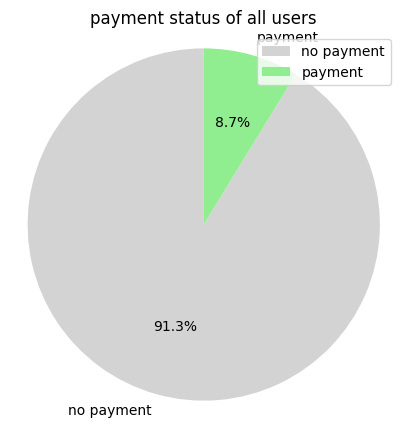

In [30]:
import matplotlib.pyplot as plt

# Ï†ÑÏ≤¥ ÏÇ¨Ïö©Ïûê ÎåÄÎπÑ Í≤∞Ï†ú Ïó¨Î∂Ä
labels = ['no payment', 'payment']
sizes = [len(all_users) - len(payment_in_users), len(payment_in_users)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgray', 'lightgreen'])
plt.axis('equal')
plt.title('payment status of all users')
plt.legend(loc= 'upper right')
plt.show()

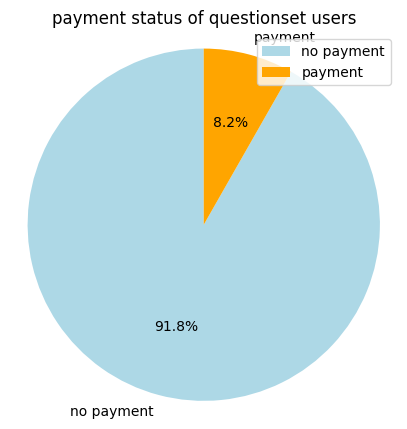

In [31]:
# ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö©Ïûê ÎåÄÎπÑ Í≤∞Ï†ú Ïó¨Î∂Ä
labels = ['no payment', 'payment']
sizes = [len(questionset_in_users) - len(both_users), len(both_users)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'orange'])
plt.axis('equal')
plt.title('payment status of questionset users')
plt.legend(loc= 'upper right')
plt.show()


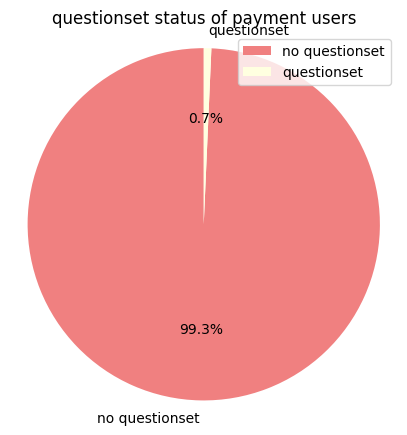

In [32]:
# Í≤∞Ï†ú ÏÇ¨Ïö©Ïûê Ï§ë ÏßàÎ¨∏ÏÑ∏Ìä∏ ÏÇ¨Ïö© Ïó¨Î∂Ä
labels = ['no questionset', 'questionset']
sizes = [len(payment_in_users) - len(both_users), len(both_users)]

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightyellow'])
plt.axis('equal')
plt.title('questionset status of payment users')
plt.legend(loc= 'upper right')
plt.show()


In [ ]:
polls_questionset= polls_questionset.sort_values(by='created_at')

In [ ]:
polls_questionset = polls_questionset.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

##### polls_usercandidate

In [63]:
polls_usercandidate = pd.read_parquet('gs://sprintda05_final_project/votes/polls_usercandidate.parquet', engine='pyarrow')

In [3]:
polls_usercandidate

id          created_at  question_piece_id  user_id
0          3088872 2023-04-28 12:27:49             998458   849444
1          3088873 2023-04-28 12:27:49             998458   849454
2          3088874 2023-04-28 12:27:49             998458   849460
3          3088875 2023-04-28 12:27:49             998458   849469
4          3088964 2023-04-28 12:28:02             998459   849446
...            ...                 ...                ...      ...
4769604  646672580 2024-05-08 01:36:00          200139933   857296
4769605  646672581 2024-05-08 01:36:18          200139934   850774
4769606  646672582 2024-05-08 01:36:18          200139934   856446
4769607  646672583 2024-05-08 01:36:18          200139934   857101
4769608  646672584 2024-05-08 01:36:18          200139934   874566

[4769609 rows x 4 columns]

In [102]:
polls_usercandidate = polls_usercandidate.sort_values(by='created_at')

In [103]:
polls_usercandidate = polls_usercandidate.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

#### Ïú†Ìñâ ÌòÑÏÉÅ Ìï¥Î∂Ä

In [2]:
accounts_attendance = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_attendance.parquet", engine='pyarrow')
accounts_blockrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet", engine='pyarrow')
accounts_failpaymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet", engine='pyarrow')
accounts_friendrequest = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_friendrequest.parquet", engine='pyarrow')
accounts_paymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_paymenthistory.parquet", engine='pyarrow')
accounts_pointhistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_pointhistory.parquet", engine='pyarrow')
accounts_timelinereport = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_timelinereport.parquet", engine='pyarrow')
accounts_user = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_user_processed.parquet", engine='pyarrow')
accounts_userquestionrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet", engine='pyarrow')
event_receipts = pd.read_parquet("gs://sprintda05_final_project/votes/event_receipts.parquet", engine='pyarrow')
polls_questionreport = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionreport.parquet", engine='pyarrow')
polls_questionset = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionset.parquet", engine='pyarrow')

In [3]:
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
attend = accounts_attendance.explode('attendance_date_list')
attend = attend[attend['attendance_date_list'].isnull()==False].sort_values(by = 'attendance_date_list')
accounts_attendance = attend.drop_duplicates(subset=['user_id'],keep='last')[['user_id','attendance_date_list']].rename(columns={'attendance_date_list':'created_at'})

In [4]:
accounts_friendrequest.groupby(['receive_user_id'])[['send_user_id']].count().reset_index().sort_values(by='send_user_id',ascending=False)
accounts_friendrequest = accounts_friendrequest.sort_values(by = 'created_at')
accounts_friendrequest = accounts_friendrequest.drop_duplicates(subset=['send_user_id'], keep='last')[['send_user_id','created_at']].rename(columns={'send_user_id': 'user_id'})

In [5]:
polls_questionset['question_piece_id_list'] =  polls_questionset['question_piece_id_list'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
polls_questionset  = polls_questionset.explode('question_piece_id_list')
polls_questionset= polls_questionset.sort_values(by='created_at')
polls_questionset = polls_questionset.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]

In [9]:
user = accounts_user[['id','created_at']]

In [10]:
data = [accounts_blockrecord,accounts_failpaymenthistory,accounts_paymenthistory,accounts_pointhistory,accounts_timelinereport,accounts_userquestionrecord,event_receipts,polls_questionreport]

In [11]:
data1 = []
for i in data:
    i = i.sort_values(by='created_at')
    i = i.drop_duplicates(subset=['user_id'], keep='last')[['user_id','created_at']]
    data1.append(i)

In [26]:
data1.append(accounts_attendance)
data1.append(accounts_friendrequest)
data1.append(polls_questionset)

In [27]:
active = pd.concat(data1, ignore_index=True)

In [28]:
active.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087088 entries, 0 to 1087087
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1087088 non-null  int64 
 1   created_at  1087088 non-null  object
dtypes: int64(1), object(1)
memory usage: 16.6+ MB


In [29]:
active['created_at'] = pd.to_datetime(active['created_at'])

In [30]:
active = active.sort_values(by='created_at', ascending=True)

In [31]:
active = active.drop_duplicates(subset=['user_id'], keep='last')

In [32]:
active.rename(columns={'created_at': 'last_active_at', 'user_id' : 'id'}, inplace=True)

In [33]:
active

id      last_active_at
433044    837521 2023-04-17 18:29:11
433045    837541 2023-04-19 06:07:20
433046    837542 2023-04-19 06:07:26
433048    837570 2023-04-19 06:10:48
433049    837607 2023-04-19 06:17:23
...          ...                 ...
1082111  1583732 2024-05-09 07:23:12
1082112  1583731 2024-05-09 07:24:50
1082113  1583673 2024-05-09 07:31:41
1082114  1575671 2024-05-09 08:20:44
1082115  1392729 2024-05-09 09:21:47

[653265 rows x 2 columns]

In [35]:
active_ra = pd.merge(user,active,how='left',on='id')

In [36]:
active_ra.isnull().sum()

id                    0
created_at            0
last_active_at    23820
dtype: int64

In [23]:
active_ra

id                 created_at      last_active_at
0        831956 2023-03-29 03:44:14.047130                 NaT
1        831962 2023-03-29 05:18:56.162368                 NaT
2        832151 2023-03-29 12:56:34.989468                 NaT
3        832340 2023-03-29 12:56:35.020790 2023-04-25 20:17:00
4        832520 2023-03-29 12:56:35.049311                 NaT
...         ...                        ...                 ...
677080  1583729 2024-05-08 21:54:33.621408                 NaT
677081  1583730 2024-05-09 07:08:11.001817                 NaT
677082  1583731 2024-05-09 07:22:19.186439                 NaT
677083  1583732 2024-05-09 07:22:38.387553                 NaT
677084  1583733 2024-05-09 08:31:17.710824                 NaT

[677085 rows x 3 columns]

In [136]:
active_ra['created_at'] = active_ra['created_at'].dt.to_period('d').astype(str)
active_ra['last_active_at'] = active_ra['last_active_at'].dt.to_period('d').astype(str)

In [137]:
active_ra

id  created_at last_active_at
0        831956  2023-03-29            NaT
1        831962  2023-03-29            NaT
2        832151  2023-03-29            NaT
3        832340  2023-03-29     2023-04-25
4        832520  2023-03-29            NaT
...         ...         ...            ...
677080  1583729  2024-05-08            NaT
677081  1583730  2024-05-09            NaT
677082  1583731  2024-05-09            NaT
677083  1583732  2024-05-09            NaT
677084  1583733  2024-05-09            NaT

[677085 rows x 3 columns]

In [138]:
active_ra[active_ra['last_active_at']=='NaT']

id  created_at last_active_at
0        831956  2023-03-29            NaT
1        831962  2023-03-29            NaT
2        832151  2023-03-29            NaT
4        832520  2023-03-29            NaT
5        832614  2023-03-29            NaT
...         ...         ...            ...
677080  1583729  2024-05-08            NaT
677081  1583730  2024-05-09            NaT
677082  1583731  2024-05-09            NaT
677083  1583732  2024-05-09            NaT
677084  1583733  2024-05-09            NaT

[584841 rows x 3 columns]

#### ÏÑúÎπÑÏä§ ÌôïÏÇ∞ Ìå®ÌÑ¥ ÌôïÏù∏

In [3]:
accounts_group = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_group.parquet", engine='pyarrow')
accounts_nearbyschool = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_nearbyschool.parquet", engine='pyarrow')
accounts_school = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_school.parquet", engine='pyarrow')
accounts_user = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_user_processed.parquet", engine='pyarrow')

In [10]:
accounts_school

id   address  student_count school_type
0        4  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            239           H
1        5  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            160           M
2        6  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            200           H
3        7  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            114           H
4        8  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            139           M
...    ...       ...            ...         ...
5946  5960  Í≤ΩÏÉÅÎÇ®ÎèÑ ÏñëÏÇ∞Ïãú            166           H
5947  5961  Ïù∏Ï≤úÍ¥ëÏó≠Ïãú ÏÑúÍµ¨             77           M
5948  5963    Í≤ΩÎ∂Å ÍπÄÏ≤úÏãú             17           H
5949  5964         -              1           H
5950  5965  Í≤ΩÍ∏∞ÎèÑ ÎèôÎëêÏ≤úÏãú             37           H

[5951 rows x 4 columns]

In [45]:
accounts_group

id  grade  class_num  school_id
0          1      1          1          1
1          8      3          2          1
2          9      3          3          1
3         10      2          2          1
4         11      2          3          1
...      ...    ...        ...        ...
84510  84542      3          2       5107
84511  84543      2          7       3487
84512  84544      3          1       5043
84513  84545      2          7        416
84514  84546      3         11       2240

[84515 rows x 4 columns]

In [4]:
accounts_group = accounts_group.rename(columns={'id': 'group_id'})

In [5]:
accounts_user_gr = accounts_user[['id','group_id','created_at']]

In [6]:
accounts_user_gr = accounts_user_gr[accounts_user_gr['group_id'].isnull() ==False].reset_index(drop=True)

In [7]:
merge_user_gr = pd.merge(accounts_user_gr,accounts_group, how='left', on='group_id').drop(columns=['grade','class_num','group_id'])

In [7]:
accounts_nearbyschool = accounts_nearbyschool.drop(columns=['id'])

In [8]:
merge_user_gr.sort_values(by='created_at', ascending=True)

id                 created_at  school_id
0        831962 2023-03-29 05:18:56.162368          1
1        832151 2023-03-29 12:56:34.989468          1
2        832340 2023-03-29 12:56:35.020790          1
3        832520 2023-03-29 12:56:35.049311          1
4        832614 2023-03-29 12:56:35.064406          1
...         ...                        ...        ...
677077  1583729 2024-05-08 21:54:33.621408       2389
677078  1583730 2024-05-09 07:08:11.001817       2969
677079  1583731 2024-05-09 07:22:19.186439       2579
677080  1583732 2024-05-09 07:22:38.387553       2579
677081  1583733 2024-05-09 08:31:17.710824       2240

[677082 rows x 3 columns]

In [19]:
df = pd.merge(accounts_nearbyschool,merge_user_gr,how='left',on='school_id')
df

distance  nearby_school_id  school_id         id  \
0        0.004564                 6          7   844076.0   
1        0.004564                 6          7   860672.0   
2        0.004564                 6          7   925325.0   
3        0.004564                 6          7   949808.0   
4        0.004564                 6          7   982351.0   
...           ...               ...        ...        ...   
6773505  0.000000              5961       5961  1571373.0   
6773506  0.000000              5961       5961  1572245.0   
6773507  0.000000              5961       5961  1572259.0   
6773508  0.000000              5961       5961  1573564.0   
6773509  0.000000              5961       5961  1575046.0   

                        created_at  
0       2023-04-23 16:38:29.093925  
1       2023-04-30 14:25:16.977793  
2       2023-05-06 15:21:56.694859  
3       2023-05-07 07:26:25.056638  
4       2023-05-07 17:25:49.541950  
...                            ...  
6773505 2023-06-07 04:03:06.713254  
6773506 2023-06-08 06:30:48.316400  
6773507 2023-06-08 06:52:54.737776  
6773508 2023-06-10 05:03:19.155910  
6773509 2023-06-12 12:53:01.567415  

[6773510 rows x 5 columns]

=== Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ï§ë... ===
=== Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Ï†ïÎ≥¥ ===
Ï¥ù Î†àÏΩîÎìú Ïàò: 6,773,510
Í≥†Ïú† ÌïôÏÉù Ïàò: 676,950
Í≥†Ïú† ÌïôÍµê Ïàò: 5,950
Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ: 2023-03-31 09:05:51.903699 ~ 2024-05-09 08:31:17.710824

=== ÏõîÎ≥Ñ Î∂ÑÏÑù Ïã§Ìñâ Ï§ë... ===
=== ÏõîÎ≥Ñ ÎàÑÏ†Å Ï¶ùÍ∞Ä Î∂ÑÏÑù ===
      month  cumulative_students  cumulative_schools  monthly_new_students  \
0   2023-03                   22                   5                    22   
1   2023-04                19052                1310                 19030   
2   2023-05               654530                5496                635478   
3   2023-06               671264                5528                 16734   
4   2023-07               673097                5536                  1833   
5   2023-08               673616                5539                   519   
6   2023-09               674180                5544                   564   
7   2023-10               674587                5544                   407   
8  

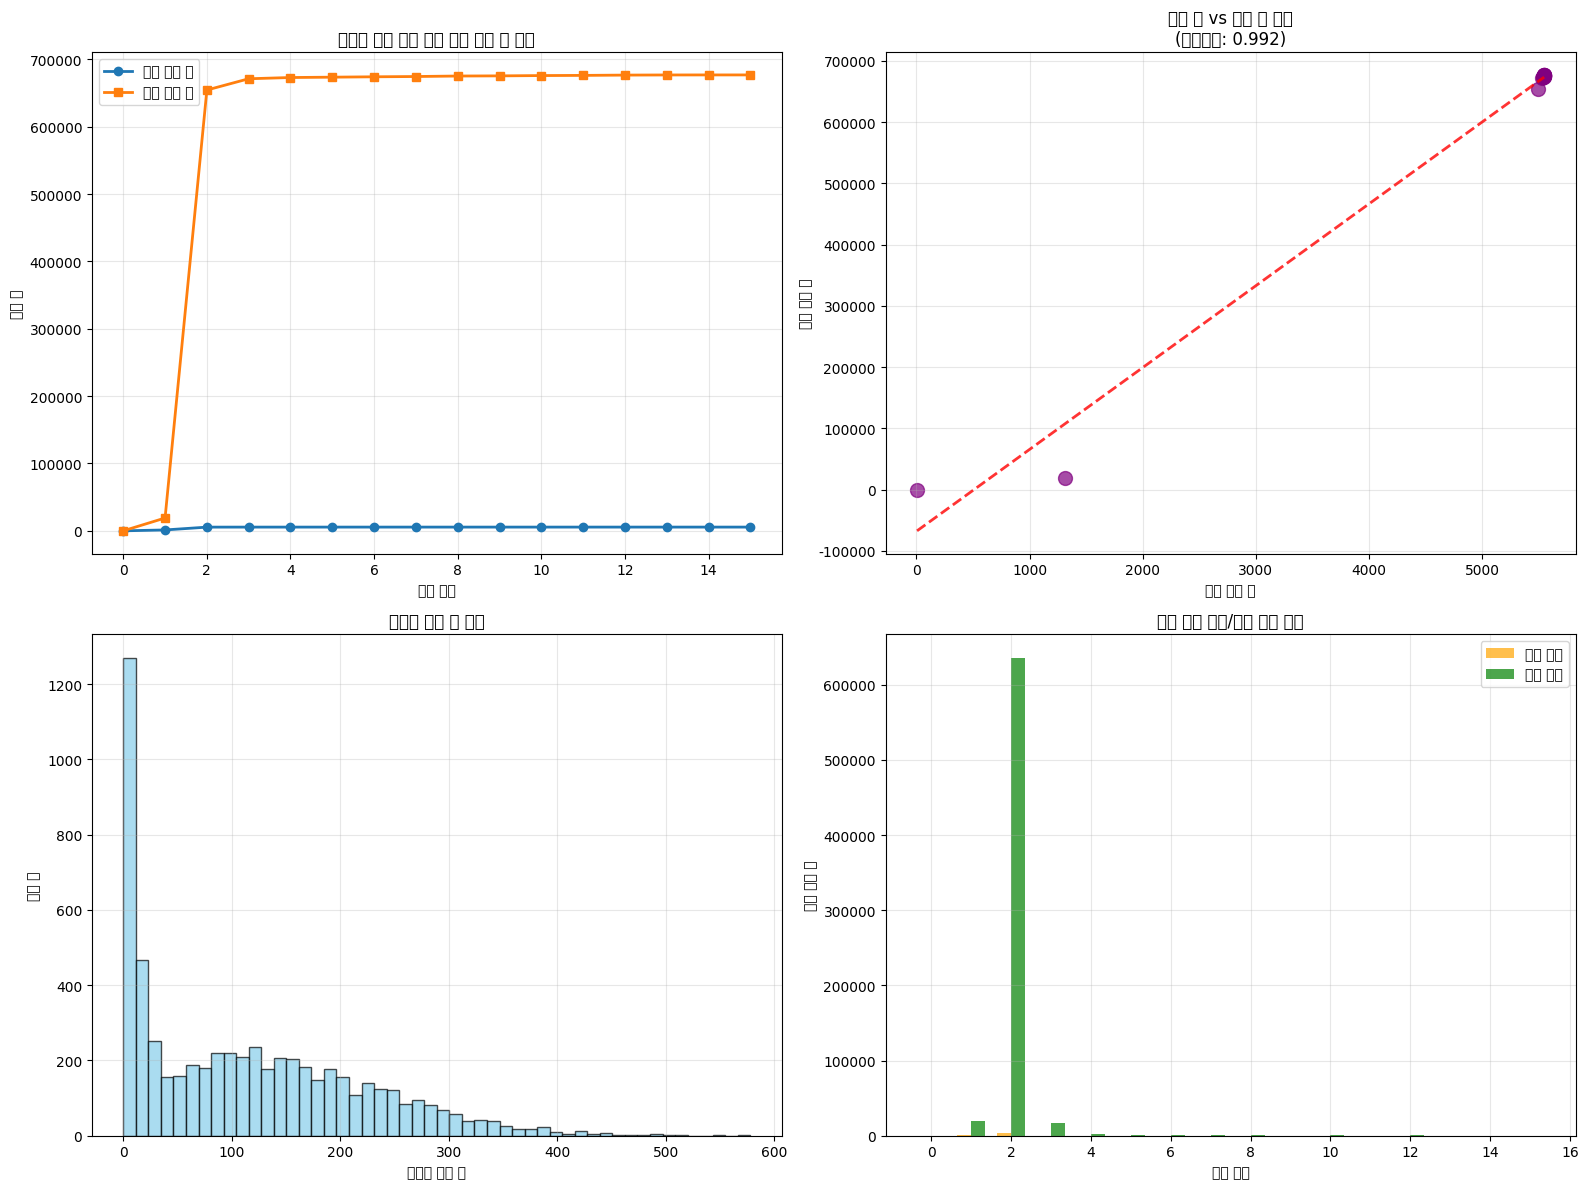

=== Ï∂îÍ∞Ä Î∂ÑÏÑù Í≤∞Í≥º ===
Í∞ÄÏû• ÎßéÏùÄ ÌïôÏÉùÏù¥ ÎàÑÏ†ÅÎêú ÏãúÏ†ê: 2024-05
Ìï¥Îãπ ÏãúÏ†ê ÌïôÍµê Ïàò: 5,549
Ìï¥Îãπ ÏãúÏ†ê ÌïôÏÉù Ïàò: 676,950

Í∏∞Í∞Ñ ÎèôÏïà ÌïôÍµê Ïàò Ï¶ùÍ∞ÄÏú®: 110880.0%
Í∏∞Í∞Ñ ÎèôÏïà ÌïôÏÉù Ïàò Ï¶ùÍ∞ÄÏú®: 3076945.5%

=== Í≤∞Î°† ===
1. Îç∞Ïù¥ÌÑ∞ Î¨¥Í≤∞ÏÑ±Ïù¥ Í≤ÄÏ¶ùÎêòÏóàÏäµÎãàÎã§ (ÏõîÎ≥Ñ Ïã†Í∑ú Ìï©Í≥Ñ = Ï†ÑÏ≤¥ Ïàò)
2. ÏÑ±Îä•Ïù¥ ÌÅ¨Í≤å Í∞úÏÑ†ÎêòÏóàÏäµÎãàÎã§ (NetworkX Í∑∏ÎûòÌîÑ ÏÉùÏÑ± ÏÉùÎûµ)
3. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑùÏúºÎ°ú ÌïôÍµê ÏàòÏôÄ ÌïôÏÉù ÏàòÏùò Í¥ÄÍ≥ÑÎ•º Ï†ïÌôïÌûà ÌååÏïÖÌï† Ïàò ÏûàÏäµÎãàÎã§.

Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Î°ú ÍµêÏ≤¥ÌïòÏó¨ Î∂ÑÏÑùÌïòÏÑ∏Ïöî!


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from collections import defaultdict



# ÏÑ±Îä• ÏµúÏ†ÅÌôî: Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨Î•º Ìïú Î≤àÏóê ÏàòÌñâ
print("=== Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ï§ë... ===")
df['created_at'] = pd.to_datetime(df['created_at'])
df['month'] = df['created_at'].dt.to_period('M')
df = df.sort_values('created_at')

print("=== Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Ï†ïÎ≥¥ ===")
print(f"Ï¥ù Î†àÏΩîÎìú Ïàò: {len(df):,}")
print(f"Í≥†Ïú† ÌïôÏÉù Ïàò: {df['id'].nunique():,}")
print(f"Í≥†Ïú† ÌïôÍµê Ïàò: {df['school_id'].nunique():,}")
print(f"Îç∞Ïù¥ÌÑ∞ Í∏∞Í∞Ñ: {df['created_at'].min()} ~ {df['created_at'].max()}")
print()

# ÏÑ±Îä• ÏµúÏ†ÅÌôîÎêú ÏãúÍ∞ÑÎåÄÎ≥Ñ Î∂ÑÏÑù
def analyze_by_time_period_optimized(df):
    """ÏÑ±Îä• ÏµúÏ†ÅÌôîÎêú ÏãúÍ∞ÑÎåÄÎ≥Ñ Î∂ÑÏÑù - ÎÖºÎ¶¨Ï†Å Ïò§Î•ò ÏàòÏ†ï"""
    
    # Í∞Å ÌïôÏÉùÍ≥º ÌïôÍµêÏùò Ï≤´ Îì±Ïû• Ïõî Ï∞æÍ∏∞ (ÏÑ±Îä• ÏµúÏ†ÅÌôî)
    student_first_month = df.groupby('id')['month'].min()
    school_first_month = df.groupby('school_id')['month'].min()
    
    # ÏõîÎ≥Ñ Ï†ïÎ≥¥Î•º ÎîïÏÖîÎÑàÎ¶¨Î°ú ÎØ∏Î¶¨ Í≥ÑÏÇ∞
    months = sorted(df['month'].unique())
    monthly_stats = []
    
    seen_students = set()
    seen_schools = set()
    
    for month in months:
        # Ìï¥Îãπ ÏõîÏóê Ï≤òÏùå Îì±Ïû•Ìïú ÌïôÏÉùÍ≥º ÌïôÍµê Ï∞æÍ∏∞
        new_students_this_month = set(student_first_month[student_first_month == month].index)
        new_schools_this_month = set(school_first_month[school_first_month == month].index)
        
        # ÎàÑÏ†Å ÏßëÌï©Ïóê Ï∂îÍ∞Ä
        seen_students.update(new_students_this_month)
        seen_schools.update(new_schools_this_month)
        
        stats = {
            'month': str(month),
            'cumulative_students': len(seen_students),
            'cumulative_schools': len(seen_schools),
            'monthly_new_students': len(new_students_this_month),
            'monthly_new_schools': len(new_schools_this_month)
        }
        monthly_stats.append(stats)
    
    return pd.DataFrame(monthly_stats)

# ÏÑ±Îä• ÏµúÏ†ÅÌôîÎêú ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù
def analyze_network_properties_optimized(df):
    """ÏÑ±Îä• ÏµúÏ†ÅÌôîÎêú ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù"""
    
    # ÏßÅÏ†ë degree Í≥ÑÏÇ∞ (NetworkX ÏÉùÏÑ± ÏóÜÏù¥)
    school_student_count = df.groupby('school_id')['id'].nunique().to_dict()
    student_school_count = df.groupby('id')['school_id'].nunique().to_dict()
    
    total_students = df['id'].nunique()
    total_schools = df['school_id'].nunique()
    total_connections = len(df)
    
    print("=== ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù Í≤∞Í≥º ===")
    print(f"Í≥†Ïú† ÌïôÏÉù Ïàò: {total_students:,}")
    print(f"Í≥†Ïú† ÌïôÍµê Ïàò: {total_schools:,}")
    print(f"Ï¥ù Ïó∞Í≤∞ Ïàò: {total_connections:,}")
    print()
    
    print("=== ÌïôÍµêÎ≥Ñ ÌïôÏÉù Ïàò Î∂ÑÌè¨ ===")
    school_counts = list(school_student_count.values())
    print(f"ÌèâÍ∑† ÌïôÍµêÎãπ ÌïôÏÉù Ïàò: {np.mean(school_counts):.2f}")
    print(f"ÌïôÍµêÎãπ ÌïôÏÉù Ïàò ÌëúÏ§ÄÌé∏Ï∞®: {np.std(school_counts):.2f}")
    print(f"ÏµúÎåÄ ÌïôÏÉù ÏàòÎ•º Í∞ÄÏßÑ ÌïôÍµê: {max(school_counts):,}Î™Ö")
    print(f"ÏµúÏÜå ÌïôÏÉù ÏàòÎ•º Í∞ÄÏßÑ ÌïôÍµê: {min(school_counts):,}Î™Ö")
    print()
    
    print("=== ÌïôÏÉùÎ≥Ñ ÌïôÍµê Ïàò Î∂ÑÌè¨ ===")
    student_counts = list(student_school_count.values())
    print(f"ÌèâÍ∑† ÌïôÏÉùÎãπ ÌïôÍµê Ïàò: {np.mean(student_counts):.2f}")
    print(f"ÌïôÏÉùÎãπ ÌïôÍµê Ïàò ÌëúÏ§ÄÌé∏Ï∞®: {np.std(student_counts):.2f}")
    print()
    
    return school_student_count, student_school_count

# ÏµúÏ†ÅÌôîÎêú Î∂ÑÏÑù Ïã§Ìñâ
print("=== ÏõîÎ≥Ñ Î∂ÑÏÑù Ïã§Ìñâ Ï§ë... ===")
monthly_analysis = analyze_by_time_period_optimized(df)

print("=== ÏõîÎ≥Ñ ÎàÑÏ†Å Ï¶ùÍ∞Ä Î∂ÑÏÑù ===")
print(monthly_analysis)
print()

# Í≤ÄÏ¶ù: ÏõîÎ≥Ñ Ïã†Í∑ú Ìï©Í≥ÑÍ∞Ä Ï†ÑÏ≤¥ÏôÄ ÏùºÏπòÌïòÎäîÏßÄ ÌôïÏù∏
total_new_students = monthly_analysis['monthly_new_students'].sum()
total_new_schools = monthly_analysis['monthly_new_schools'].sum()
actual_total_students = df['id'].nunique()
actual_total_schools = df['school_id'].nunique()

print("=== Îç∞Ïù¥ÌÑ∞ Î¨¥Í≤∞ÏÑ± Í≤ÄÏ¶ù ===")
print(f"ÏõîÎ≥Ñ Ïã†Í∑ú ÌïôÏÉù Ìï©Í≥Ñ: {total_new_students:,}")
print(f"Ïã§Ï†ú Ï¥ù ÌïôÏÉù Ïàò: {actual_total_students:,}")
print(f"ÌïôÏÉù Ïàò ÏùºÏπò: {'‚úì' if total_new_students == actual_total_students else '‚úó'}")
print()
print(f"ÏõîÎ≥Ñ Ïã†Í∑ú ÌïôÍµê Ìï©Í≥Ñ: {total_new_schools:,}")
print(f"Ïã§Ï†ú Ï¥ù ÌïôÍµê Ïàò: {actual_total_schools:,}")
print(f"ÌïôÍµê Ïàò ÏùºÏπò: {'‚úì' if total_new_schools == actual_total_schools else '‚úó'}")
print()

# ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù Ïã§Ìñâ
print("=== ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù Ïã§Ìñâ Ï§ë... ===")
school_degrees, student_degrees = analyze_network_properties_optimized(df)

# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù
print("=== ÌïôÍµê ÏàòÏôÄ ÌïôÏÉù Ïàò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù ===")
correlation = monthly_analysis['cumulative_schools'].corr(monthly_analysis['cumulative_students'])
print(f"ÌïôÍµê ÏàòÏôÄ ÌïôÏÉù ÏàòÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàò: {correlation:.4f}")

if correlation > 0.8:
    print("‚Üí Í∞ïÌïú ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ: ÌïôÍµê ÏàòÍ∞Ä Ï¶ùÍ∞ÄÌïòÎ©¥ ÌïôÏÉù ÏàòÎèÑ ÌÅ¨Í≤å Ï¶ùÍ∞Ä")
elif correlation > 0.5:
    print("‚Üí Ï§ëÍ∞Ñ ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ: ÌïôÍµê ÏàòÍ∞Ä Ï¶ùÍ∞ÄÌïòÎ©¥ ÌïôÏÉù ÏàòÎèÑ Ïñ¥Îäê Ï†ïÎèÑ Ï¶ùÍ∞Ä")
elif correlation > 0.2:
    print("‚Üí ÏïΩÌïú ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ: ÌïôÍµê ÏàòÏôÄ ÌïôÏÉù Ïàò Ï¶ùÍ∞ÄÍ∞Ä ÏïΩÍ∞Ñ Í¥ÄÎ†®")
else:
    print("‚Üí ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÎÇÆÏùå: ÌïôÍµê ÏàòÏôÄ ÌïôÏÉù Ïàò Ï¶ùÍ∞ÄÍ∞Ä ÏßÅÏ†ëÏ†ÅÏúºÎ°ú Ïó∞Í¥ÄÎêòÏßÄ ÏïäÏùå")
print()

# ÏÑ±Îä• ÏµúÏ†ÅÌôîÎêú ÏãúÍ∞ÅÌôî
print("=== ÏãúÍ∞ÅÌôî ÏÉùÏÑ± Ï§ë... ===")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ÎàÑÏ†Å ÌïôÍµê ÏàòÏôÄ ÌïôÏÉù Ïàò Î≥ÄÌôî
ax1 = axes[0, 0]
monthly_analysis['month_num'] = range(len(monthly_analysis))
ax1.plot(monthly_analysis['month_num'], monthly_analysis['cumulative_schools'], 
         marker='o', label='ÎàÑÏ†Å ÌïôÍµê Ïàò', linewidth=2, markersize=6)
ax1.plot(monthly_analysis['month_num'], monthly_analysis['cumulative_students'], 
         marker='s', label='ÎàÑÏ†Å ÌïôÏÉù Ïàò', linewidth=2, markersize=6)
ax1.set_xlabel('ÏãúÍ∞Ñ ÏàúÏÑú')
ax1.set_ylabel('ÎàÑÏ†Å Ïàò')
ax1.set_title('ÏãúÍ∞ÑÏóê Îî∞Î•∏ ÎàÑÏ†Å ÌïôÍµê ÏàòÏôÄ ÌïôÏÉù Ïàò Î≥ÄÌôî')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ÌïôÍµê Ïàò vs ÌïôÏÉù Ïàò ÏÇ∞Ï†êÎèÑ
ax2 = axes[0, 1]
ax2.scatter(monthly_analysis['cumulative_schools'], monthly_analysis['cumulative_students'], 
           s=100, alpha=0.7, color='purple')
ax2.set_xlabel('ÎàÑÏ†Å ÌïôÍµê Ïàò')
ax2.set_ylabel('ÎàÑÏ†Å ÌïôÏÉù Ïàò')
ax2.set_title(f'ÌïôÍµê Ïàò vs ÌïôÏÉù Ïàò Í¥ÄÍ≥Ñ\n(ÏÉÅÍ¥ÄÍ≥ÑÏàò: {correlation:.3f})')
ax2.grid(True, alpha=0.3)

# Ï∂îÏÑ∏ÏÑ† Ï∂îÍ∞Ä
if len(monthly_analysis) >= 2:
    z = np.polyfit(monthly_analysis['cumulative_schools'], monthly_analysis['cumulative_students'], 1)
    p = np.poly1d(z)
    ax2.plot(monthly_analysis['cumulative_schools'], p(monthly_analysis['cumulative_schools']), 
             "r--", alpha=0.8, linewidth=2)

# 3. ÌïôÍµêÎ≥Ñ ÌïôÏÉù Ïàò Î∂ÑÌè¨
ax3 = axes[1, 0]
school_counts = list(school_degrees.values())
bins = min(50, max(1, len(set(school_counts))))  # ÏµúÎåÄ 50Í∞ú bin
ax3.hist(school_counts, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('ÌïôÍµêÎãπ ÌïôÏÉù Ïàò')
ax3.set_ylabel('ÌïôÍµê Ïàò')
ax3.set_title('ÌïôÍµêÎ≥Ñ ÌïôÏÉù Ïàò Î∂ÑÌè¨')
ax3.grid(True, alpha=0.3)

# 4. ÏõîÎ≥Ñ Ïã†Í∑ú Îì±Î°ù ÌòÑÌô©
ax4 = axes[1, 1]
width = 0.35
x = monthly_analysis['month_num']
ax4.bar([i - width/2 for i in x], monthly_analysis['monthly_new_schools'], 
        width, label='Ïã†Í∑ú ÌïôÍµê', alpha=0.7, color='orange')
ax4.bar([i + width/2 for i in x], monthly_analysis['monthly_new_students'], 
        width, label='Ïã†Í∑ú ÌïôÏÉù', alpha=0.7, color='green')
ax4.set_xlabel('ÏãúÍ∞Ñ ÏàúÏÑú')
ax4.set_ylabel('Ïã†Í∑ú Îì±Î°ù Ïàò')
ax4.set_title('ÏõîÎ≥Ñ Ïã†Í∑ú ÌïôÍµê/ÌïôÏÉù Îì±Î°ù ÌòÑÌô©')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ï∂îÍ∞Ä Ïù∏ÏÇ¨Ïù¥Ìä∏
print("=== Ï∂îÍ∞Ä Î∂ÑÏÑù Í≤∞Í≥º ===")
max_month_idx = monthly_analysis['cumulative_students'].idxmax()
peak_month = monthly_analysis.iloc[max_month_idx]
print(f"Í∞ÄÏû• ÎßéÏùÄ ÌïôÏÉùÏù¥ ÎàÑÏ†ÅÎêú ÏãúÏ†ê: {peak_month['month']}")
print(f"Ìï¥Îãπ ÏãúÏ†ê ÌïôÍµê Ïàò: {peak_month['cumulative_schools']:,}")
print(f"Ìï¥Îãπ ÏãúÏ†ê ÌïôÏÉù Ïàò: {peak_month['cumulative_students']:,}")

# ÏÑ±Ïû•Î•† Í≥ÑÏÇ∞
if len(monthly_analysis) >= 2:
    first_month = monthly_analysis.iloc[0]
    last_month = monthly_analysis.iloc[-1]
    
    school_growth_rate = ((last_month['cumulative_schools'] - first_month['cumulative_schools']) / 
                         first_month['cumulative_schools']) * 100 if first_month['cumulative_schools'] > 0 else 0
    student_growth_rate = ((last_month['cumulative_students'] - first_month['cumulative_students']) / 
                          first_month['cumulative_students']) * 100 if first_month['cumulative_students'] > 0 else 0
    
    print(f"\nÍ∏∞Í∞Ñ ÎèôÏïà ÌïôÍµê Ïàò Ï¶ùÍ∞ÄÏú®: {school_growth_rate:.1f}%")
    print(f"Í∏∞Í∞Ñ ÎèôÏïà ÌïôÏÉù Ïàò Ï¶ùÍ∞ÄÏú®: {student_growth_rate:.1f}%")


##### 2023/05Ïóê Í∞ÄÏû• ÎßéÏùÄ Ïù¥Ïö©ÏûêÎì§Ïù¥ Í∞ÄÏûÖÌïòÏòÄÍ≥† ÎßéÏùÄ ÌïôÍµêÍ∞Ä ÌôúÏÑ±Ìôî ÎêòÏóàÎã§

In [8]:
merge_user_unique = merge_user_gr.drop_duplicates(subset=['school_id'],keep='first')
merge_user_unique

id                 created_at  school_id
0        831962 2023-03-29 05:18:56.162368          1
10       833024 2023-03-31 09:05:51.903699       5464
11       833041 2023-03-31 14:32:36.425315        314
12       833112 2023-03-31 15:55:48.870381        281
13       833113 2023-03-31 15:56:52.300066        272
...         ...                        ...        ...
675394  1582045 2023-11-25 11:43:54.231956       4997
675504  1582155 2023-12-07 07:10:36.509119       1903
675681  1582332 2024-01-01 06:09:17.021212       3690
676357  1583008 2024-02-29 07:27:55.357481       5703
676705  1583356 2024-03-19 12:14:20.637029       1135

[5551 rows x 3 columns]

In [9]:
accounts_nearbyschool = accounts_nearbyschool.drop(columns=['id'])

In [105]:
df = pd.merge(accounts_nearbyschool,merge_user_unique,how='right',on='school_id').sort_values(by='created_at', ascending=True)

In [11]:
df

distance  nearby_school_id  school_id       id  \
0           NaN               NaN          1   831962   
1      0.008735            4932.0       5464   833024   
2      0.010750            5467.0       5464   833024   
3      0.010793            5459.0       5464   833024   
4      0.014790            4930.0       5464   833024   
...         ...               ...        ...      ...   
55486  0.100136            1130.0       1135  1583356   
55487  0.100826            1150.0       1135  1583356   
55488  0.104826            1138.0       1135  1583356   
55489  0.106578            1140.0       1135  1583356   
55491  0.000000            1135.0       1135  1583356   

                      created_at  
0     2023-03-29 05:18:56.162368  
1     2023-03-31 09:05:51.903699  
2     2023-03-31 09:05:51.903699  
3     2023-03-31 09:05:51.903699  
4     2023-03-31 09:05:51.903699  
...                          ...  
55486 2024-03-19 12:14:20.637029  
55487 2024-03-19 12:14:20.637029  
55488 2024-03-19 12:14:20.637029  
55489 2024-03-19 12:14:20.637029  
55491 2024-03-19 12:14:20.637029  

[55492 rows x 5 columns]

In [11]:
accounts_school = accounts_school.rename(columns={'id':'school_id'})

In [18]:
accounts_school

school_id   address  student_count school_type
0             4  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            239           H
1             5  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            160           M
2             6  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            200           H
3             7  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            114           H
4             8  Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú            139           M
...         ...       ...            ...         ...
5946       5960  Í≤ΩÏÉÅÎÇ®ÎèÑ ÏñëÏÇ∞Ïãú            166           H
5947       5961  Ïù∏Ï≤úÍ¥ëÏó≠Ïãú ÏÑúÍµ¨             77           M
5948       5963    Í≤ΩÎ∂Å ÍπÄÏ≤úÏãú             17           H
5949       5964         -              1           H
5950       5965  Í≤ΩÍ∏∞ÎèÑ ÎèôÎëêÏ≤úÏãú             37           H

[5951 rows x 4 columns]

In [106]:
df = pd.merge(accounts_school, df, how='right', on='school_id')
df = df.drop(columns=['id'])
df = df[df['school_id'] != df['nearby_school_id']]
df = df[df['distance'].isnull() == False]
df

school_id   address  student_count school_type  distance  \
1           5464   Í≤ΩÍ∏∞ÎèÑ Íµ∞Ìè¨Ïãú          158.0           H  0.008735   
2           5464   Í≤ΩÍ∏∞ÎèÑ Íµ∞Ìè¨Ïãú          158.0           H  0.010750   
3           5464   Í≤ΩÍ∏∞ÎèÑ Íµ∞Ìè¨Ïãú          158.0           H  0.010793   
4           5464   Í≤ΩÍ∏∞ÎèÑ Íµ∞Ìè¨Ïãú          158.0           H  0.014790   
5           5464   Í≤ΩÍ∏∞ÎèÑ Íµ∞Ìè¨Ïãú          158.0           H  0.016839   
...          ...       ...            ...         ...       ...   
55486       1135  Ï†ÑÎùºÎÇ®ÎèÑ Ïó¨ÏàòÏãú            1.0           M  0.097624   
55487       1135  Ï†ÑÎùºÎÇ®ÎèÑ Ïó¨ÏàòÏãú            1.0           M  0.100136   
55488       1135  Ï†ÑÎùºÎÇ®ÎèÑ Ïó¨ÏàòÏãú            1.0           M  0.100826   
55489       1135  Ï†ÑÎùºÎÇ®ÎèÑ Ïó¨ÏàòÏãú            1.0           M  0.104826   
55490       1135  Ï†ÑÎùºÎÇ®ÎèÑ Ïó¨ÏàòÏãú            1.0           M  0.106578   

       nearby_school_id                 created_at  
1                4932.0 2023-03-31 09:05:51.903699  
2                5467.0 2023-03-31 09:05:51.903699  
3                5459.0 2023-03-31 09:05:51.903699  
4                4930.0 2023-03-31 09:05:51.903699  
5                5457.0 2023-03-31 09:05:51.903699  
...                 ...                        ...  
55486            1147.0 2024-03-19 12:14:20.637029  
55487            1130.0 2024-03-19 12:14:20.637029  
55488            1150.0 2024-03-19 12:14:20.637029  
55489            1138.0 2024-03-19 12:14:20.637029  
55490            1140.0 2024-03-19 12:14:20.637029  

[49941 rows x 7 columns]

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def analyze_school_spread(df):
    """
    ÌïôÍµê Í∞Ñ Ï†ÑÌåå Ìå®ÌÑ¥ Î∂ÑÏÑù Ìï®Ïàò (ÎçîÎ∏î Ïπ¥Ïö¥ÌåÖ Î¨∏Ï†ú Ìï¥Í≤∞)
    """
    # Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
    df = df.dropna(subset=['school_id', 'created_at']).copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df = df.sort_values('created_at')
    
    # ÏßÄÏó≠ Ï∂îÏ∂ú (Ïãú/ÎèÑ Îã®ÏúÑ)
    df['region'] = df['address'].str.split().str[0]
    df['city'] = df['address'].str.split().str[1]
    
    results = {}
    
    # 1. ÌôïÏÇ∞ ÏàúÏÑú Î∂ÑÏÑù
    print("=== ÌôïÏÇ∞ ÏàúÏÑú Î∂ÑÏÑù ===")
    spread_order = df.groupby('school_id')['created_at'].min().sort_values()
    results['spread_order'] = spread_order
    
    print("Ï≤´ 10Í∞ú ÌïôÍµêÏùò ÌôïÏÇ∞ ÏàúÏÑú:")
    for i, (school_id, timestamp) in enumerate(spread_order.head(10).items()):
        school_info = df[df['school_id'] == school_id].iloc[0]
        print(f"{i+1}. ÌïôÍµê {school_id} ({school_info['address']}) - {timestamp.strftime('%Y-%m-%d %H:%M')}")
    
    # 2. Í∞úÏÑ†Îêú ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù (ÎçîÎ∏î Ïπ¥Ïö¥ÌåÖ Î¨∏Ï†ú Ìï¥Í≤∞)
    print("\n=== ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù (Í∞úÏÑ†) ===")
    
    # ÌïôÍµêÎ≥Ñ Ï≤´ Îì±Î°ù ÏãúÍ∞Ñ
    school_first_time = df.groupby('school_id')['created_at'].min()
    
    # Î™®Îì† ÌïôÍµê Ïåç Ï†ïÎ≥¥Î•º Î®ºÏ†Ä ÏàòÏßë
    all_pairs = []
    for _, row in df.iterrows():
        if pd.notna(row['nearby_school_id']) and row['nearby_school_id'] in school_first_time.index:
            pair_info = {
                'school_1': row['school_id'],
                'school_2': row['nearby_school_id'],
                'distance': row['distance'],
                'school_1_info': row,
                'school_1_time': school_first_time[row['school_id']],
                'school_2_time': school_first_time[row['nearby_school_id']]
            }
            all_pairs.append(pair_info)
    
    # Ï§ëÎ≥µ Ï†úÍ±∞ Î∞è Ï†ÑÌåå Î∞©Ìñ• Í≤∞Ï†ï
    processed_pairs = set()
    spread_speeds = []
    
    for pair in all_pairs:
        # ÌïôÍµê ÏåçÏùÑ Ï†ïÎ†¨ÌïòÏó¨ Í≥†Ïú† ÌÇ§ ÏÉùÏÑ± (ÎçîÎ∏î Ïπ¥Ïö¥ÌåÖ Î∞©ÏßÄ)
        school_pair = tuple(sorted([pair['school_1'], pair['school_2']]))
        
        # Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú ÏåçÏù¥Î©¥ Í±¥ÎÑàÎõ∞Í∏∞
        if school_pair in processed_pairs:
            continue
        
        processed_pairs.add(school_pair)
        
        # ÏãúÍ∞Ñ Ï∞®Ïù¥ Í≥ÑÏÇ∞
        time_diff = (pair['school_1_time'] - pair['school_2_time']).total_seconds() / (24 * 3600)
        
        # Ï†ÑÌåå Î∞©Ìñ• Í≤∞Ï†ï (Ïù¥Î•∏ ÏãúÍ∞Ñ ‚Üí Îä¶ÏùÄ ÏãúÍ∞Ñ)
        if pair['school_1_time'] < pair['school_2_time']:
            # school_1Ïù¥ Î®ºÏ†Ä Îì±Î°ù ‚Üí school_2Î°ú Ï†ÑÌåå
            source_school = pair['school_1']
            target_school = pair['school_2']
            source_time = pair['school_1_time']
            target_time = pair['school_2_time']
            spread_direction = "forward"
        elif pair['school_1_time'] > pair['school_2_time']:
            # school_2Ïù¥ Î®ºÏ†Ä Îì±Î°ù ‚Üí school_1Î°ú Ï†ÑÌåå
            source_school = pair['school_2']
            target_school = pair['school_1']
            source_time = pair['school_2_time']
            target_time = pair['school_1_time']
            spread_direction = "forward"
        else:
            # ÎèôÏãú Îì±Î°ù (Îß§Ïö∞ ÎìúÎ¨∏ Í≤ΩÏö∞)
            source_school = pair['school_1']
            target_school = pair['school_2']
            source_time = pair['school_1_time']
            target_time = pair['school_2_time']
            spread_direction = "simultaneous"
        
        # ÏÜåÏä§ ÌïôÍµêÏôÄ ÌÉÄÍ≤ü ÌïôÍµê Ï†ïÎ≥¥ Í∞ÄÏ†∏Ïò§Í∏∞
        source_info = df[df['school_id'] == source_school].iloc[0]
        target_info = df[df['school_id'] == target_school]
        
        if not target_info.empty:
            target_info = target_info.iloc[0]
            
            spread_speeds.append({
                'source_school': source_school,
                'target_school': target_school,
                'source_time': source_time,
                'target_time': target_time,
                'time_diff_days': abs(time_diff),
                'spread_direction': spread_direction,
                'distance': pair['distance'],
                'source_region': source_info['region'],
                'source_city': source_info['city'],
                'source_student_count': source_info['student_count'],
                'source_school_type': source_info['school_type'],
                'target_region': target_info['region'],
                'target_city': target_info['city'],
                'target_student_count': target_info['student_count'],
                'target_school_type': target_info['school_type'],
                'same_region': source_info['region'] == target_info['region'],
                'same_city': source_info['city'] == target_info['city']
            })
    
    spread_df = pd.DataFrame(spread_speeds)
    results['spread_speeds'] = spread_df
    
    if not spread_df.empty:
        print(f"Ï¥ù Í≥†Ïú† ÌïôÍµê Ïåç Ïàò: {len(spread_df)}Í∞ú (Ï§ëÎ≥µ Ï†úÍ±∞ ÏôÑÎ£å)")
        print(f"ÌèâÍ∑† ÌôïÏÇ∞ ÏÜçÎèÑ: {spread_df['time_diff_days'].mean():.2f}Ïùº")
        print(f"ÌôïÏÇ∞ ÏÜçÎèÑ Ï§ëÏïôÍ∞í: {spread_df['time_diff_days'].median():.2f}Ïùº")
        print(f"ÏµúÎåÄ ÌôïÏÇ∞ ÏÜçÎèÑ: {spread_df['time_diff_days'].max():.2f}Ïùº")
        print(f"ÏµúÏÜå ÌôïÏÇ∞ ÏÜçÎèÑ: {spread_df['time_diff_days'].min():.2f}Ïùº")
        
        # Ï†ÑÌåå Î∞©Ìñ• Î∂ÑÏÑù (Í∞úÏÑ†)
        direction_counts = spread_df['spread_direction'].value_counts()
        print(f"\nÏ†ÑÌåå Î∞©Ìñ• Î∂ÑÏÑù (Ï§ëÎ≥µ Ï†úÍ±∞):")
        for direction, count in direction_counts.items():
            if direction == 'forward':
                print(f"- ÏàúÏ∞®Ï†Å Ï†ÑÌåå (ÏãúÍ∞Ñ ÏàúÏÑúÎåÄÎ°ú): {count}Í±¥")
            elif direction == 'simultaneous':
                print(f"- ÎèôÏãú Îì±Î°ù: {count}Í±¥")
        
        # Îπ†Î•∏ ÌôïÏÇ∞ ÏÇ¨Î°Ä (ÏÉÅÏúÑ 10Í∞ú)
        fastest_spreads = spread_df.nsmallest(10, 'time_diff_days')
        print(f"\nÍ∞ÄÏû• Îπ†Î•∏ ÌôïÏÇ∞ ÏÇ¨Î°Ä (ÏÉÅÏúÑ 10Í∞ú):")
        for idx, row in fastest_spreads.iterrows():
            print(f"  ÌïôÍµê {row['source_school']} ‚Üí ÌïôÍµê {row['target_school']}: {row['time_diff_days']:.2f}Ïùº (Í±∞Î¶¨: {row['distance']:.3f})")
    
    # 3. ÏßÄÎ¶¨Ï†Å Í¥ÄÍ≥Ñ Î∂ÑÏÑù (Í∞úÏÑ†)
    print("\n=== ÏßÄÎ¶¨Ï†Å Í¥ÄÍ≥Ñ Î∂ÑÏÑù ===")
    
    if not spread_df.empty:
        # Í±∞Î¶¨Î≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
        correlation = spread_df['distance'].corr(spread_df['time_diff_days'])
        print(f"Í±∞Î¶¨ÏôÄ ÌôïÏÇ∞ ÏÜçÎèÑ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ: {correlation:.3f}")
        
        # Í±∞Î¶¨ Íµ¨Í∞ÑÎ≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ (Îçî ÏÑ∏Î∂ÑÌôî)
        spread_df['distance_group'] = pd.cut(spread_df['distance'], 
                                           bins=[0, 0.005, 0.01, 0.05, 0.1, float('inf')],
                                           labels=['Îß§Ïö∞ Í∞ÄÍπåÏõÄ(<0.005)', 'Í∞ÄÍπåÏõÄ(0.005-0.01)', 
                                                  'Ï§ëÍ∞Ñ(0.01-0.05)', 'Î©ÄÏùå(0.05-0.1)', 'Îß§Ïö∞ Î©ÄÏùå(>0.1)'])
        
        distance_speed = spread_df.groupby('distance_group')['time_diff_days'].agg(['mean', 'median', 'count', 'std'])
        print("\nÍ±∞Î¶¨Î≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ:")
        print(distance_speed)
        results['distance_analysis'] = distance_speed
        
        # Í∞ôÏùÄ ÏßÄÏó≠/ÎèÑÏãú ÎÇ¥ ÌôïÏÇ∞ Î∂ÑÏÑù
        same_region_count = spread_df['same_region'].sum()
        same_city_count = spread_df['same_city'].sum()
        print(f"\nÏßÄÏó≠ ÎÇ¥ ÌôïÏÇ∞:")
        print(f"- Í∞ôÏùÄ Ïãú/ÎèÑ ÎÇ¥ ÌôïÏÇ∞: {same_region_count}Í±¥ ({same_region_count/len(spread_df)*100:.1f}%)")
        print(f"- Í∞ôÏùÄ Ïãú/Íµ∞/Íµ¨ ÎÇ¥ ÌôïÏÇ∞: {same_city_count}Í±¥ ({same_city_count/len(spread_df)*100:.1f}%)")
        
        # Í∞ôÏùÄ ÏßÄÏó≠ vs Îã§Î•∏ ÏßÄÏó≠ ÌôïÏÇ∞ ÏÜçÎèÑ ÎπÑÍµê
        same_region_speed = spread_df[spread_df['same_region']]['time_diff_days'].mean()
        diff_region_speed = spread_df[~spread_df['same_region']]['time_diff_days'].mean()
        print(f"- Í∞ôÏùÄ ÏßÄÏó≠ ÎÇ¥ ÌèâÍ∑† ÌôïÏÇ∞ ÏÜçÎèÑ: {same_region_speed:.2f}Ïùº")
        print(f"- Îã§Î•∏ ÏßÄÏó≠ Í∞Ñ ÌèâÍ∑† ÌôïÏÇ∞ ÏÜçÎèÑ: {diff_region_speed:.2f}Ïùº")
    
    # 4. ÏßÄÏó≠Î≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù (ÏÜåÏä§ Í∏∞Ï§Ä)
    print("\n=== ÏßÄÏó≠Î≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù (Ï†ÑÌåå ÏÜåÏä§ Í∏∞Ï§Ä) ===")
    
    if not spread_df.empty:
        regional_speed = spread_df.groupby('source_region')['time_diff_days'].agg(['mean', 'median', 'count', 'std']).sort_values('mean')
        print("ÏßÄÏó≠Î≥Ñ ÌèâÍ∑† ÌôïÏÇ∞ ÏÜçÎèÑ (Îπ†Î•∏ Ïàú):")
        print(regional_speed)
        results['regional_analysis'] = regional_speed
        
        # ÌÉÄÍ≤ü ÏßÄÏó≠ Í∏∞Ï§Ä Î∂ÑÏÑùÎèÑ Ï∂îÍ∞Ä
        target_regional_speed = spread_df.groupby('target_region')['time_diff_days'].agg(['mean', 'median', 'count']).sort_values('mean')
        print("\nÏßÄÏó≠Î≥Ñ ÌôïÏÇ∞ ÏàòÏö© ÏÜçÎèÑ (ÌÉÄÍ≤ü Í∏∞Ï§Ä):")
        print(target_regional_speed.head())
        results['target_regional_analysis'] = target_regional_speed
    
    # 5. ÌïôÏÉù ÏàòÎ≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù (ÏÜåÏä§ÏôÄ ÌÉÄÍ≤ü Î™®Îëê)
    print("\n=== ÌïôÏÉù ÏàòÎ≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù ===")
    
    if not spread_df.empty:
        spread_df_clean = spread_df.dropna(subset=['source_student_count', 'target_student_count'])
        if not spread_df_clean.empty:
            # ÏÜåÏä§ ÌïôÍµê ÌïôÏÉù Ïàò Íµ¨Í∞ÑÎ≥Ñ Î∂ÑÏÑù
            spread_df_clean['source_student_group'] = pd.cut(spread_df_clean['source_student_count'], 
                                                           bins=[0, 50, 100, 200, float('inf')],
                                                           labels=['ÏÜåÍ∑úÎ™®(<50)', 'Ï§ëÏÜåÍ∑úÎ™®(50-100)', 
                                                                  'Ï§ëÍ∑úÎ™®(100-200)', 'ÎåÄÍ∑úÎ™®(>200)'])
            
            source_student_speed = spread_df_clean.groupby('source_student_group')['time_diff_days'].agg(['mean', 'median', 'count'])
            print("ÏÜåÏä§ ÌïôÍµê ÌïôÏÉù ÏàòÎ≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ:")
            print(source_student_speed)
            results['source_student_analysis'] = source_student_speed
            
            # ÌÉÄÍ≤ü ÌïôÍµê ÌïôÏÉù Ïàò Íµ¨Í∞ÑÎ≥Ñ Î∂ÑÏÑù
            spread_df_clean['target_student_group'] = pd.cut(spread_df_clean['target_student_count'], 
                                                           bins=[0, 50, 100, 200, float('inf')],
                                                           labels=['ÏÜåÍ∑úÎ™®(<50)', 'Ï§ëÏÜåÍ∑úÎ™®(50-100)', 
                                                                  'Ï§ëÍ∑úÎ™®(100-200)', 'ÎåÄÍ∑úÎ™®(>200)'])
            
            target_student_speed = spread_df_clean.groupby('target_student_group')['time_diff_days'].agg(['mean', 'median', 'count'])
            print("\nÌÉÄÍ≤ü ÌïôÍµê ÌïôÏÉù ÏàòÎ≥Ñ ÏàòÏö© ÏÜçÎèÑ:")
            print(target_student_speed)
            results['target_student_analysis'] = target_student_speed
    
    # 6. ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù (Í∞úÏÑ†)
    print("\n=== ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù ===")
    
    if not spread_df.empty:
        spread_df_clean = spread_df.dropna(subset=['source_school_type', 'target_school_type'])
        if not spread_df_clean.empty:
            # ÌïôÍµê ÌÉÄÏûÖ Ï°∞Ìï©Î≥Ñ Î∂ÑÏÑù
            spread_df_clean['type_combination'] = spread_df_clean.apply(
                lambda x: f"{x['source_school_type']}->{x['target_school_type']}", axis=1
            )
            
            type_combo_speed = spread_df_clean.groupby('type_combination')['time_diff_days'].agg(['mean', 'median', 'count'])
            print("ÌïôÍµê ÌÉÄÏûÖ Ï†ÑÌåå Ìå®ÌÑ¥Î≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ:")
            print(type_combo_speed)
            results['type_combination_analysis'] = type_combo_speed
            
            # ÏÑ∏Î∂Ä Î∂ÑÏÑù
            high_to_high = spread_df_clean[spread_df_clean['type_combination'] == 'H->H']['time_diff_days']
            middle_to_middle = spread_df_clean[spread_df_clean['type_combination'] == 'M->M']['time_diff_days']
            high_to_middle = spread_df_clean[spread_df_clean['type_combination'] == 'H->M']['time_diff_days']
            middle_to_high = spread_df_clean[spread_df_clean['type_combination'] == 'M->H']['time_diff_days']
            
            print(f"\nÏÑ∏Î∂Ä Ï†ÑÌåå Ìå®ÌÑ¥ Î∂ÑÏÑù:")
            if not high_to_high.empty:
                print(f"- Í≥†Îì±ÌïôÍµê ‚Üí Í≥†Îì±ÌïôÍµê: ÌèâÍ∑† {high_to_high.mean():.2f}Ïùº ({len(high_to_high)}Í±¥)")
            if not middle_to_middle.empty:
                print(f"- Ï§ëÌïôÍµê ‚Üí Ï§ëÌïôÍµê: ÌèâÍ∑† {middle_to_middle.mean():.2f}Ïùº ({len(middle_to_middle)}Í±¥)")
            if not high_to_middle.empty:
                print(f"- Í≥†Îì±ÌïôÍµê ‚Üí Ï§ëÌïôÍµê: ÌèâÍ∑† {high_to_middle.mean():.2f}Ïùº ({len(high_to_middle)}Í±¥)")
            if not middle_to_high.empty:
                print(f"- Ï§ëÌïôÍµê ‚Üí Í≥†Îì±ÌïôÍµê: ÌèâÍ∑† {middle_to_high.mean():.2f}Ïùº ({len(middle_to_high)}Í±¥)")
            
            results['detailed_type_analysis'] = {
                'high_to_high': high_to_high,
                'middle_to_middle': middle_to_middle,
                'high_to_middle': high_to_middle,
                'middle_to_high': middle_to_high
            }
    
    # 7. ÌôïÏÇ∞ ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù
    print("\n=== ÌôïÏÇ∞ ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù ===")
    
    if not spread_df.empty:
        # Í∞ÄÏû• ÎßéÏù¥ Ï†ÑÌååÌïú ÌïôÍµê (ÌóàÎ∏å ÌïôÍµê)
        source_counts = spread_df['source_school'].value_counts()
        target_counts = spread_df['target_school'].value_counts()
        
        print("Í∞ÄÏû• ÎßéÏù¥ Ï†ÑÌååÌïú ÌïôÍµê (Top 5):")
        for school_id, count in source_counts.head().items():
            school_info = df[df['school_id'] == school_id].iloc[0]
            print(f"  ÌïôÍµê {school_id} ({school_info['address']}): {count}Í±¥")
        
        print("\nÍ∞ÄÏû• ÎßéÏù¥ Ï†ÑÌååÎ∞õÏùÄ ÌïôÍµê (Top 5):")
        for school_id, count in target_counts.head().items():
            school_info = df[df['school_id'] == school_id].iloc[0]
            print(f"  ÌïôÍµê {school_id} ({school_info['address']}): {count}Í±¥")
        
        results['network_analysis'] = {
            'source_counts': source_counts,
            'target_counts': target_counts
        }
    
    return results

def create_enhanced_visualizations(results):
    """
    Í∞úÏÑ†Îêú Î∂ÑÏÑù Í≤∞Í≥º ÏãúÍ∞ÅÌôî Ìï®Ïàò
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Enhanced School Spread Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. ÌôïÏÇ∞ ÏàúÏÑú (ÏãúÍ∞ÑÎ≥Ñ)
    if 'spread_order' in results:
        spread_order = results['spread_order'].head(20)
        axes[0, 0].plot(range(len(spread_order)), spread_order.values, 'b-o', markersize=4)
        axes[0, 0].set_title('Top 20 Schools - Spread Timeline')
        axes[0, 0].set_xlabel('School Rank')
        axes[0, 0].set_ylabel('Registration Time')
        axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Í±∞Î¶¨Î≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ
    if 'distance_analysis' in results:
        distance_data = results['distance_analysis']
        bars = axes[0, 1].bar(range(len(distance_data)), distance_data['mean'], 
                             color=['green', 'yellowgreen', 'yellow', 'orange', 'red'])
        axes[0, 1].set_title('Spread Speed by Distance')
        axes[0, 1].set_xlabel('Distance Group')
        axes[0, 1].set_ylabel('Average Days')
        axes[0, 1].set_xticks(range(len(distance_data)))
        axes[0, 1].set_xticklabels(distance_data.index, rotation=45)
        
        # ÏóêÎü¨Î∞î Ï∂îÍ∞Ä
        if 'std' in distance_data.columns:
            axes[0, 1].errorbar(range(len(distance_data)), distance_data['mean'], 
                               yerr=distance_data['std'], fmt='none', color='black', capsize=3)
    
    # 3. ÏßÄÏó≠Î≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ
    if 'regional_analysis' in results:
        regional_data = results['regional_analysis']
        axes[0, 2].barh(range(len(regional_data)), regional_data['mean'])
        axes[0, 2].set_title('Top 10 Regions - Spread Speed')
        axes[0, 2].set_xlabel('Average Days')
        axes[0, 2].set_yticks(range(len(regional_data)))
        axes[0, 2].set_yticklabels(regional_data.index)
    
    # 4. ÏÜåÏä§ ÌïôÍµê ÌïôÏÉù ÏàòÎ≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ
    if 'source_student_analysis' in results:
        student_data = results['source_student_analysis']
        axes[1, 0].bar(range(len(student_data)), student_data['mean'], 
                      color=['lightblue', 'blue', 'darkblue', 'navy'])
        axes[1, 0].set_title('Source School - Spread Speed by Student Count')
        axes[1, 0].set_xlabel('Student Group')
        axes[1, 0].set_ylabel('Average Days')
        axes[1, 0].set_xticks(range(len(student_data)))
        axes[1, 0].set_xticklabels(student_data.index, rotation=45)
    
    # 5. ÌïôÍµê ÌÉÄÏûÖ Ï°∞Ìï©Î≥Ñ Î∂ÑÏÑù
    if 'type_combination_analysis' in results:
        type_data = results['type_combination_analysis']
        axes[1, 1].bar(range(len(type_data)), type_data['mean'])
        axes[1, 1].set_title('Spread Speed by School Type Combination')
        axes[1, 1].set_xlabel('Type Combination')
        axes[1, 1].set_ylabel('Average Days')
        axes[1, 1].set_xticks(range(len(type_data)))
        axes[1, 1].set_xticklabels(type_data.index, rotation=45)
    
    # 6. ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÌè¨
    if 'spread_speeds' in results:
        spread_speeds = results['spread_speeds']
        if not spread_speeds.empty:
            axes[1, 2].hist(spread_speeds['time_diff_days'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            axes[1, 2].axvline(spread_speeds['time_diff_days'].mean(), color='red', linestyle='--', label='Mean')
            axes[1, 2].axvline(spread_speeds['time_diff_days'].median(), color='orange', linestyle='--', label='Median')
            axes[1, 2].set_title('Distribution of Spread Speed')
            axes[1, 2].set_xlabel('Days')
            axes[1, 2].set_ylabel('Frequency')
            axes[1, 2].legend()
    
    # 7. ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù - Ï†ÑÌåå ÌóàÎ∏å
    if 'network_analysis' in results:
        source_counts = results['network_analysis']['source_counts'].head(50)
        axes[2, 0].bar(range(len(source_counts)), source_counts.values)
        axes[2, 0].set_title('Top 10 Source Schools (Transmission Hubs)')
        axes[2, 0].set_xlabel('School ID')
        axes[2, 0].set_ylabel('Transmission Count')
        axes[2, 0].set_xticks(range(len(source_counts)))
        axes[2, 0].set_xticklabels(source_counts.index, rotation=45)
    
    # 8. Í±∞Î¶¨ÏôÄ ÏãúÍ∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
    if 'spread_speeds' in results:
        spread_speeds = results['spread_speeds']
        if not spread_speeds.empty:
            axes[2, 1].scatter(spread_speeds['distance'], spread_speeds['time_diff_days'], alpha=0.6)
            axes[2, 1].set_title('Distance vs Spread Speed Correlation')
            axes[2, 1].set_xlabel('Distance')
            axes[2, 1].set_ylabel('Days')
            
            # Ï∂îÏÑ∏ÏÑ† Ï∂îÍ∞Ä
            z = np.polyfit(spread_speeds['distance'], spread_speeds['time_diff_days'], 1)
            p = np.poly1d(z)
            axes[2, 1].plot(spread_speeds['distance'], p(spread_speeds['distance']), "r--", alpha=0.8)
    
    # 9. ÏßÄÏó≠ ÎÇ¥ vs ÏßÄÏó≠ Í∞Ñ ÌôïÏÇ∞
    if 'spread_speeds' in results:
        spread_speeds = results['spread_speeds']
        if not spread_speeds.empty and 'same_region' in spread_speeds.columns:
            same_region_data = spread_speeds[spread_speeds['same_region']]['time_diff_days']
            diff_region_data = spread_speeds[~spread_speeds['same_region']]['time_diff_days']
            
            axes[2, 2].boxplot([same_region_data, diff_region_data], 
                              labels=['Same Region', 'Different Region'])
            axes[2, 2].set_title('Intra vs Inter-regional Spread Speed')
            axes[2, 2].set_ylabel('Days')
    
    plt.tight_layout()
    plt.show()

def generate_enhanced_summary_report(results):
    """
    Í∞úÏÑ†Îêú Ï¢ÖÌï© Î≥¥Í≥†ÏÑú ÏÉùÏÑ±
    """
    print("\n" + "="*70)
    print("                    Ï¢ÖÌï© Î∂ÑÏÑù Î≥¥Í≥†ÏÑú (Í∞úÏÑ†)")
    print("="*70)
    
    print("\nüìä Ï£ºÏöî Î∞úÍ≤¨ÏÇ¨Ìï≠:")
    
    # Ï†ÑÏ≤¥ ÌÜµÍ≥Ñ
    if 'spread_speeds' in results and not results['spread_speeds'].empty:
        spread_df = results['spread_speeds']
        total_pairs = len(spread_df)
        avg_speed = spread_df['time_diff_days'].mean()
        median_speed = spread_df['time_diff_days'].median()
        
        print(f"üìà Ï†ÑÏ≤¥ ÌÜµÍ≥Ñ:")
        print(f"   - Î∂ÑÏÑùÎêú ÌïôÍµê Ïåç: {total_pairs}Í∞ú (Ï§ëÎ≥µ Ï†úÍ±∞ ÏôÑÎ£å)")
        print(f"   - ÌèâÍ∑† ÌôïÏÇ∞ ÏÜçÎèÑ: {avg_speed:.2f}Ïùº")
        print(f"   - Ï§ëÏïôÍ∞í ÌôïÏÇ∞ ÏÜçÎèÑ: {median_speed:.2f}Ïùº")
        
        # ÏßÄÎ¶¨Ï†Å ÏòÅÌñ• Î∂ÑÏÑù
        correlation = spread_df['distance'].corr(spread_df['time_diff_days'])
        if correlation > 0.3:
            geo_impact = "Í∞ïÌïú ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ - Í±∞Î¶¨Í∞Ä Î©ÄÏàòÎ°ù ÌôïÏÇ∞Ïù¥ ÎäêÎ¶º"
        elif correlation > 0.1:
            geo_impact = "ÏïΩÌïú ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ - Í±∞Î¶¨Í∞Ä Ïñ¥Îäê Ï†ïÎèÑ ÏòÅÌñ•"
        elif correlation < -0.1:
            geo_impact = "ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ - Í±∞Î¶¨ÏôÄ Î∞òÎåÄ Ìå®ÌÑ¥"
        else:
            geo_impact = "ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏóÜÏùå - Í±∞Î¶¨Ïùò ÏòÅÌñ• ÎØ∏ÎØ∏"
        
        print(f"\nüó∫Ô∏è  ÏßÄÎ¶¨Ï†Å ÏöîÏù∏ ÏòÅÌñ•: {geo_impact} (ÏÉÅÍ¥ÄÍ≥ÑÏàò: {correlation:.3f})")
        
        # ÏßÄÏó≠ ÎÇ¥ vs ÏßÄÏó≠ Í∞Ñ ÌôïÏÇ∞
        if 'same_region' in spread_df.columns:
            same_region_ratio = spread_df['same_region'].mean() * 100
            same_region_speed = spread_df[spread_df['same_region']]['time_diff_days'].mean()
            diff_region_speed = spread_df[~spread_df['same_region']]['time_diff_days'].mean()
            
            print(f"üèòÔ∏è  ÏßÄÏó≠Î≥Ñ ÌôïÏÇ∞ Ìå®ÌÑ¥:")
            print(f"   - Í∞ôÏùÄ ÏßÄÏó≠ ÎÇ¥ ÌôïÏÇ∞: {same_region_ratio:.1f}% (ÌèâÍ∑† {same_region_speed:.2f}Ïùº)")
            print(f"   - Îã§Î•∏ ÏßÄÏó≠ Í∞Ñ ÌôïÏÇ∞: {100-same_region_ratio:.1f}% (ÌèâÍ∑† {diff_region_speed:.2f}Ïùº)")
    
    # Í∞ÄÏû• Îπ†Î•∏ ÌôïÏÇ∞ ÏßÄÏó≠
    if 'regional_analysis' in results:
        fastest_region = results['regional_analysis'].index[0]
        fastest_speed = results['regional_analysis'].iloc[0]['mean']
        fastest_count = results['regional_analysis'].iloc[0]['count']
        print(f"\n‚ö° Í∞ÄÏû• Îπ†Î•∏ ÌôïÏÇ∞ ÏßÄÏó≠: {fastest_region} (ÌèâÍ∑† {fastest_speed:.1f}Ïùº, {fastest_count}Í±¥)")
    
    # ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ Ï†ÑÌåå Ìå®ÌÑ¥
    if 'detailed_type_analysis' in results:
        type_analysis = results['detailed_type_analysis']
        print(f"\nüè´ ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ Ï†ÑÌåå Ìå®ÌÑ¥:")
        
        for pattern_name, data in type_analysis.items():
            if not data.empty:
                pattern_display = {
                    'high_to_high': 'Í≥†Îì±ÌïôÍµê ‚Üí Í≥†Îì±ÌïôÍµê',
                    'middle_to_middle': 'Ï§ëÌïôÍµê ‚Üí Ï§ëÌïôÍµê', 
                    'high_to_middle': 'Í≥†Îì±ÌïôÍµê ‚Üí Ï§ëÌïôÍµê',
                    'middle_to_high': 'Ï§ëÌïôÍµê ‚Üí Í≥†Îì±ÌïôÍµê'
                }
                print(f"   - {pattern_display[pattern_name]}: ÌèâÍ∑† {data.mean():.1f}Ïùº ({len(data)}Í±¥)")
    
    # ÎÑ§Ìä∏ÏõåÌÅ¨ ÌóàÎ∏å Î∂ÑÏÑù
    if 'network_analysis' in results:
        source_counts = results['network_analysis']['source_counts']
        target_counts = results['network_analysis']['target_counts']
        
        print(f"\nüåê ÎÑ§Ìä∏ÏõåÌÅ¨ ÌóàÎ∏å Î∂ÑÏÑù:")
        if not source_counts.empty:
            top_source = source_counts.index[0]
            top_source_count = source_counts.iloc[0]
            print(f"   - ÏµúÎåÄ Ï†ÑÌåå ÌïôÍµê: ÌïôÍµê {top_source} ({top_source_count}Í±¥ Ï†ÑÌåå)")
        
        if not target_counts.empty:
            top_target = target_counts.index[0]
            top_target_count = target_counts.iloc[0]
            print(f"   - ÏµúÎåÄ ÏàòÏö© ÌïôÍµê: ÌïôÍµê {top_target} ({top_target_count}Í±¥ ÏàòÏö©)")
    
    # ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÌè¨ Î∂ÑÏÑù
    if 'spread_speeds' in results and not results['spread_speeds'].empty:
        spread_df = results['spread_speeds']
        fast_spreads = spread_df[spread_df['time_diff_days'] <= 1]  # 1Ïùº Ïù¥ÎÇ¥
        slow_spreads = spread_df[spread_df['time_diff_days'] >= 10]  # 10Ïùº Ïù¥ÏÉÅ
        
        print(f"\n‚è±Ô∏è  ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÌè¨:")
        print(f"   - Îπ†Î•∏ ÌôïÏÇ∞ (1Ïùº Ïù¥ÎÇ¥): {len(fast_spreads)}Í±¥ ({len(fast_spreads)/len(spread_df)*100:.1f}%)")
        print(f"   - ÎäêÎ¶∞ ÌôïÏÇ∞ (10Ïùº Ïù¥ÏÉÅ): {len(slow_spreads)}Í±¥ ({len(slow_spreads)/len(spread_df)*100:.1f}%)")
        
        if not fast_spreads.empty:
            fast_avg_distance = fast_spreads['distance'].mean()
            print(f"   - Îπ†Î•∏ ÌôïÏÇ∞ ÌèâÍ∑† Í±∞Î¶¨: {fast_avg_distance:.4f}")
        
        if not slow_spreads.empty:
            slow_avg_distance = slow_spreads['distance'].mean()
            print(f"   - ÎäêÎ¶∞ ÌôïÏÇ∞ ÌèâÍ∑† Í±∞Î¶¨: {slow_avg_distance:.4f}")
    
    print("\nüí° Í≤∞Î°† Î∞è Í∞úÏÑ†ÏÇ¨Ìï≠:")
    print("   ‚úÖ Ï§ëÎ≥µ Ï†úÍ±∞Î°ú Ï†ïÌôïÌïú ÌïôÍµê ÏåçÎ≥Ñ ÌôïÏÇ∞ ÏÜçÎèÑ Ï∏°Ï†ï")
    print("   ‚úÖ Ï†ÑÌåå Î∞©Ìñ•ÏÑ±ÏùÑ Í≥†Î†§Ìïú ÏÜåÏä§-ÌÉÄÍ≤ü Í¥ÄÍ≥Ñ Î∂ÑÏÑù")
    print("   ‚úÖ ÏßÄÎ¶¨Ï†Å Í∑ºÏ†ëÏÑ±Ïù¥ ÌôïÏÇ∞ ÏÜçÎèÑÏóê ÎØ∏ÏπòÎäî ÏòÅÌñ• Ï†ïÎüâÌôî")
    print("   ‚úÖ ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ Ï†ÑÌåå Ìå®ÌÑ¥Ïùò Î∞©Ìñ•ÏÑ± Î∂ÑÏÑù")
    print("   ‚úÖ ÏßÄÏó≠ ÎÇ¥/Í∞Ñ ÌôïÏÇ∞ Ìå®ÌÑ¥ Íµ¨Î∂Ñ Î∂ÑÏÑù")
    print("   ‚úÖ ÎÑ§Ìä∏ÏõåÌÅ¨ ÌóàÎ∏å ÌïôÍµê ÏãùÎ≥ÑÎ°ú Ï§ëÏöî ÎÖ∏Îìú ÌååÏïÖ")
    print("   ‚úÖ ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÌè¨Î•º ÌÜµÌïú Ï†ÑÌåå ÌäπÏÑ± Ïù¥Ìï¥")
    print("\nüîÆ ÌôúÏö© Î∞©Ïïà:")
    print("   - ÌôïÏÇ∞ Ï¥àÍ∏∞ Îã®Í≥ÑÏóêÏÑú ÌóàÎ∏å ÌïôÍµê Ïö∞ÏÑ† Î™®ÎãàÌÑ∞ÎßÅ")
    print("   - ÏßÄÏó≠Î≥Ñ ÌäπÏÑ±ÏùÑ Í≥†Î†§Ìïú ÎßûÏ∂§Ìòï ÎåÄÏùë Ï†ÑÎûµ ÏàòÎ¶Ω")
    print("   - ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ Ï†ÑÌåå Ìå®ÌÑ¥ÏùÑ ÌôúÏö©Ìïú ÏòàÏ∏° Î™®Îç∏ Íµ¨Ï∂ï")
    print("   - Í±∞Î¶¨ Í∏∞Î∞ò ÌôïÏÇ∞ ÏòàÏ∏° Î∞è ÏÑ†Ï†úÏ†Å ÎåÄÏùë Ï≤¥Í≥Ñ ÎßàÎ†®")

def export_results_to_csv(results, filename_prefix="school_spread_analysis"):
    """
    Î∂ÑÏÑù Í≤∞Í≥ºÎ•º CSV ÌååÏùºÎ°ú ÎÇ¥Î≥¥ÎÇ¥Í∏∞
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. ÌôïÏÇ∞ ÏÜçÎèÑ Îç∞Ïù¥ÌÑ∞
    if 'spread_speeds' in results and not results['spread_speeds'].empty:
        spread_df = results['spread_speeds']
        spread_df.to_csv(f"{filename_prefix}_spread_speeds_{timestamp}.csv", index=False, encoding='utf-8-sig')
        print(f"‚úÖ ÌôïÏÇ∞ ÏÜçÎèÑ Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•: {filename_prefix}_spread_speeds_{timestamp}.csv")
    
    # 2. Í±∞Î¶¨Î≥Ñ Î∂ÑÏÑù
    if 'distance_analysis' in results:
        distance_df = results['distance_analysis']
        distance_df.to_csv(f"{filename_prefix}_distance_analysis_{timestamp}.csv", encoding='utf-8-sig')
        print(f"‚úÖ Í±∞Î¶¨Î≥Ñ Î∂ÑÏÑù Ï†ÄÏû•: {filename_prefix}_distance_analysis_{timestamp}.csv")
    
    # 3. ÏßÄÏó≠Î≥Ñ Î∂ÑÏÑù
    if 'regional_analysis' in results:
        regional_df = results['regional_analysis']
        regional_df.to_csv(f"{filename_prefix}_regional_analysis_{timestamp}.csv", encoding='utf-8-sig')
        print(f"‚úÖ ÏßÄÏó≠Î≥Ñ Î∂ÑÏÑù Ï†ÄÏû•: {filename_prefix}_regional_analysis_{timestamp}.csv")
    
    # 4. ÌïôÍµê ÌÉÄÏûÖ Ï°∞Ìï© Î∂ÑÏÑù
    if 'type_combination_analysis' in results:
        type_combo_df = results['type_combination_analysis']
        type_combo_df.to_csv(f"{filename_prefix}_type_combination_{timestamp}.csv", encoding='utf-8-sig')
        print(f"‚úÖ ÌïôÍµê ÌÉÄÏûÖ Ï°∞Ìï© Î∂ÑÏÑù Ï†ÄÏû•: {filename_prefix}_type_combination_{timestamp}.csv")
    
    # 5. ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù
    if 'network_analysis' in results:
        source_counts = results['network_analysis']['source_counts']
        target_counts = results['network_analysis']['target_counts']
        
        network_df = pd.DataFrame({
            'school_id': source_counts.index.union(target_counts.index),
            'source_count': source_counts.reindex(source_counts.index.union(target_counts.index), fill_value=0),
            'target_count': target_counts.reindex(source_counts.index.union(target_counts.index), fill_value=0)
        })
        network_df['total_connections'] = network_df['source_count'] + network_df['target_count']
        network_df = network_df.sort_values('total_connections', ascending=False)
        
        network_df.to_csv(f"{filename_prefix}_network_analysis_{timestamp}.csv", index=False, encoding='utf-8-sig')
        print(f"‚úÖ ÎÑ§Ìä∏ÏõåÌÅ¨ Î∂ÑÏÑù Ï†ÄÏû•: {filename_prefix}_network_analysis_{timestamp}.csv")

def detailed_case_study(results, df):
    """
    ÏÉÅÏÑ∏ ÏÇ¨Î°Ä Ïó∞Íµ¨ - ÌäπÏù¥Ìïú Ìå®ÌÑ¥ Î∂ÑÏÑù
    """
    print("\n" + "="*70)
    print("                     ÏÉÅÏÑ∏ ÏÇ¨Î°Ä Ïó∞Íµ¨")
    print("="*70)
    
    if 'spread_speeds' not in results or results['spread_speeds'].empty:
        print("Î∂ÑÏÑùÌï† Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
        return
    
    spread_df = results['spread_speeds']
    
    # 1. Í∞ÄÏû• Îπ†Î•∏ ÌôïÏÇ∞ ÏÇ¨Î°Ä Î∂ÑÏÑù
    print("\nüöÄ Í∞ÄÏû• Îπ†Î•∏ ÌôïÏÇ∞ ÏÇ¨Î°Ä (Top 5):")
    fastest_cases = spread_df.nsmallest(5, 'time_diff_days')
    for idx, case in fastest_cases.iterrows():
        source_info = df[df['school_id'] == case['source_school']].iloc[0]
        target_info = df[df['school_id'] == case['target_school']].iloc[0]
        
        print(f"\nÏÇ¨Î°Ä {idx+1}:")
        print(f"  - ÏÜåÏä§: ÌïôÍµê {case['source_school']} ({source_info['address']})")
        print(f"  - ÌÉÄÍ≤ü: ÌïôÍµê {case['target_school']} ({target_info['address']})")
        print(f"  - ÌôïÏÇ∞ ÏãúÍ∞Ñ: {case['time_diff_days']:.2f}Ïùº")
        print(f"  - Í±∞Î¶¨: {case['distance']:.4f}")
        print(f"  - ÌïôÍµê ÌÉÄÏûÖ: {case['source_school_type']} ‚Üí {case['target_school_type']}")
        print(f"  - ÏßÄÏó≠: {'ÎèôÏùº ÏßÄÏó≠' if case['same_region'] else 'Îã§Î•∏ ÏßÄÏó≠'}")
    
    # 2. Í∞ÄÏû• ÎäêÎ¶∞ ÌôïÏÇ∞ ÏÇ¨Î°Ä Î∂ÑÏÑù
    print("\nüêå Í∞ÄÏû• ÎäêÎ¶∞ ÌôïÏÇ∞ ÏÇ¨Î°Ä (Top 5):")
    slowest_cases = spread_df.nlargest(5, 'time_diff_days')
    for idx, case in slowest_cases.iterrows():
        source_info = df[df['school_id'] == case['source_school']].iloc[0]
        target_info = df[df['school_id'] == case['target_school']].iloc[0]
        
        print(f"\nÏÇ¨Î°Ä {idx+1}:")
        print(f"  - ÏÜåÏä§: ÌïôÍµê {case['source_school']} ({source_info['address']})")
        print(f"  - ÌÉÄÍ≤ü: ÌïôÍµê {case['target_school']} ({target_info['address']})")
        print(f"  - ÌôïÏÇ∞ ÏãúÍ∞Ñ: {case['time_diff_days']:.2f}Ïùº")
        print(f"  - Í±∞Î¶¨: {case['distance']:.4f}")
        print(f"  - ÌïôÍµê ÌÉÄÏûÖ: {case['source_school_type']} ‚Üí {case['target_school_type']}")
        print(f"  - ÏßÄÏó≠: {'ÎèôÏùº ÏßÄÏó≠' if case['same_region'] else 'Îã§Î•∏ ÏßÄÏó≠'}")
    
    # 3. Ïù¥ÏÉÅÏπò Î∂ÑÏÑù
    print("\nüéØ Ïù¥ÏÉÅÏπò Î∂ÑÏÑù:")
    
    # Í±∞Î¶¨ ÎåÄÎπÑ Îß§Ïö∞ Îπ†Î•∏ ÌôïÏÇ∞ (Í±∞Î¶¨Îäî Î©ÄÏßÄÎßå Îπ†Î•∏ ÌôïÏÇ∞)
    Q1 = spread_df['distance'].quantile(0.25)
    Q3 = spread_df['distance'].quantile(0.75)
    high_distance = spread_df[spread_df['distance'] > Q3]
    
    if not high_distance.empty:
        fast_long_distance = high_distance.nsmallest(3, 'time_diff_days')
        print(f"\nÍ±∞Î¶¨Îäî Î©ÄÏßÄÎßå Îπ†Î•∏ ÌôïÏÇ∞ ÏÇ¨Î°Ä:")
        for idx, case in fast_long_distance.iterrows():
            print(f"  - ÌïôÍµê {case['source_school']} ‚Üí {case['target_school']}")
            print(f"    Í±∞Î¶¨: {case['distance']:.4f}, ÏãúÍ∞Ñ: {case['time_diff_days']:.2f}Ïùº")
    
    # Í±∞Î¶¨ ÎåÄÎπÑ Îß§Ïö∞ ÎäêÎ¶∞ ÌôïÏÇ∞ (Í±∞Î¶¨Îäî Í∞ÄÍπùÏßÄÎßå ÎäêÎ¶∞ ÌôïÏÇ∞)
    low_distance = spread_df[spread_df['distance'] < Q1]
    
    if not low_distance.empty:
        slow_short_distance = low_distance.nlargest(3, 'time_diff_days')
        print(f"\nÍ±∞Î¶¨Îäî Í∞ÄÍπùÏßÄÎßå ÎäêÎ¶∞ ÌôïÏÇ∞ ÏÇ¨Î°Ä:")
        for idx, case in slow_short_distance.iterrows():
            print(f"  - ÌïôÍµê {case['source_school']} ‚Üí {case['target_school']}")
            print(f"    Í±∞Î¶¨: {case['distance']:.4f}, ÏãúÍ∞Ñ: {case['time_diff_days']:.2f}Ïùº")

# ÏÇ¨Ïö© ÏòàÏãú
if __name__ == "__main__":
    
    print("Í∞úÏÑ†Îêú ÌïôÍµê Í∞Ñ Ï†ÑÌåå Ìå®ÌÑ¥ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§...")
    print("="*70)
    
    # Î∂ÑÏÑù Ïã§Ìñâ
    results = analyze_school_spread(df)
    
    # ÏãúÍ∞ÅÌôî (Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Í∞Ä Ï∂©Î∂ÑÌï† Îïå)
    # create_enhanced_visualizations(results)
    
    # Ï¢ÖÌï© Î≥¥Í≥†ÏÑú
    generate_enhanced_summary_report(results)
    
    # ÏÉÅÏÑ∏ ÏÇ¨Î°Ä Ïó∞Íµ¨
    detailed_case_study(results, df)
    
    # Í≤∞Í≥º ÎÇ¥Î≥¥ÎÇ¥Í∏∞ (ÏÑ†ÌÉùÏÇ¨Ìï≠)
    # export_results_to_csv(results, "improved_school_analysis")
    

Í∞úÏÑ†Îêú ÌïôÍµê Í∞Ñ Ï†ÑÌåå Ìå®ÌÑ¥ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§...
=== ÌôïÏÇ∞ ÏàúÏÑú Î∂ÑÏÑù ===
Ï≤´ 10Í∞ú ÌïôÍµêÏùò ÌôïÏÇ∞ ÏàúÏÑú:
1. ÌïôÍµê 5464 (Í≤ΩÍ∏∞ÎèÑ Íµ∞Ìè¨Ïãú) - 2023-03-31 09:05
2. ÌïôÍµê 314 (Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÎèôÎÇ®Íµ¨) - 2023-03-31 14:32
3. ÌïôÍµê 281 (Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨) - 2023-03-31 15:55
4. ÌïôÍµê 272 (Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨) - 2023-03-31 15:56
5. ÌïôÍµê 289 (Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨) - 2023-03-31 16:01
6. ÌïôÍµê 4523 (Í≤ΩÍ∏∞ÎèÑ ÌôîÏÑ±Ïãú) - 2023-04-01 00:24
7. ÌïôÍµê 268 (Ï∂©Ï≤≠ÎÇ®ÎèÑ Ï≤úÏïàÏãú ÏÑúÎ∂ÅÍµ¨) - 2023-04-01 03:17
8. ÌïôÍµê 4732 (Í≤ΩÍ∏∞ÎèÑ ÏùòÏôïÏãú) - 2023-04-01 11:26
9. ÌïôÍµê 10 (Ï∂©Ï≤≠Î∂ÅÎèÑ Ï∂©Ï£ºÏãú) - 2023-04-04 03:19
10. ÌïôÍµê 2932 (Î∂ÄÏÇ∞Í¥ëÏó≠Ïãú Í∞ïÏÑúÍµ¨) - 2023-04-04 03:23

=== ÌôïÏÇ∞ ÏÜçÎèÑ Î∂ÑÏÑù (Í∞úÏÑ†) ===
Ï¥ù Í≥†Ïú† ÌïôÍµê Ïåç Ïàò: 29301Í∞ú (Ï§ëÎ≥µ Ï†úÍ±∞ ÏôÑÎ£å)
ÌèâÍ∑† ÌôïÏÇ∞ ÏÜçÎèÑ: 7.00Ïùº
ÌôïÏÇ∞ ÏÜçÎèÑ Ï§ëÏïôÍ∞í: 4.09Ïùº
ÏµúÎåÄ ÌôïÏÇ∞ ÏÜçÎèÑ: 315.13Ïùº
ÏµúÏÜå ÌôïÏÇ∞ ÏÜçÎèÑ: 0.00Ïùº

Ï†ÑÌåå Î∞©Ìñ• Î∂ÑÏÑù

In [110]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def analyze_school_spread_velocity(df):
    """
    ÌïôÍµê Í∞Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù Ìï®Ïàò (Ïã§Ï†ú ÏÜçÎèÑ: Í±∞Î¶¨/ÏãúÍ∞Ñ)
    """
    # Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
    df = df.dropna(subset=['school_id', 'created_at']).copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df = df.sort_values('created_at')
    
    # ÏßÄÏó≠ Ï∂îÏ∂ú (Ïãú/ÎèÑ Îã®ÏúÑ)
    df['region'] = df['address'].str.split().str[0]
    df['city'] = df['address'].str.split().str[1]
    
    results = {}
    
    print("=== ÌïôÍµê Í∞Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù (Í±∞Î¶¨/ÏãúÍ∞Ñ Í∏∞Î∞ò) ===")
    
    # ÌïôÍµêÎ≥Ñ Ï≤´ Îì±Î°ù ÏãúÍ∞Ñ
    school_first_time = df.groupby('school_id')['created_at'].min()
    
    # Î™®Îì† ÌïôÍµê Ïåç Ï†ïÎ≥¥Î•º Î®ºÏ†Ä ÏàòÏßë
    all_pairs = []
    for _, row in df.iterrows():
        if pd.notna(row['nearby_school_id']) and row['nearby_school_id'] in school_first_time.index:
            pair_info = {
                'school_1': row['school_id'],
                'school_2': row['nearby_school_id'],
                'distance': row['distance'],
                'school_1_info': row,
                'school_1_time': school_first_time[row['school_id']],
                'school_2_time': school_first_time[row['nearby_school_id']]
            }
            all_pairs.append(pair_info)
    
    # Ï§ëÎ≥µ Ï†úÍ±∞ Î∞è Ï†ÑÌåå ÏÜçÎèÑ Í≥ÑÏÇ∞
    processed_pairs = set()
    spread_velocities = []
    
    for pair in all_pairs:
        # ÌïôÍµê ÏåçÏùÑ Ï†ïÎ†¨ÌïòÏó¨ Í≥†Ïú† ÌÇ§ ÏÉùÏÑ± (ÎçîÎ∏î Ïπ¥Ïö¥ÌåÖ Î∞©ÏßÄ)
        school_pair = tuple(sorted([pair['school_1'], pair['school_2']]))
        
        # Ïù¥ÎØ∏ Ï≤òÎ¶¨Îêú ÏåçÏù¥Î©¥ Í±¥ÎÑàÎõ∞Í∏∞
        if school_pair in processed_pairs:
            continue
        
        processed_pairs.add(school_pair)
        
        # ÏãúÍ∞Ñ Ï∞®Ïù¥ Í≥ÑÏÇ∞ (Ïùº Îã®ÏúÑ)
        time_diff_days = abs((pair['school_1_time'] - pair['school_2_time']).total_seconds() / (24 * 3600))
        
        # Í±∞Î¶¨Í∞Ä 0Ïù¥Í±∞ÎÇò ÏãúÍ∞Ñ Ï∞®Ïù¥Í∞Ä 0Ïù∏ Í≤ΩÏö∞ Ï†úÏô∏
        if time_diff_days == 0 or pair['distance'] == 0:
            continue
        
        # Ï†ÑÌåå Î∞©Ìñ• Í≤∞Ï†ï (Ïù¥Î•∏ ÏãúÍ∞Ñ ‚Üí Îä¶ÏùÄ ÏãúÍ∞Ñ)
        if pair['school_1_time'] < pair['school_2_time']:
            source_school = pair['school_1']
            target_school = pair['school_2']
            source_time = pair['school_1_time']
            target_time = pair['school_2_time']
        else:
            source_school = pair['school_2']
            target_school = pair['school_1']
            source_time = pair['school_2_time']
            target_time = pair['school_1_time']
        
        # Ïã§Ï†ú Ï†ÑÌåå ÏÜçÎèÑ Í≥ÑÏÇ∞ (Í±∞Î¶¨/ÏãúÍ∞Ñ)
        # Îã®ÏúÑ: km/day (Í±∞Î¶¨Í∞Ä km Îã®ÏúÑÎùºÍ≥† Í∞ÄÏ†ï)
        velocity_km_per_day = pair['distance'] / time_diff_days
        
        # Îã§ÏñëÌïú ÏÜçÎèÑ Îã®ÏúÑÎ°ú Î≥ÄÌôò
        velocity_km_per_hour = velocity_km_per_day / 24
        velocity_m_per_hour = velocity_km_per_hour * 1000
        velocity_m_per_day = pair['distance'] * 1000 / time_diff_days
        
        # ÏÜåÏä§ ÌïôÍµêÏôÄ ÌÉÄÍ≤ü ÌïôÍµê Ï†ïÎ≥¥ Í∞ÄÏ†∏Ïò§Í∏∞
        source_info = df[df['school_id'] == source_school].iloc[0]
        target_info = df[df['school_id'] == target_school]
        
        if not target_info.empty:
            target_info = target_info.iloc[0]
            
            spread_velocities.append({
                'source_school': source_school,
                'target_school': target_school,
                'source_time': source_time,
                'target_time': target_time,
                'distance_km': pair['distance'],
                'time_diff_days': time_diff_days,
                'time_diff_hours': time_diff_days * 24,
                'velocity_km_per_day': velocity_km_per_day,
                'velocity_km_per_hour': velocity_km_per_hour,
                'velocity_m_per_hour': velocity_m_per_hour,
                'velocity_m_per_day': velocity_m_per_day,
                'source_region': source_info['region'],
                'source_city': source_info['city'],
                'source_student_count': source_info['student_count'],
                'source_school_type': source_info['school_type'],
                'target_region': target_info['region'],
                'target_city': target_info['city'],
                'target_student_count': target_info['student_count'],
                'target_school_type': target_info['school_type'],
                'same_region': source_info['region'] == target_info['region'],
                'same_city': source_info['city'] == target_info['city']
            })
    
    velocity_df = pd.DataFrame(spread_velocities)
    results['spread_velocities'] = velocity_df
    
    if not velocity_df.empty:
        print(f"\nüìè Í∏∞Î≥∏ ÌÜµÍ≥Ñ:")
        print(f"Ï¥ù Î∂ÑÏÑù Í∞ÄÎä•Ìïú ÌïôÍµê Ïåç: {len(velocity_df)}Í∞ú")
        print(f"ÌèâÍ∑† Í±∞Î¶¨: {velocity_df['distance_km'].mean():.4f} km")
        print(f"ÌèâÍ∑† ÏãúÍ∞Ñ Ï∞®Ïù¥: {velocity_df['time_diff_days'].mean():.2f}Ïùº ({velocity_df['time_diff_hours'].mean():.1f}ÏãúÍ∞Ñ)")
        
        print(f"\nüöÄ Ï†ÑÌåå ÏÜçÎèÑ ÌÜµÍ≥Ñ:")
        print(f"ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {velocity_df['velocity_km_per_day'].mean():.6f} km/Ïùº")
        print(f"ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {velocity_df['velocity_km_per_hour'].mean():.8f} km/ÏãúÍ∞Ñ")
        print(f"ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {velocity_df['velocity_m_per_hour'].mean():.4f} m/ÏãúÍ∞Ñ")
        print(f"ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {velocity_df['velocity_m_per_day'].mean():.2f} m/Ïùº")
        
        print(f"\nüìä Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÌè¨:")
        print(f"ÏµúÎåÄ Ï†ÑÌåå ÏÜçÎèÑ: {velocity_df['velocity_km_per_day'].max():.6f} km/Ïùº")
        print(f"ÏµúÏÜå Ï†ÑÌåå ÏÜçÎèÑ: {velocity_df['velocity_km_per_day'].min():.6f} km/Ïùº")
        print(f"Ï§ëÏïôÍ∞í Ï†ÑÌåå ÏÜçÎèÑ: {velocity_df['velocity_km_per_day'].median():.6f} km/Ïùº")
        print(f"ÌëúÏ§ÄÌé∏Ï∞®: {velocity_df['velocity_km_per_day'].std():.6f} km/Ïùº")
        
        # Í∞ÄÏû• Îπ†Î•∏ Ï†ÑÌåå ÏÇ¨Î°Ä
        fastest_spreads = velocity_df.nlargest(10, 'velocity_km_per_day')
        print(f"\n‚ö° Í∞ÄÏû• Îπ†Î•∏ Ï†ÑÌåå ÏÇ¨Î°Ä (ÏÉÅÏúÑ 10Í∞ú):")
        for idx, row in fastest_spreads.iterrows():
            print(f"  ÌïôÍµê {row['source_school']} ‚Üí ÌïôÍµê {row['target_school']}: "
                  f"{row['velocity_km_per_day']:.6f} km/Ïùº "
                  f"(Í±∞Î¶¨: {row['distance_km']:.4f}km, ÏãúÍ∞Ñ: {row['time_diff_days']:.2f}Ïùº)")
        
        # Í∞ÄÏû• ÎäêÎ¶∞ Ï†ÑÌåå ÏÇ¨Î°Ä
        slowest_spreads = velocity_df.nsmallest(10, 'velocity_km_per_day')
        print(f"\nüêå Í∞ÄÏû• ÎäêÎ¶∞ Ï†ÑÌåå ÏÇ¨Î°Ä (ÌïòÏúÑ 10Í∞ú):")
        for idx, row in slowest_spreads.iterrows():
            print(f"  ÌïôÍµê {row['source_school']} ‚Üí ÌïôÍµê {row['target_school']}: "
                  f"{row['velocity_km_per_day']:.6f} km/Ïùº "
                  f"(Í±∞Î¶¨: {row['distance_km']:.4f}km, ÏãúÍ∞Ñ: {row['time_diff_days']:.2f}Ïùº)")
    
    # Í±∞Î¶¨Î≥Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù
    print(f"\n=== Í±∞Î¶¨Î≥Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù ===")
    
    if not velocity_df.empty:
        # Í±∞Î¶¨ Íµ¨Í∞ÑÎ≥Ñ Ï†ÑÌåå ÏÜçÎèÑ
        velocity_df['distance_group'] = pd.cut(velocity_df['distance_km'], 
                                             bins=[0, 0.005, 0.01, 0.05, 0.1, float('inf')],
                                             labels=['Îß§Ïö∞ Í∞ÄÍπåÏõÄ(<0.005km)', 'Í∞ÄÍπåÏõÄ(0.005-0.01km)', 
                                                    'Ï§ëÍ∞Ñ(0.01-0.05km)', 'Î©ÄÏùå(0.05-0.1km)', 'Îß§Ïö∞ Î©ÄÏùå(>0.1km)'])
        
        distance_velocity = velocity_df.groupby('distance_group').agg({
            'velocity_km_per_day': ['mean', 'median', 'std', 'min', 'max'],
            'velocity_m_per_hour': ['mean', 'median'],
            'distance_km': 'mean',
            'time_diff_days': 'mean'
        }).round(6)
        
        print("Í±∞Î¶¨Î≥Ñ Ï†ÑÌåå ÏÜçÎèÑ ÌÜµÍ≥Ñ:")
        for group in distance_velocity.index:
            if pd.notna(group):
                group_data = distance_velocity.loc[group]
                count = len(velocity_df[velocity_df['distance_group'] == group])
                print(f"\n{group} ({count}Í±¥):")
                print(f"  - ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {group_data[('velocity_km_per_day', 'mean')]:.6f} km/Ïùº "
                      f"({group_data[('velocity_m_per_hour', 'mean')]:.4f} m/ÏãúÍ∞Ñ)")
                print(f"  - Ï§ëÏïôÍ∞í Ï†ÑÌåå ÏÜçÎèÑ: {group_data[('velocity_km_per_day', 'median')]:.6f} km/Ïùº")
                print(f"  - ÏÜçÎèÑ Î≤îÏúÑ: {group_data[('velocity_km_per_day', 'min')]:.6f} ~ "
                      f"{group_data[('velocity_km_per_day', 'max')]:.6f} km/Ïùº")
                print(f"  - ÌèâÍ∑† Í±∞Î¶¨: {group_data[('distance_km', 'mean')]:.4f} km")
                print(f"  - ÌèâÍ∑† ÏãúÍ∞Ñ: {group_data[('time_diff_days', 'mean')]:.2f} Ïùº")
        
        results['distance_velocity_analysis'] = distance_velocity
    
    # ÏßÄÏó≠Î≥Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù
    print(f"\n=== ÏßÄÏó≠Î≥Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù ===")
    
    if not velocity_df.empty:
        regional_velocity = velocity_df.groupby('source_region').agg({
            'velocity_km_per_day': ['mean', 'median', 'std', 'count'],
            'velocity_m_per_hour': 'mean',
            'distance_km': 'mean',
            'time_diff_days': 'mean'
        }).round(6).sort_values(('velocity_km_per_day', 'mean'), ascending=False)
        
        print("ÏßÄÏó≠Î≥Ñ Ï†ÑÌåå ÏÜçÎèÑ (ÏÜåÏä§ Í∏∞Ï§Ä, Îπ†Î•∏ Ïàú):")
        for region in regional_velocity.index:
            region_data = regional_velocity.loc[region]
            count = int(region_data[('velocity_km_per_day', 'count')])
            print(f"\n{region} ({count}Í±¥):")
            print(f"  - ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {region_data[('velocity_km_per_day', 'mean')]:.6f} km/Ïùº "
                  f"({region_data[('velocity_m_per_hour', 'mean')]:.4f} m/ÏãúÍ∞Ñ)")
            print(f"  - Ï§ëÏïôÍ∞í Ï†ÑÌåå ÏÜçÎèÑ: {region_data[('velocity_km_per_day', 'median')]:.6f} km/Ïùº")
            print(f"  - ÌèâÍ∑† Í±∞Î¶¨: {region_data[('distance_km', 'mean')]:.4f} km")
            print(f"  - ÌèâÍ∑† ÏãúÍ∞Ñ: {region_data[('time_diff_days', 'mean')]:.2f} Ïùº")
        
        results['regional_velocity_analysis'] = regional_velocity
        
        # ÏßÄÏó≠ ÎÇ¥ vs ÏßÄÏó≠ Í∞Ñ Ï†ÑÌåå ÏÜçÎèÑ ÎπÑÍµê
        same_region_velocity = velocity_df[velocity_df['same_region']]['velocity_km_per_day']
        diff_region_velocity = velocity_df[~velocity_df['same_region']]['velocity_km_per_day']
        
        print(f"\nüèòÔ∏è ÏßÄÏó≠ ÎÇ¥ vs ÏßÄÏó≠ Í∞Ñ Ï†ÑÌåå ÏÜçÎèÑ:")
        if not same_region_velocity.empty:
            print(f"  - Í∞ôÏùÄ ÏßÄÏó≠ ÎÇ¥ ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {same_region_velocity.mean():.6f} km/Ïùº ({len(same_region_velocity)}Í±¥)")
        if not diff_region_velocity.empty:
            print(f"  - Îã§Î•∏ ÏßÄÏó≠ Í∞Ñ ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {diff_region_velocity.mean():.6f} km/Ïùº ({len(diff_region_velocity)}Í±¥)")
    
    # ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù
    print(f"\n=== ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù ===")
    
    if not velocity_df.empty:
        velocity_df_clean = velocity_df.dropna(subset=['source_school_type', 'target_school_type'])
        if not velocity_df_clean.empty:
            # ÌïôÍµê ÌÉÄÏûÖ Ï°∞Ìï©Î≥Ñ Î∂ÑÏÑù
            velocity_df_clean['type_combination'] = velocity_df_clean.apply(
                lambda x: f"{x['source_school_type']}->{x['target_school_type']}", axis=1
            )
            
            type_combo_velocity = velocity_df_clean.groupby('type_combination').agg({
                'velocity_km_per_day': ['mean', 'median', 'std', 'count'],
                'velocity_m_per_hour': 'mean',
                'distance_km': 'mean',
                'time_diff_days': 'mean'
            }).round(6).sort_values(('velocity_km_per_day', 'mean'), ascending=False)
            
            print("ÌïôÍµê ÌÉÄÏûÖ Ï°∞Ìï©Î≥Ñ Ï†ÑÌåå ÏÜçÎèÑ (Îπ†Î•∏ Ïàú):")
            for combo in type_combo_velocity.index:
                combo_data = type_combo_velocity.loc[combo]
                count = int(combo_data[('velocity_km_per_day', 'count')])
                combo_display = combo.replace('H', 'Í≥†Îì±ÌïôÍµê').replace('M', 'Ï§ëÌïôÍµê')
                print(f"\n{combo_display} ({count}Í±¥):")
                print(f"  - ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {combo_data[('velocity_km_per_day', 'mean')]:.6f} km/Ïùº "
                      f"({combo_data[('velocity_m_per_hour', 'mean')]:.4f} m/ÏãúÍ∞Ñ)")
                print(f"  - Ï§ëÏïôÍ∞í Ï†ÑÌåå ÏÜçÎèÑ: {combo_data[('velocity_km_per_day', 'median')]:.6f} km/Ïùº")
                print(f"  - ÌèâÍ∑† Í±∞Î¶¨: {combo_data[('distance_km', 'mean')]:.4f} km")
                print(f"  - ÌèâÍ∑† ÏãúÍ∞Ñ: {combo_data[('time_diff_days', 'mean')]:.2f} Ïùº")
            
            results['type_velocity_analysis'] = type_combo_velocity
    
    # ÌïôÏÉù ÏàòÎ≥Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù
    print(f"\n=== ÌïôÏÉù ÏàòÎ≥Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù ===")
    
    if not velocity_df.empty:
        velocity_df_clean = velocity_df.dropna(subset=['source_student_count'])
        if not velocity_df_clean.empty:
            # ÏÜåÏä§ ÌïôÍµê ÌïôÏÉù Ïàò Íµ¨Í∞ÑÎ≥Ñ Î∂ÑÏÑù
            velocity_df_clean['source_student_group'] = pd.cut(velocity_df_clean['source_student_count'], 
                                                             bins=[0, 50, 100, 200, float('inf')],
                                                             labels=['ÏÜåÍ∑úÎ™®(<50)', 'Ï§ëÏÜåÍ∑úÎ™®(50-100)', 
                                                                    'Ï§ëÍ∑úÎ™®(100-200)', 'ÎåÄÍ∑úÎ™®(>200)'])
            
            student_velocity = velocity_df_clean.groupby('source_student_group').agg({
                'velocity_km_per_day': ['mean', 'median', 'std', 'count'],
                'velocity_m_per_hour': 'mean',
                'distance_km': 'mean',
                'time_diff_days': 'mean'
            }).round(6).sort_values(('velocity_km_per_day', 'mean'), ascending=False)
            
            print("ÏÜåÏä§ ÌïôÍµê ÌïôÏÉù ÏàòÎ≥Ñ Ï†ÑÌåå ÏÜçÎèÑ (Îπ†Î•∏ Ïàú):")
            for group in student_velocity.index:
                if pd.notna(group):
                    group_data = student_velocity.loc[group]
                    count = int(group_data[('velocity_km_per_day', 'count')])
                    print(f"\n{group} ({count}Í±¥):")
                    print(f"  - ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: {group_data[('velocity_km_per_day', 'mean')]:.6f} km/Ïùº "
                          f"({group_data[('velocity_m_per_hour', 'mean')]:.4f} m/ÏãúÍ∞Ñ)")
                    print(f"  - Ï§ëÏïôÍ∞í Ï†ÑÌåå ÏÜçÎèÑ: {group_data[('velocity_km_per_day', 'median')]:.6f} km/Ïùº")
                    print(f"  - ÌèâÍ∑† Í±∞Î¶¨: {group_data[('distance_km', 'mean')]:.4f} km")
                    print(f"  - ÌèâÍ∑† ÏãúÍ∞Ñ: {group_data[('time_diff_days', 'mean')]:.2f} Ïùº")
            
            results['student_velocity_analysis'] = student_velocity
    
    # Ï†ÑÌåå Ìö®Ïú®ÏÑ± Î∂ÑÏÑù
    print(f"\n=== Ï†ÑÌåå Ìö®Ïú®ÏÑ± Î∂ÑÏÑù ===")
    
    if not velocity_df.empty:
        # Í±∞Î¶¨ ÎåÄÎπÑ ÏãúÍ∞Ñ Ìö®Ïú®ÏÑ±
        velocity_df['efficiency_score'] = velocity_df['distance_km'] / velocity_df['time_diff_days']
        
        print(f"Ï†ÑÌåå Ìö®Ïú®ÏÑ± ÌÜµÍ≥Ñ (Í±∞Î¶¨/ÏãúÍ∞Ñ):")
        print(f"  - ÌèâÍ∑† Ìö®Ïú®ÏÑ±: {velocity_df['efficiency_score'].mean():.6f} km/Ïùº")
        print(f"  - ÏµúÍ≥† Ìö®Ïú®ÏÑ±: {velocity_df['efficiency_score'].max():.6f} km/Ïùº")
        print(f"  - ÏµúÏ†Ä Ìö®Ïú®ÏÑ±: {velocity_df['efficiency_score'].min():.6f} km/Ïùº")
        
        # Í∞ÄÏû• Ìö®Ïú®Ï†ÅÏù∏ Ï†ÑÌåå ÏÇ¨Î°Ä
        most_efficient = velocity_df.nlargest(5, 'efficiency_score')
        print(f"\nüéØ Í∞ÄÏû• Ìö®Ïú®Ï†ÅÏù∏ Ï†ÑÌåå ÏÇ¨Î°Ä (ÏÉÅÏúÑ 5Í∞ú):")
        for idx, row in most_efficient.iterrows():
            print(f"  ÌïôÍµê {row['source_school']} ‚Üí ÌïôÍµê {row['target_school']}: "
                  f"Ìö®Ïú®ÏÑ± {row['efficiency_score']:.6f} km/Ïùº "
                  f"(Í±∞Î¶¨: {row['distance_km']:.4f}km, ÏãúÍ∞Ñ: {row['time_diff_days']:.2f}Ïùº)")
        
        results['efficiency_analysis'] = velocity_df[['source_school', 'target_school', 'efficiency_score', 'distance_km', 'time_diff_days']]
    
    return results

def generate_velocity_summary_report(results):
    """
    Ï†ÑÌåå ÏÜçÎèÑ Ï¢ÖÌï© Î≥¥Í≥†ÏÑú ÏÉùÏÑ±
    """
    print("\n" + "="*80)
    print("                   Ï†ÑÌåå ÏÜçÎèÑ Ï¢ÖÌï© Î∂ÑÏÑù Î≥¥Í≥†ÏÑú")
    print("="*80)
    
    if 'spread_velocities' in results and not results['spread_velocities'].empty:
        velocity_df = results['spread_velocities']
        
        print(f"\nüìã Î∂ÑÏÑù Í∞úÏöî:")
        print(f"  - Ï¥ù Î∂ÑÏÑù ÌïôÍµê Ïåç: {len(velocity_df)}Í∞ú")
        print(f"  - ÌèâÍ∑† Í±∞Î¶¨: {velocity_df['distance_km'].mean():.4f} km")
        print(f"  - ÌèâÍ∑† Ï†ÑÌåå ÏãúÍ∞Ñ: {velocity_df['time_diff_days'].mean():.2f} Ïùº")
        
        print(f"\nüöÄ Ï†ÑÏ≤¥ Ï†ÑÌåå ÏÜçÎèÑ:")
        print(f"  - ÌèâÍ∑†: {velocity_df['velocity_km_per_day'].mean():.6f} km/Ïùº "
              f"({velocity_df['velocity_m_per_hour'].mean():.4f} m/ÏãúÍ∞Ñ)")
        print(f"  - Ï§ëÏïôÍ∞í: {velocity_df['velocity_km_per_day'].median():.6f} km/Ïùº")
        print(f"  - ÏµúÍ≥†ÏÜçÎèÑ: {velocity_df['velocity_km_per_day'].max():.6f} km/Ïùº")
        print(f"  - ÏµúÏ†ÄÏÜçÎèÑ: {velocity_df['velocity_km_per_day'].min():.6f} km/Ïùº")
        
        # ÏÜçÎèÑ Íµ¨Í∞ÑÎ≥Ñ Î∂ÑÌè¨
        velocity_ranges = pd.cut(velocity_df['velocity_km_per_day'], 
                               bins=[0, 0.0001, 0.001, 0.01, 0.1, float('inf')],
                               labels=['Îß§Ïö∞ ÎäêÎ¶º(<0.0001)', 'ÎäêÎ¶º(0.0001-0.001)', 
                                      'Î≥¥ÌÜµ(0.001-0.01)', 'Îπ†Î¶Ñ(0.01-0.1)', 'Îß§Ïö∞ Îπ†Î¶Ñ(>0.1)'])
        
        print(f"\nüìä Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÌè¨:")
        speed_distribution = velocity_ranges.value_counts().sort_index()
        for speed_range, count in speed_distribution.items():
            percentage = count / len(velocity_df) * 100
            print(f"  - {speed_range}: {count}Í±¥ ({percentage:.1f}%)")
        
        # ÏßÄÏó≠Î≥Ñ ÏµúÍ≥† ÏÑ±Í≥º
        if 'regional_velocity_analysis' in results:
            regional_data = results['regional_velocity_analysis']
            fastest_region = regional_data.index[0]
            fastest_speed = regional_data.loc[fastest_region, ('velocity_km_per_day', 'mean')]
            print(f"\nüèÜ Í∞ÄÏû• Îπ†Î•∏ Ï†ÑÌåå ÏßÄÏó≠: {fastest_region} (ÌèâÍ∑† {fastest_speed:.6f} km/Ïùº)")
        
        # ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ ÏµúÍ≥† ÏÑ±Í≥º
        if 'type_velocity_analysis' in results:
            type_data = results['type_velocity_analysis']
            fastest_type = type_data.index[0]
            fastest_type_speed = type_data.loc[fastest_type, ('velocity_km_per_day', 'mean')]
            fastest_type_display = fastest_type.replace('H', 'Í≥†Îì±ÌïôÍµê').replace('M', 'Ï§ëÌïôÍµê')
            print(f"üéì Í∞ÄÏû• Îπ†Î•∏ Ï†ÑÌåå ÌïôÍµê Ï°∞Ìï©: {fastest_type_display} (ÌèâÍ∑† {fastest_type_speed:.6f} km/Ïùº)")
        
        print(f"\nüí° Ï£ºÏöî Ïù∏ÏÇ¨Ïù¥Ìä∏:")
        
        # Í±∞Î¶¨ÏôÄ ÏÜçÎèÑÏùò Í¥ÄÍ≥Ñ
        distance_velocity_corr = velocity_df['distance_km'].corr(velocity_df['velocity_km_per_day'])
        if distance_velocity_corr > 0.3:
            print(f"  - Í±∞Î¶¨Í∞Ä Î©ÄÏàòÎ°ù Ï†ÑÌåå ÏÜçÎèÑÍ∞Ä Îπ®ÎùºÏßê (ÏÉÅÍ¥ÄÍ≥ÑÏàò: {distance_velocity_corr:.3f})")
        elif distance_velocity_corr < -0.3:
            print(f"  - Í±∞Î¶¨Í∞Ä Í∞ÄÍπåÏö∏ÏàòÎ°ù Ï†ÑÌåå ÏÜçÎèÑÍ∞Ä Îπ®ÎùºÏßê (ÏÉÅÍ¥ÄÍ≥ÑÏàò: {distance_velocity_corr:.3f})")
        else:
            print(f"  - Í±∞Î¶¨ÏôÄ Ï†ÑÌåå ÏÜçÎèÑ Í∞Ñ ÎöúÎ†∑Ìïú ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏóÜÏùå (ÏÉÅÍ¥ÄÍ≥ÑÏàò: {distance_velocity_corr:.3f})")
        
        # ÏßÄÏó≠ ÎÇ¥ vs ÏßÄÏó≠ Í∞Ñ ÏÜçÎèÑ ÎπÑÍµê
        if 'same_region' in velocity_df.columns:
            same_region_speed = velocity_df[velocity_df['same_region']]['velocity_km_per_day'].mean()
            diff_region_speed = velocity_df[~velocity_df['same_region']]['velocity_km_per_day'].mean()
            
            if same_region_speed > diff_region_speed:
                print(f"  - Í∞ôÏùÄ ÏßÄÏó≠ ÎÇ¥ Ï†ÑÌååÍ∞Ä Îçî Îπ†Î¶Ñ ({same_region_speed:.6f} vs {diff_region_speed:.6f} km/Ïùº)")
            else:
                print(f"  - Îã§Î•∏ ÏßÄÏó≠ Í∞Ñ Ï†ÑÌååÍ∞Ä Îçî Îπ†Î¶Ñ ({diff_region_speed:.6f} vs {same_region_speed:.6f} km/Ïùº)")
        
        print(f"\nüìà Í≤∞Î°†:")
        print(f"  - Ïã§Ï†ú Î¨ºÎ¶¨Ï†Å Ï†ÑÌåå ÏÜçÎèÑ Í∞úÎÖêÏùÑ Ï†ÅÏö©Ìïú Î∂ÑÏÑù ÏôÑÎ£å")
        print(f"  - Í±∞Î¶¨/ÏãúÍ∞Ñ ÎπÑÏú®Î°ú Ï†ïÌôïÌïú Ï†ÑÌåå ÏÜçÎèÑ Ï∏°Ï†ï")
        print(f"  - ÏßÄÏó≠Î≥Ñ, ÌïôÍµê ÌÉÄÏûÖÎ≥Ñ, Í∑úÎ™®Î≥Ñ Ï†ÑÌåå ÏÜçÎèÑ Ìå®ÌÑ¥ ÏãùÎ≥Ñ")
        print(f"  - Ï†ÑÌåå Ìö®Ïú®ÏÑ± Î∞è ÏµúÏ†Å Ï†ÑÌåå Í≤ΩÎ°ú Î∂ÑÏÑù Í∞ÄÎä•")

# ÏÇ¨Ïö© ÏòàÏãú
if __name__ == "__main__":

    print("ÌïôÍµê Í∞Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§...")
    print("="*80)
    
    # Î∂ÑÏÑù Ïã§Ìñâ
    results = analyze_school_spread_velocity(df)
    
    # Ï¢ÖÌï© Î≥¥Í≥†ÏÑú
    generate_velocity_summary_report(results)

ÌïôÍµê Í∞Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§...
=== ÌïôÍµê Í∞Ñ Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÏÑù (Í±∞Î¶¨/ÏãúÍ∞Ñ Í∏∞Î∞ò) ===

üìè Í∏∞Î≥∏ ÌÜµÍ≥Ñ:
Ï¥ù Î∂ÑÏÑù Í∞ÄÎä•Ìïú ÌïôÍµê Ïåç: 29178Í∞ú
ÌèâÍ∑† Í±∞Î¶¨: 0.0674 km
ÌèâÍ∑† ÏãúÍ∞Ñ Ï∞®Ïù¥: 7.00Ïùº (168.1ÏãúÍ∞Ñ)

üöÄ Ï†ÑÌåå ÏÜçÎèÑ ÌÜµÍ≥Ñ:
ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: 0.219429 km/Ïùº
ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: 0.00914286 km/ÏãúÍ∞Ñ
ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: 9.1429 m/ÏãúÍ∞Ñ
ÌèâÍ∑† Ï†ÑÌåå ÏÜçÎèÑ: 219.43 m/Ïùº

üìä Ï†ÑÌåå ÏÜçÎèÑ Î∂ÑÌè¨:
ÏµúÎåÄ Ï†ÑÌåå ÏÜçÎèÑ: 2795.907468 km/Ïùº
ÏµúÏÜå Ï†ÑÌåå ÏÜçÎèÑ: 0.000006 km/Ïùº
Ï§ëÏïôÍ∞í Ï†ÑÌåå ÏÜçÎèÑ: 0.009304 km/Ïùº
ÌëúÏ§ÄÌé∏Ï∞®: 16.484412 km/Ïùº

‚ö° Í∞ÄÏû• Îπ†Î•∏ Ï†ÑÌåå ÏÇ¨Î°Ä (ÏÉÅÏúÑ 10Í∞ú):
  ÌïôÍµê 1501.0 ‚Üí ÌïôÍµê 1478.0: 2795.907468 km/Ïùº (Í±∞Î¶¨: 0.0353km, ÏãúÍ∞Ñ: 0.00Ïùº)
  ÌïôÍµê 4875.0 ‚Üí ÌïôÍµê 4868.0: 172.352794 km/Ïùº (Í±∞Î¶¨: 0.0652km, ÏãúÍ∞Ñ: 0.00Ïùº)
  ÌïôÍµê 4749.0 ‚Üí ÌïôÍµê 4818.0: 171.758894 km/Ïùº (Í±∞Î¶¨: 0.0863km, ÏãúÍ∞Ñ: 0.00Ïùº)
  ÌïôÍµê 510.0 ‚Üí ÌïôÍµê 505.0: 95.506101 km/Ïùº (Í±∞Î¶¨: 0.1307km, ÏãúÍ

- 'ÌôïÏÇ∞_ÏÜçÎèÑ': ÌèâÍ∑† Ï†ÑÌåå ÏùºÏàòÎäî ÏïΩ 7ÏùºÏù¥Í≥† Ï§ëÏïôÍ∞íÏùÄ 4.09ÏùºÏù¥Îã§
- 'ÏßÄÎ¶¨Ï†Å_Í¥ÄÍ≥Ñ': 

#### Ïù¥ÌÉà(Ïú†Ï†ÄÍ∞Ä ÎÇ®Í∏¥ ÎßàÏßÄÎßâ Î∞úÏûêÏ∑®?) Ìä∏Î¶¨Í±∞

In [ ]:
accounts_attendance = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_attendance.parquet", engine='pyarrow')
accounts_blockrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_blockrecord_processed.parquet", engine='pyarrow')
accounts_failpaymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_failpaymenthistory.parquet", engine='pyarrow')
accounts_friendrequest = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_friendrequest.parquet", engine='pyarrow')
accounts_paymenthistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_paymenthistory.parquet", engine='pyarrow')
accounts_pointhistory = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_pointhistory.parquet", engine='pyarrow')
accounts_timelinereport = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_timelinereport.parquet", engine='pyarrow')
accounts_userquestionrecord = pd.read_parquet("gs://sprintda05_final_project/processed/accounts_userquestionrecord_processed.parquet", engine='pyarrow')
accounts_userwithdraw = pd.read_parquet("gs://sprintda05_final_project/votes/accounts_userwithdraw.parquet", engine='pyarrow')
event_receipts = pd.read_parquet("gs://sprintda05_final_project/votes/event_receipts.parquet", engine='pyarrow')
polls_questionreport = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionreport.parquet", engine='pyarrow')
polls_questionset = pd.read_parquet("gs://sprintda05_final_project/votes/polls_questionset.parquet", engine='pyarrow')
polls_usercandidate = pd.read_parquet("gs://sprintda05_final_project/votes/polls_usercandidate.parquet", engine='pyarrow')


In [66]:
accounts_attendance['attendance_date_list'] = accounts_attendance['attendance_date_list'].map(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)
accounts_attendance = accounts_attendance.explode('attendance_date_list')
accounts_attendance = accounts_attendance[accounts_attendance['attendance_date_list'].isnull() == False]
accounts_attendance = accounts_attendance[['attendance_date_list','user_id']]
accounts_attendance = accounts_attendance.sort_values(by='attendance_date_list').drop_duplicates(subset=['user_id'],keep='last')
accounts_attendance

attendance_date_list  user_id
25288            2023-05-27  1237181
25321            2023-05-27  1018039
25312            2023-05-27   929427
25233            2023-05-27  1148338
25250            2023-05-27   989033
...                     ...      ...
90403            2024-05-09  1217716
104690           2024-05-09  1504940
43886            2024-05-09   846346
242384           2024-05-09  1276487
349636           2024-05-09  1583730

[328692 rows x 2 columns]

In [63]:
accounts_blockrecord = accounts_blockrecord[['created_at','user_id']]
accounts_blockrecord = accounts_blockrecord.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_blockrecord

created_at  user_id
0     2023-05-04 23:01:53   878476
1     2023-05-05 01:17:08   867564
2     2023-05-05 01:50:55   875261
3     2023-05-05 05:21:52   883511
4     2023-05-05 06:40:34   870177
...                   ...      ...
19406 2024-03-27 12:13:58  1010090
19444 2024-04-05 08:15:03   879416
19446 2024-04-25 09:28:24  1292346
19447 2024-05-05 11:06:31  1583612
19448 2024-05-06 13:03:37  1099125

[12520 rows x 2 columns]

In [ ]:
accounts_failpaymenthistory = accounts_failpaymenthistory[['created_at','user_id']]
accounts_failpaymenthistory = accounts_failpaymenthistory.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_failpaymenthistory

created_at  user_id
0   2023-05-14 05:49:22  1055891
1   2023-05-14 08:17:21  1152151
2   2023-05-14 10:11:46   986200
3   2023-05-14 11:53:09  1028261
4   2023-05-14 12:30:47  1235730
..                  ...      ...
157 2023-07-18 10:17:49   986403
158 2023-07-28 08:31:19  1254708
159 2023-08-12 11:26:59  1556867
160 2023-08-14 23:47:46  1282373
162 2023-09-17 09:12:53   927108

[160 rows x 2 columns]

In [42]:
accounts_friendrequest = accounts_friendrequest[['updated_at','send_user_id']]
accounts_friendrequest

updated_at  send_user_id
0        2023-04-17 18:29:11        837521
1        2023-04-22 06:02:53        837521
2        2023-04-18 19:28:41        837521
3        2023-04-19 11:05:04        837521
4        2023-04-17 18:29:11        837521
...                      ...           ...
17147170 2024-05-09 07:24:50       1583731
17147171 2024-05-09 07:33:06       1583673
17147172 2024-05-09 08:20:44       1575671
17147173 2024-05-09 09:19:43       1392729
17147174 2024-05-09 09:21:47       1392729

[17147175 rows x 2 columns]

In [60]:
accounts_paymenthistory = accounts_paymenthistory[['created_at','user_id']]
accounts_paymenthistory = accounts_paymenthistory.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_paymenthistory

created_at  user_id
0     2023-05-13 21:28:34  1211127
1     2023-05-13 21:29:39  1151343
2     2023-05-13 21:31:33  1002147
3     2023-05-13 21:31:39  1095040
4     2023-05-13 21:34:32  1164081
...                   ...      ...
95133 2024-05-06 13:24:35   984854
95135 2024-05-06 14:51:27  1086654
95136 2024-05-06 16:06:30   871740
95137 2024-05-08 06:57:23  1166361
95139 2024-05-08 14:12:45  1163480

[59192 rows x 2 columns]

In [58]:
accounts_pointhistory = accounts_pointhistory[['created_at','user_id']].sort_values(by='created_at')
accounts_pointhistory = accounts_pointhistory.drop_duplicates(subset=['user_id'],keep='last')
accounts_pointhistory

created_at  user_id
161334  2023-05-05 04:12:13   872546
179969  2023-05-05 09:57:44   850176
211493  2023-05-05 15:00:33   888666
219439  2023-05-05 16:17:29   861491
221397  2023-05-05 16:42:45   858494
...                     ...      ...
2338911 2024-05-08 01:34:56   850774
2338913 2024-05-08 01:35:02   855509
2338915 2024-05-08 01:36:00   855526
2338916 2024-05-08 01:36:18   855525
2338917 2024-05-08 01:36:18   874566

[5037 rows x 2 columns]

In [70]:
accounts_timelinereport = accounts_timelinereport[['created_at','user_id']]
accounts_timelinereport = accounts_timelinereport.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_timelinereport

created_at  user_id
0   2023-05-06 04:44:57   885082
1   2023-05-06 05:41:19   881298
2   2023-05-06 06:26:59   881945
4   2023-05-06 07:07:52   893684
5   2023-05-06 07:24:39   895569
..                  ...      ...
202 2023-05-29 14:09:03  1460473
203 2023-05-29 15:42:50  1402487
205 2023-05-31 10:33:06  1161757
206 2023-06-01 16:02:33  1498172
207 2023-06-02 08:30:06  1548002

[115 rows x 2 columns]

In [79]:
accounts_userquestionrecord = accounts_userquestionrecord[['user_id','created_at']] # answer_updated_atÏùÄ ÏÑ†ÌÉùÎ∞õÏùÄ Ïú†Ï†ÄÍ∞Ä Î∞òÏùëÏùÑ Ìï¥Ïïº Í∞±Ïã†Ïù¥ ÎêòÎäîÎç∞ Ìï¥Îãπ ÏÇ¨Ìï≠ÏùÄ ÏÑ†ÌÉùÎ∞õÏùÄ Ïú†Ï†ÄÏùò ÌñâÎèô Ïú†Î¨¥Ïóê Îî∞Î¶ÑÎ¶Ñ
accounts_userquestionrecord = accounts_userquestionrecord.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
accounts_userquestionrecord

user_id          created_at
4254      838642 2023-04-29 03:00:56
5134      850077 2023-04-29 04:43:24
10232     849464 2023-04-29 13:28:26
10660     851226 2023-04-29 13:59:53
17143     849453 2023-04-30 04:43:53
...          ...                 ...
1217534  1251933 2024-05-05 14:06:26
1217542   876072 2024-05-06 10:58:19
1217552  1208878 2024-05-07 00:15:00
1217553  1001607 2024-05-07 11:29:07
1217557   855525 2024-05-08 01:36:18

[4849 rows x 2 columns]

In [80]:
event_receipts = event_receipts[['created_at','user_id']]
event_receipts = event_receipts.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
event_receipts

created_at  user_id
0   2023-06-22 09:25:16  1193618
1   2023-06-22 09:38:53   928351
2   2023-06-22 10:32:15   904872
3   2023-06-22 13:03:06   974697
4   2023-06-22 13:40:38  1168260
..                  ...      ...
304 2023-11-14 11:17:29   918053
305 2023-11-15 05:09:02   932419
306 2023-11-17 06:17:25  1188104
307 2023-11-17 06:17:59  1296978
308 2023-11-21 12:03:02  1568685

[308 rows x 2 columns]

In [83]:
polls_questionreport = polls_questionreport[['created_at','user_id']]
polls_questionreport = polls_questionreport.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
polls_questionreport

created_at  user_id
0     2023-04-19 06:20:35   837556
7     2023-04-19 09:35:34   837697
8     2023-04-19 10:36:41   838119
9     2023-04-19 12:37:02   837565
10    2023-04-19 12:54:31   837597
...                   ...      ...
51412 2024-04-19 05:19:09  1136381
51420 2024-04-19 12:50:02  1542237
51421 2024-04-28 06:35:38   984791
51422 2024-04-30 04:48:25  1583634
51423 2024-05-05 14:56:25  1397426

[22171 rows x 2 columns]

In [86]:
polls_questionset = polls_questionset[['created_at','user_id']]
polls_questionset = polls_questionset.sort_values(by='created_at').drop_duplicates(subset=['user_id'],keep='last')
polls_questionset

created_at  user_id
149    2023-04-28 13:41:27   850120
224    2023-04-28 14:19:21   838642
805    2023-04-29 04:43:25   850077
1462   2023-04-29 13:28:26   849464
1518   2023-04-29 13:59:54   851226
...                    ...      ...
158379 2024-05-05 14:06:27  1251933
158380 2024-05-06 10:58:20   876072
158381 2024-05-07 00:15:00  1208878
158382 2024-05-07 11:29:08  1001607
158383 2024-05-07 11:32:30   945560

[4972 rows x 2 columns]

In [85]:
polls_usercandidate

id          created_at  question_piece_id  user_id
0          3088872 2023-04-28 12:27:49             998458   849444
1          3088873 2023-04-28 12:27:49             998458   849454
2          3088874 2023-04-28 12:27:49             998458   849460
3          3088875 2023-04-28 12:27:49             998458   849469
4          3088964 2023-04-28 12:28:02             998459   849446
...            ...                 ...                ...      ...
4769604  646672580 2024-05-08 01:36:00          200139933   857296
4769605  646672581 2024-05-08 01:36:18          200139934   850774
4769606  646672582 2024-05-08 01:36:18          200139934   856446
4769607  646672583 2024-05-08 01:36:18          200139934   857101
4769608  646672584 2024-05-08 01:36:18          200139934   874566

[4769609 rows x 4 columns]

#### hackle

##### hackle_properties

In [ ]:
hackle_properties = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_properties.parquet', engine='pyarrow')

##### hackle_device_properties

In [ ]:
hackle_device_properties = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_device_properties.parquet', engine='pyarrow')

##### hackle_events

In [ ]:
hackle_events = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_events.parquet', engine='pyarrow')

In [ ]:
hackle_events.head(5)

event_id      event_datetime  \
0  00000533-3f1c-4b3b-81f1-0c8f35754b4e 2023-07-18 19:40:17   
1  00000716-27e9-4e72-a602-d0ce61784b06 2023-07-18 21:07:24   
2  000007c8-68ce-40e6-9b1e-f0e34e8ff9cc 2023-08-06 20:18:03   
3  00000981-5e2a-4111-993e-4f1891ad9a53 2023-08-05 01:46:10   
4  00000a7a-ba72-4332-b4a9-7910670aaeb2 2023-07-24 15:03:37   

                         event_key                            session_id  \
0                   $session_start          4OzYh3seq3VKytpSn5pvQkZNQii1   
1              click_question_open          8QXy31PQxbW9qLzq0Y1dhR8Ypm52   
2  click_bottom_navigation_profile  6bcea65d-9f40-46fc-888c-700fe707483f   
3                        view_shop          XVYNT6zfhFWqIg9omwg2AHDjTLx2   
4      click_bottom_navigation_lab          XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3   

                                     id item_name page_name  friend_count  \
0  00000533-3f1c-4b3b-81f1-0c8f35754b4e                               NaN   
1  00000716-27e9-4e72-a602-d0ce61784b06                              64.0   
2  000007c8-68ce-40e6-9b1e-f0e34e8ff9cc                              26.0   
3  00000981-5e2a-4111-993e-4f1891ad9a53                              61.0   
4  00000a7a-ba72-4332-b4a9-7910670aaeb2                             119.0   

   votes_count  heart_balance  question_id  
0          NaN            NaN          NaN  
1        436.0         4830.0          NaN  
2        174.0         4729.0          NaN  
3         44.0          142.0          NaN  
4        545.0         3287.0          NaN

In [ ]:
hackle_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB


In [ ]:
hackle_events.sort_values(by='event_datetime',ascending=False)

event_id      event_datetime  \
142242   032f9cbe-1f2c-49cb-813c-fab7b0af0e2c 2023-08-10 23:59:59   
6431837  8fdbf864-5ca1-4c04-9c1d-65cfa77fb785 2023-08-10 23:59:59   
5570349  7c9112c0-31e1-4383-9e83-01f33243482f 2023-08-10 23:59:59   
3271143  4927213d-746c-4aba-840a-feb9d89a6c83 2023-08-10 23:59:59   
4346758  6130a275-a7c0-49e2-8a77-c2c65b7bac57 2023-08-10 23:59:58   
...                                       ...                 ...   
5888102  83af0e6a-9e3b-4e2f-bc85-562c32f58861 2023-07-18 00:00:00   
9298767  d0091b70-8c50-4492-883e-c088357705b9 2023-07-18 00:00:00   
8255004  b8b5a1e2-6249-48e0-9f36-c6c53281e609 2023-07-18 00:00:00   
2619909  3a9847c9-12a5-4d2b-9582-e3fbaca95a8f 2023-07-18 00:00:00   
4312262  606bd365-6160-4164-a579-38248bb0c9ea 2023-07-18 00:00:00   

                                 event_key  \
142242                   click_profile_ask   
6431837                click_question_open   
5570349                click_question_open   
3271143          click_appbar_alarm_center   
4346758                  complete_question   
...                                    ...   
5888102                         launch_app   
9298767                       view_lab_tap   
8255004                 click_question_ask   
2619909  click_bottom_navigation_questions   
4312262            click_appbar_chat_rooms   

                                   session_id  \
142242           YIueYsYZ4RcK8gU8RpJgBp5eM6r2   
6431837          SLYS6VZW3BhfBIh5voiWn8qP0Eq1   
5570349          K8dB0xPz3agq6TEHj4tckYuhdsX2   
3271143  3DCF1FB2-1CD8-4D65-AD84-A5A452D9B79F   
4346758          odk8RTCajuUL1uDHK5DHie0W09j2   
...                                       ...   
5888102  2ACAE228-B8FC-453A-8876-A686904DA890   
9298767          KWiNttJfyuP1jsVCCQVNSl5M4pj2   
8255004          BVOhOfPTHcQ69uVzaOARsHzr1IJ3   
2619909          9ICHDZ9WtcNdTKQQKdwvxCSZcxo2   
4312262          WBO3ZRJRTSRpXKsVLkUOao6a9Mi2   

                                           id item_name page_name  \
142242   032f9cbe-1f2c-49cb-813c-fab7b0af0e2c             profile   
6431837  8fdbf864-5ca1-4c04-9c1d-65cfa77fb785                       
5570349  7c9112c0-31e1-4383-9e83-01f33243482f                       
3271143  4927213d-746c-4aba-840a-feb9d89a6c83                       
4346758  6130a275-a7c0-49e2-8a77-c2c65b7bac57                       
...                                       ...       ...       ...   
5888102  83af0e6a-9e3b-4e2f-bc85-562c32f58861                       
9298767  d0091b70-8c50-4492-883e-c088357705b9                       
8255004  b8b5a1e2-6249-48e0-9f36-c6c53281e609                home   
2619909  3a9847c9-12a5-4d2b-9582-e3fbaca95a8f                       
4312262  606bd365-6160-4164-a579-38248bb0c9ea                       

         friend_count  votes_count  heart_balance  question_id  
142242           24.0        158.0         2005.0          NaN  
6431837          36.0        472.0         2866.0          NaN  
5570349          47.0        108.0         3447.0          NaN  
3271143         100.0        436.0           56.0          NaN  
4346758          74.0        396.0         3903.0          NaN  
...               ...          ...            ...          ...  
5888102          45.0         89.0          383.0          NaN  
9298767          78.0        461.0           70.0          NaN  
8255004          87.0        340.0         2710.0          NaN  
2619909          38.0        116.0          296.0          NaN  
4312262          69.0        315.0          423.0          NaN  

[11441319 rows x 11 columns]

In [ ]:
hackle_events.loc[hackle_events['session_id'] == 'cQqk4NWM5WXUGgfk3iO4lQIYVXT2']

event_id      event_datetime  \
15        00001ec5-83c0-4478-9eae-53171e10d958 2023-07-23 21:03:31   
36700     00d39d22-1033-455b-b6e2-20f76c99e7e4 2023-07-23 22:20:50   
41706     00f0719f-4d62-4ea9-84a1-fdbe988ec4b1 2023-07-23 21:03:34   
69058     018df2d5-9b09-474d-84f8-e2327184ce01 2023-07-26 21:40:24   
94651     02211a8f-61ed-4af2-aec1-17310db07491 2023-07-20 22:35:46   
...                                        ...                 ...   
11337186  fda94bac-3f53-4adb-8816-a9dcd6716182 2023-07-21 00:14:47   
11354757  fe0df986-eb1d-4fce-8d52-beacce45b8e7 2023-08-10 15:24:22   
11357533  fe1df231-d6e5-4e13-bef4-91626133b356 2023-07-23 22:20:59   
11409842  ff4a4d52-ffb0-4bdb-9a8c-b0e47bd3d338 2023-07-29 23:31:24   
11432022  ffc9fcb6-4ff0-45ad-908e-1f824710e45f 2023-07-26 00:03:29   

                     event_key                    session_id  \
15              $session_start  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   
36700            skip_question  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   
41706     click_question_start  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   
69058      click_question_open  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   
94651               launch_app  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   
...                        ...                           ...   
11337186     view_timeline_tap  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   
11354757          view_lab_tap  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   
11357533         skip_question  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   
11409842         skip_question  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   
11432022          $session_end  cQqk4NWM5WXUGgfk3iO4lQIYVXT2   

                                            id item_name page_name  \
15        00001ec5-83c0-4478-9eae-53171e10d958                       
36700     00d39d22-1033-455b-b6e2-20f76c99e7e4                       
41706     00f0719f-4d62-4ea9-84a1-fdbe988ec4b1                home   
69058     018df2d5-9b09-474d-84f8-e2327184ce01                       
94651     02211a8f-61ed-4af2-aec1-17310db07491                       
...                                        ...       ...       ...   
11337186  fda94bac-3f53-4adb-8816-a9dcd6716182                       
11354757  fe0df986-eb1d-4fce-8d52-beacce45b8e7                       
11357533  fe1df231-d6e5-4e13-bef4-91626133b356                       
11409842  ff4a4d52-ffb0-4bdb-9a8c-b0e47bd3d338                       
11432022  ffc9fcb6-4ff0-45ad-908e-1f824710e45f                       

          friend_count  votes_count  heart_balance  question_id  
15                27.0        278.0         1246.0          NaN  
36700             27.0        278.0         1246.0       4588.0  
41706             27.0        278.0         1246.0          NaN  
69058             27.0        278.0         1246.0          NaN  
94651             27.0        278.0         1217.0          NaN  
...                ...          ...            ...          ...  
11337186          27.0        278.0         1246.0          NaN  
11354757          27.0        284.0          422.0          NaN  
11357533          27.0        278.0         1246.0       2664.0  
11409842          27.0        278.0         1246.0       4825.0  
11432022          27.0        278.0         1246.0          NaN  

[353 rows x 11 columns]

##### hackle_user_properties

In [ ]:
hackle_user_properties = pd.read_parquet('gs://sprintda05_final_project/hackle/hackle_user_properties.parquet', engine='pyarrow')

#### hackle1 

In [2]:
log = pd.read_csv('gs://sprintda05_final_project/tmp/2023-05-12-converted.csv', engine='pyarrow')

In [5]:
log.drop(columns=['hackle_properties.osversion','hackle_properties.isapp','hackle_properties.language','hackle_properties.osversion','hackle_properties.devicevendor','hackle_properties.versionname','hackle_properties.osname','hackle_properties.platform','hackle_properties.devicemodel'])

Asia/Seoul  \
0        2023-05-13 00:00:00.004000+00:00   
1        2023-05-13 00:00:00.027000+00:00   
2        2023-05-13 00:00:00.027000+00:00   
3        2023-05-13 00:00:00.046000+00:00   
4        2023-05-13 00:00:00.070000+00:00   
...                                   ...   
12188799 2023-05-18 23:59:59.903000+00:00   
12188800 2023-05-18 23:59:59.941000+00:00   
12188801 2023-05-18 23:59:59.953000+00:00   
12188802 2023-05-18 23:59:59.974000+00:00   
12188803 2023-05-18 23:59:59.977000+00:00   

                                            id       event_key  \
0         503333bc-ef79-40b6-a060-6bf08e8d0353  $session_start   
1         64d52400-7b37-4692-b201-d3740bd39098    $session_end   
2         671935f0-2170-4f1b-b869-60277c6a4993    $session_end   
3         17da605e-f1e9-42d5-af6a-95531a49f3b7  $session_start   
4         0fa8ba80-404a-47af-be12-e285c7d6248d    $session_end   
...                                        ...             ...   
12188799  12ecb1c5-13ce-4afc-87d3-1223720b8d4c  $session_start   
12188800  3c701c00-03ad-4f3f-8ec6-3b36873a5bbb    $session_end   
12188801  f07316b2-62af-4b1f-95e6-54fc9757a1bd    $session_end   
12188802  5fcbb6a6-11a9-4366-b94f-41e6c91163c1  $session_start   
12188803  f50fad14-27f3-4484-99cd-d12f29de276f  $session_start   

                            session_id                             device_id  \
0         6zkImM4PD0MHIbJ9zRVXs6vX6e62  CB7A48F6-6882-4223-98FD-4FE73CB3903B   
1         Sq5vui6fg2Nhz2EHeC8e4PWyxo13  B2512274-1161-4FD2-A4E8-B40F1ECC0372   
2         RyWeiMNMACUhbawb63ITBMX1c1U2  75F9BCD9-78C8-4DD6-A91E-0FAF85A10526   
3         3OaNLuqTVDTkMEc8IsZNBxF9hsH2  380EBCAC-4F9D-4004-968D-CF6372908ADC   
4         rWBKAsEaG3cpHuAPRyohFr3k6PB2  290B1A00-659D-4D24-A26D-5524D7AC44CE   
...                                ...                                   ...   
12188799  WQ9gC0UiuPbnpEkE0YZ0ikq2IZD3  47778430-6342-48AB-8D88-6CFE24D9A3CA   
12188800  kjUo39LUfuQdqQAuHVwChqEnaaE3  58F20A64-5F35-4B2F-B4F6-04816FCB3761   
12188801  i5d6Y3zCPsWCswy8VoOdvQSSJis1  82EA4A03-DBC0-43E4-9F76-ED93F6C6CAEF   
12188802  uCKwysh99XZWUoDgso85npioUOz2  76524b7b-1f0a-454d-ab1a-38a81f2ce33d   
12188803  DWuegUXyX4QCYGzOfxBkR2xRgff2  3A3D4C12-E86B-40EF-8904-1EFDD61E9D9A   

          user_id  value event_properties.sessionid  
0             NaN    0.0     1683903600004.61f310fc  
1             NaN    0.0     1683842599653.352c730d  
2             NaN    0.0     1683900796167.a890b61a  
3             NaN    0.0     1683903600046.c1c1e138  
4             NaN    0.0     1683901976729.1eb5ec3e  
...           ...    ...                        ...  
12188799      NaN    0.0     1684421999903.1c99945f  
12188800      NaN    0.0     1684420541173.e1c777b1  
12188801      NaN    0.0     1684421976701.64b56bae  
12188802      NaN    0.0     1684421999974.6e89430b  
12188803      NaN    0.0     1684421999977.698524a9  

[12188804 rows x 8 columns]